In [1]:
from search import *
from game import *
from util import *
from pacman import *
import util, layout
import sys, types, time, random, os
import numpy as np
import math
import matplotlib.pyplot as plt
from random import random, randint, seed, choice


In [2]:

STATE_VARS = ['actionScore', 'eatFood', 'minGhostDist', 'minDistToFood', 'distToPill', 'minDistEdibleGhost']
" actionScore: scoreFuturo - scoreAtual "
" eatFood: numFoodAtual - numFoodFuturo"
" minGhostDist: |ghostX - pacmanX| + |ghostY - pacmanY| "
" minDistToFood: |foodX - pacmanX| + |foodY - pacmanY| "
" distToPill: |pillX - pacmanX| + |pillY - pacmanY| "


       

' distToPill: |pillX - pacmanX| + |pillY - pacmanY| '

In [3]:
n = Directions.NORTH
s = Directions.SOUTH
e = Directions.EAST
w = Directions.WEST

def manhattanDistance(posA, posB):
    return (abs(posB[0] - posA[0]) + abs(posB[1] - posA[1]))

def calcMinGhostDist(pacmanPosition, ghostsPosition):
    dist = 99999
    for ghost in ghostsPosition:
        if dist > manhattanDistance(pacmanPosition, ghost):
            dist = manhattanDistance(pacmanPosition, ghost)
            
    return dist

def manhattanFoodDistance(posA, posX, posY):
    return (abs(posX - posA[0]) + abs(posY - posA[1]))

def minDistBFS(agentPos, positionsInput, wallGrid):
    positions = []
    for pos in positionsInput:
        positions.append((math.floor(pos[0]),math.floor(pos[1])))
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        if(agentPos in positions):
            return 1
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):    
    #                     print (i, end = " ")
                        return h
                
    return 0

def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if(foodGrid[agentPos[0]][agentPos[1]]):  
        return 1
    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):    
#                     print (i, end = " ")
                    return h
                
    return 0

def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())



# directionsAux = {}
# directionsAux['North'] = (0,+1)
# directionsAux['South'] = (0,-1)
# directionsAux['West'] = (-1,0)
# directionsAux['East'] = (+1,0)
def calcFeatures(state, action):
    futureState = state.generatePacmanSuccessor(action)
    pos = state.getPacmanPosition()
    future_pos = futureState.getPacmanPosition()
    #     future_pos = (pos[0]+d[0],pos[1]+d[1])
    
    if state.getFood()[future_pos[0]][future_pos[1]] or (future_pos in state.getCapsules()):
        eatFood = 1.0
    else:
        eatFood = 0
        
    
    futureScore = futureState.getScore() - state.getScore()
    ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
    edibleGhost = getMinDistEdibleGhost(future_pos,futureState)

#     print("STATE VARS:  FS: ", futureScore," EF: ", eatFood, " GD: ", ghostDist," FD: ", foodDist, " PD: ", pillDist," EG: ",edibleGhost)
    if ghostDist == edibleGhost:
        ghostDist = 0
        
    else:
        if ghostDist == 1:
            futureScore -= 200
        else:
            futureScore += 100*(1/(foodDist**2))
        
        if ghostDist != 0:
            ghostDist = -1/(ghostDist**2)
        else:
            ghostDist = 0

    if edibleGhost != 0:
        edibleGhost = 1/(edibleGhost**2)

    else:
        edibleGhost = 0
#         ghostDist *= -1
        
    if pillDist != 0:
        pillDist = 1/(pillDist**2)
    else:
        pillDist = 0
    print("STATE VARS: ",futureScore/500,ghostDist,1/(foodDist**2),pillDist,edibleGhost)
    
    return np.array([[futureScore/500,ghostDist,1/(foodDist**2),pillDist,edibleGhost]])

class MyGoWestAgent(Agent):
    "An agent that goes West until it can't."
    def __init__(self, W = None, Q=0, ls=0):
        self.W = W
        self.Q = Q
        self.lastScore = ls
        self.n_train = 0
        self.isTrain=True
        self.numActions = 0
        
    def setW(self, W):
        if self.isTrain:
            self.W = W
        
    def setQ(self, Q):
        self.Q = Q
        
    def setLastScore(self, lastScore):
        self.lastScore = lastScore
        
    def setNTrain(self, n_train):
        self.n_train = n_train
        
    def setIsTrain(self, isTrain):
        self.isTrain = isTrain
        
    def setNumActions(self, numActions):
        self.numActions = numActions
        
    def setLastEatFood(self, lastEatFood):
        self.lastEatFood = lastEatFood

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."

        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        
        
        for action in legalActions:    
            stateVars = calcFeatures(state, action)
            actionValue = np.dot(self.W,stateVars.T)
            actionScore.append(actionValue[0][0])
            
        print("Action Score: ",actionScore)
        print(state.getLegalPacmanActions())
#         if actionScore.count(max(actionScore)) > 1:
#             maxScore = max(actionScore)
#             indexes = [i for i, j in enumerate(actionScore) if j == maxScore]
#             maxIndex = choice(indexes)
#         else:
#         scoresAux = actionScore[:]
#         if min(scoresAux) < 0:
#             scoresAux = scoresAux[:]-2*min(scoresAux)
            
        if self.isTrain:
            epsilon = 0.3/self.n_train
            if epsilon < 0.1:
                epsilon = 0
            print("-- epsilon: ",epsilon)
            eGreedy = np.random.choice(2, p=[epsilon,1-epsilon])
    #         norm = np.array(scoresAux[:]/sum(scoresAux[:]))
    #         print("scoresAux: ",scoresAux, "  -  norm: ",norm)
            if eGreedy > 0:
                action = legalActions[actionScore.index(max(actionScore))]
            else:
                action = np.random.choice(legalActions)
        else:
            action = legalActions[actionScore.index(max(actionScore))]
        
        
        
        gama = 0.9
        r = stateVars[0][0]
        alfa = 0.008
        
        stateVars = calcFeatures(state, action)        
        chosenScore = np.dot(self.W,stateVars.T)
        
        self.setLastEatFood(stateVars[0][1])
        
        difference = (r+gama*chosenScore[0][0]) - self.Q
        self.setQ(chosenScore[0][0])
        self.setLastScore(state.getScore())
        self.setW(self.W + alfa*difference*np.array(stateVars))
        
        print("W: ", self.W, "  -  ACTION: ",action)
        
        if action in state.getLegalPacmanActions():
            self.setNumActions(self.numActions+1)
            return action
        else:
            return Directions.STOP
        
def calcFinalFeatures(state, action, lastScore, lastEatFood):
    pos = state.getPacmanPosition()
        
    
    futureScore = state.getScore() - lastScore
    ghostDist = minDistBFS(pos, state.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(pos, state.getCapsules(), state.getWalls())
    edibleGhost = 0

#     print("FINAL VARS:  FS: ", futureScore," EF: ", eatFood, " GD: ", ghostDist," FD: ", foodDist, " PD: ", pillDist," EG: ",edibleGhost)
    if ghostDist != 0:
        ghostDist = -1/(ghostDist**2)
    else:
        ghostDist = 0
        
    if pillDist != 0:
        pillDist = 1/(pillDist**2)
    else:
        pillDist = 0
        
    if foodDist != 0:
        foodDist = 1/(foodDist**2)
    else:
        foodDist = 0
    if lastEatFood > 0:
        foodDist = lastEatFood
        
    print("FINAL VARS: ",futureScore/500,ghostDist,foodDist,pillDist,edibleGhost)
    
    return np.array([[futureScore/500,ghostDist,foodDist,pillDist,edibleGhost]])

In [4]:


def approxQLearning(pacman, layoutType, maxTrain=30, n_train=1):
    numGames=1
    gameLayout = layout.getLayout( layoutType )
    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

#     import textDisplay
#     textDisplay.SLEEP_TIME = 0.1
#     gameDisplay = textDisplay.PacmanGraphics()
    import graphicsDisplay
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    results = []
    gamesScores = []
    numActions = []
    
    count = 0
    while count <= maxTrain:
        print("------------------------------------------ train --------------------")
        pacman.setNumActions(0)
        count += 1
        pacman.setNTrain(n_train+1)
        games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
        scores = [game.state.getScore() for game in games]
        
        if games[0].state.isLose():
            stateVars = calcFinalFeatures(games[0].state, None, pacman.lastScore, pacman.lastEatFood)
            actionValue = np.dot(pacman.W,stateVars.T)

            gama = 0.9
            r = stateVars[0][0]
            alfa = 0.008

            difference = (r+gama*actionValue[0][0]) - pacman.Q
            pacman.setW(pacman.W + alfa*difference*stateVars)

    #         print("R: ",r," Q': ",gama*actionValue[0][0]," Q: ",pacman.Q)
    #         print("diff: ",difference)
    #         print("array: ",alfa*difference*stateVars)
        

        wins = [game.state.isWin() for game in games]
        winRate = wins.count(True)/ float(len(wins))
        avgScore = sum(scores) / float(len(scores))
        results.append(games[0].state.isWin())
        gamesScores.append(scores[0])
        numActions.append(pacman.numActions)
        print(pacman.W)
        print(avgScore)

    print(results)
    print("Wins: ",results.count(True)," Loss: ",results.count(False))
    print(gamesScores)
    return gamesScores, results, numActions

In [5]:
layoutType='smallClassic'

W = np.zeros((1,5))
W[:] = 0.7
pacman = MyGoWestAgent(W)
gamesScores, results, numActions = approxQLearning(pacman, layoutType, 15)

layout:  smallClassic
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.018 -0.01 1.0 0.02040816326530612 0
Action Score:  [0.7177523760330579, 0.7198857142857142]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.01 1.0 0.02040816326530612 0
W:  [[0.70009589 0.69994673 0.70532718 0.70010872 0.7       ]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 1.0 0.015625 0
STATE VARS:  0.018 -0.015625 1.0 0.027777777777777776 0
Action Score:  [0.7078667167993954, 0.7264396999058154]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.015625 1.0 0.027777777777777776 0
W:  [[0.70008896 0.69995274 0.70494246 0.70009803 0.7       ]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.1781863897574075, 0.7261048482214271]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.02777

STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.25 0
STATE VARS:  -0.002 -0.04 1.0 0.0625 0
Action Score:  [0.7428399227122456, 0.87375349946978, 0.7151253648037641]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.02040816326530612 1.0 0.25 0
W:  [[0.6999841  0.70004166 0.69521092 0.6967873  0.70093599]]   -  ACTION:  East
STATE VARS:  0.018 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.018 -0.012345679012345678 1.0 1.0 0
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [0.7765889587471646, 1.3959554435757577, 0.7569452018694127]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.012345679012345678 1.0 1.0 0
W:  [[0.70003891 0.70000407 0.69825578 0.69983215 0.70093599]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.25 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.012345679012345

STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 1.0
Action Score:  [0.2502774575688823, 1.4085012958503835]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
W:  [[0.69997953 0.70000407 0.6940749  0.69499638 0.6999768 ]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.1111111111111111 0 0.04
STATE VARS:  -0.002 0 0.1111111111111111 0 0.04
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
Action Score:  [0.1037185457414598, 0.1037185457414598, 0.7704501369274053]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
W:  [[0.69997247 0.70000407 0.69760392 0.69499638 0.70036891]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
Action Score:  [0.2167740913694245, 0.885295649771191]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.69997885 0.70000407 0.69795845 0.69499638 0.70045754]]   -  ACTION:  West
STATE VARS: 

STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
Action Score:  [-0.003135458250315874, -0.004094323928562333]
['South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
W:  [[0.69962743 0.70010905 0.69546489 0.69499638 0.70333972]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.0044686203606192675, -0.003135459064727382]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
W:  [[0.69962745 0.70010913 0.69546485 0.69499638 0.70333972]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
Action Score:  [-0.0031354597526096245, -0.0028252529523815]
['North', 'South', 'Stop']
-- epsilon

STATE VARS:  -0.002 -0.04 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.00510204081632653 0 0
Action Score:  [-0.0245742929704069, -0.07564164797587855]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.006944444444444444 0 0
W:  [[0.69962818 0.70011569 0.69546331 0.69499638 0.70333972]]   -  ACTION:  East
STATE VARS:  -0.002 -0.04 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.04 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.005917159763313609 0 0
Action Score:  [-0.025288716283935843, -0.023656253140799315, -0.07507472061948783]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.008264462809917356 0 0
W:  [[0.69962816 0.70011528 0.69546339 0.69499638 0.70333972]]   -  ACTION:  East
STATE VARS:  -0.002 -0.04 0.01 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.006944444444444444 0 0
Action Score:  [-0.022449233383647398, -0.07436023554436628]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS

STATE VARS:  -0.002 -0.015625 1.0 0.25 0
STATE VARS:  -0.002 -0.01 0.25 0.25 0
STATE VARS:  -0.002 0 0.1111111111111111 1.0 0.01
Action Score:  [0.8626383544388638, 0.3403165399671765, 0.7775533549875017]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 1.0 0.25 0
W:  [[0.71406899 0.72053494 0.70113689 0.69379262 0.70333972]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.015625 0.25 1.0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.1111111111111111 0
Action Score:  [0.7655384664892747, 0.8563903434059221, 0.7710633452555481]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 0.25 1.0 0
W:  [[0.71407017 0.72054418 0.70098912 0.69320152 0.70333972]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 1.0 0.25 0
STATE VARS:  -0.002 -0.01 0.25 0.25 0
STATE VARS:  -0.002 0 0.1111111111111111 1.0 0.01
Action Score:  [0.8616028572165694, 0.3399140779506375, 0.7766944567417611

STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.04
Action Score:  [0.7356702473001154, 0.20738832669414528]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
W:  [[0.714027   0.72059036 0.69931436 0.68960712 0.70321317]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.01 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.01 0.04
Action Score:  [0.194647896771829, 0.737293247770488, 0.20842513440067487]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
W:  [[0.71401632 0.72059036 0.69872151 0.68959786 0.70320107]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.015625
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.015625
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.027777777777777776
Action Score:  [0.19275341560575088, 0.73663474

STATE VARS:  -0.002 0 0.25 1.0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.04
Action Score:  [0.93999764356784, 0.8039424607555617]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 1.0 0.1111111111111111
W:  [[0.71393843 0.72059036 0.68613259 0.6918685  0.70045593]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.25 1.0
STATE VARS:  -0.002 0 1.0 0.25 0.1111111111111111
STATE VARS:  -0.002 0 0.1111111111111111 1.0 0.1111111111111111
Action Score:  [1.043528325616776, 0.935500277735053, 0.8445060142633094]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0.25 1.0
W:  [[0.71393847 0.72059036 0.68612695 0.69186286 0.70043335]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0.1111111111111111 0.25
STATE VARS:  -0.002 0 0.25 1.0 0.25
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0.0034602076124567475
Action Score:  [0.9366810604424588, 1.0370750537098106, 1.040675579877285]
['North', 'South', 'West',

STATE VARS:  -0.002 -0.1111111111111111 1.0 0.04 0
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.02040816326530612 0
Action Score:  [0.6232864602785687, 0.05908339443678175]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.04 0
W:  [[0.71467998 0.72060702 0.6807841  0.6916444  0.70043029]]   -  ACTION:  East
STATE VARS:  0.018 -0.1111111111111111 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.04 0.25 0.0625 0
STATE VARS:  -0.002 -0.04 0.25 0.027777777777777776 0
Action Score:  [0.6327932343425361, 0.18317015820771249, 0.15915472780778878]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.1111111111111111 1.0 0.027777777777777776 0
W:  [[0.71467195 0.7206566  0.68033792 0.691632   0.70043029]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.04 0
STATE VARS:  -0.002 -0.04 0.0625 0.04 0
Action Score:  [0.1162474602774339, 0.03993079213776714]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.

STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
Action Score:  [-0.0033339238412299116, -0.00302955446629679]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
W:  [[0.71467888 0.72090925 0.68237763 0.69490589 0.70405194]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0044444444444444444 0 0
Action Score:  [-0.0022722305824625804, -0.002662303476563713]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
W:  [[0.71467889 0.72090928 0.6823776  0.69490589 0.70405194]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
Action Score:  [-0.003333925016817643, -0.003029555682025601]
['North', 'South', 'Stop']
-- epsilon:  0.15

STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0044444444444444444 0 0
Action Score:  [-0.013780699523893783, -0.018421928457418798]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
W:  [[0.71467946 0.72091289 0.68237645 0.69490589 0.70405194]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
Action Score:  [-0.010028089848340159, -0.01378070272864137]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
W:  [[0.71467942 0.72091255 0.68237653 0.69490589 0.70405194]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
Action Score:  [-0.007968349255064153, -0.013109075194694262]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0

STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
Action Score:  [0.15008734933738122, 0.15008734933738122, 0.6539617374080543]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.71466645 0.72065046 0.68590125 0.69490589 0.70405194]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
Action Score:  [0.15002791202169632, 0.6537245950797252]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.71465959 0.72067426 0.68552038 0.69490589 0.70405194]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
Action Score:  [0.14993204528511908, 0.6533421070608895]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.71465272 0.72069812 0.68513864 0.69490589 0.70405194]]   -  ACTION:  West
STATE VARS

STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.015625
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0.0044444444444444444 0.015625
Action Score:  [0.7084268369476266, 0.7180025975847261, 0.6940431406220369]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.027777777777777776
W:  [[0.71917496 0.72084467 0.68085434 0.69303249 0.70394864]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.0625
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.027777777777777776
Action Score:  [0.7168894988957409, 0.7426090057533612, 0.7025059996973938]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.0625
W:  [[0.71916752 0.72084467 0.6804411  0.69302962 0.70392282]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.04
STATE VARS:  0.018 0 1.0 0.0059171597633

STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.6834021356428442, 0.16986780867937792]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[0.71581111 0.7218102  0.6650624  0.69107915 0.70465774]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.6828404569253386, 0.16842917040797134]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[0.71580091 0.7218102  0.66449563 0.69107915 0.7046538 ]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.16886185594829556, 0.683203636127833]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.71579372 0.7218102  0.66409598 0.69107915 0.7046505 ]]   -  ACTION:  West
STATE VARS:

STATE VARS:  -0.002 0 0.0625 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [0.054499785966461975, 0.1929791119650872]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0 0.04
W:  [[0.71596304 0.72183097 0.66513879 0.69107915 0.70417994]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0 0.04
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
Action Score:  [0.10063958162905623, 0.7419490800699083]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
W:  [[0.71595548 0.72183097 0.66892099 0.69107915 0.70460019]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.25
Action Score:  [0.72584570116064, 0.2098358484057169, 0.3419483833401714]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[0.71594242 0.72183097 0.66819549 0.69107915 0.70455484]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 

STATE VARS:  0.018 -0.04 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
Action Score:  [0.659987423725113, 0.16723295899051874, 0.6981677992259471]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.027777777777777776 0
W:  [[0.71092496 0.72430687 0.65594831 0.69084211 0.70354726]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.25 0.02040816326530612 0
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.16534675107779273, 0.6620405083702434]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.04 0
W:  [[0.71091813 0.72421207 0.65936114 0.69097862 0.70354726]]   -  ACTION:  West
STATE VARS:  0.018 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0
Action Score:  [0.646088

STATE VARS:  0.018 0 1.0 0.04 0.0625
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.1111111111111111
Action Score:  [0.7364122849450241, 0.25379262795374635]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.04 0.0625
W:  [[0.71088026 0.72422628 0.65155774 0.68929909 0.70306081]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0625 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.0625
Action Score:  [0.7855526476466337, 0.711623216230295, 0.22455617247364482]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0625 0.1111111111111111
W:  [[0.71087574 0.72422628 0.65130642 0.68928338 0.70303288]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.04 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.04 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.1111111111111111 1.0
Action Score:  [0.7697882864719842, 0.7555707716787402, 1.4437221124507562]
['North', 'South', 'East', 'Stop']


STATE VARS:  -0.002 0 0.25 0 1.0
STATE VARS:  -0.002 0 0.1111111111111111 0 0.1111111111111111
Action Score:  [0.8677280831491314, 0.14916534655102726]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0 1.0
W:  [[0.70952265 0.72422628 0.64921317 0.68484908 0.71136215]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0 1.0
STATE VARS:  -0.002 0 0.1111111111111111 0 0.1111111111111111
STATE VARS:  -0.002 0 0.1111111111111111 0 0.25
Action Score:  [1.3591562773382235, 0.14975599054164324, 0.24855628891328313]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0 0.1111111111111111
W:  [[0.70953441 0.72422628 0.64855989 0.68484908 0.71070886]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  -0.002 0 0.1111111111111111 0 0.0625
Action Score:  [0.3383981184167665, 0.11506244473959164]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0 0.25
W:  [[0.70953197 0.72422628 0.64886549 0.68484908

STATE VARS:  -0.002 -0.0625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.0625 0.006944444444444444 0 0
Action Score:  [-0.042841565310663646, -0.04217399237997642]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.006944444444444444 0 0
W:  [[0.71095967 0.724249   0.64984096 0.68484908 0.71203344]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.0625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.25 0.008264462809917356 0 0
Action Score:  [-0.04284226903450801, -0.04284226903450801, -0.17711358274767658]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.005917159763313609 0 0
W:  [[0.71095964 0.72424819 0.64984103 0.68484908 0.71203344]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.25 0.006944444444444444 0 0
Action Score:  [-0.042842218031721044, -0.177971182168664]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.0

STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
Action Score:  [-0.0010807766911647967, -0.000641590251732339, -0.0010807766911647967]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
W:  [[0.71095948 0.72424142 0.64984174 0.68484908 0.71203344]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.01 0 0
STATE VARS:  -0.002 -0.01 0.01 0 0
STATE VARS:  -0.002 -0.015625 0.015625 0 0
Action Score:  [-0.0021659157655166544, -0.0021659157655166544, -0.002584413972000604]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.01 0.01 0 0
W:  [[0.71095953 0.72424169 0.64984148 0.68484908 0.71203344]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
Action Score:

STATE VARS:  -0.002 -0.0625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0044444444444444444 0 0
Action Score:  [-0.04443874259353606, -0.018651700477812724]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.0034602076124567475 0 0
W:  [[0.71096051 0.72425794 0.64983909 0.68484908 0.71203344]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0625 0.00390625 0 0
STATE VARS:  -0.002 -0.25 0.0034602076124567475 0 0
Action Score:  [-0.04414960829829367, -0.18023782770326996]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.00390625 0 0
W:  [[0.71096047 0.72425659 0.64983917 0.68484908 0.71203344]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0625 0.0044444444444444444 0 0
Action Score:  [-0.18023748931245043, -0.04379978354665125]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.0044444444444444444 0 0
W:  [[0.71096043 0.72425522 0.64983927 0.68484

STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.15633164195646115, 0.6602298800013972]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.7108935  0.7241197  0.65075027 0.68484908 0.71203344]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.15757129148996216, 0.65851774115927]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.71088637 0.72412246 0.65035376 0.68484908 0.71203344]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
Action Score:  [0.15613803804774445, 0.655908485867671]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.71087914 0.72412647 0.64995215 0.68484908 0.71203344]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0
S

STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.008264462809917356
Action Score:  [0.17108999322647805, 0.6659989684607263]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.008264462809917356
W:  [[0.7150858  0.72398178 0.64492456 0.68350678 0.7146788 ]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.01
Action Score:  [0.6644679219964393, 0.16905734603323516]
['South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
W:  [[0.71507573 0.72398178 0.64436474 0.68350538 0.71467491]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.00510204081632653
Action Score:  [0.16651742062046376, 0.6627757710159734]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.002770

STATE VARS:  -0.002 0 0.0625 0.005917159763313609 0.0625
STATE VARS:  -0.002 0 0.0625 0.005917159763313609 0.25
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.0625
Action Score:  [0.08759766504442276, 0.22158685459212682, 0.21016355344076437]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0.005917159763313609 0.25
W:  [[0.71500563 0.72398472 0.64515021 0.68345014 0.7146951 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.006944444444444444 0.25
STATE VARS:  0.398 -0.027777777777777776 0.0625 0.006944444444444444 0
Action Score:  [0.2536733008901054, 0.30952962227587244]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.027777777777777776 0.0625 0.006944444444444444 0
W:  [[0.71645431 0.72388361 0.6453777  0.68347542 0.7146951 ]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0.005917159763313609 0
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0.008264462809917356 0
STATE VARS:  -0.002 -0.0277

STATE VARS:  -0.002 -0.25 0.04 0.005917159763313609 0
STATE VARS:  -0.002 -0.1111111111111111 0.04 0.005917159763313609 0
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0.008264462809917356 0
Action Score:  [-0.15275473571220283, -0.05206340838724406, 0.030789229218649787]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0.008264462809917356 0
W:  [[0.71645254 0.7249463  0.64702161 0.68342646 0.7146951 ]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0625 0.25 0.01 0
STATE VARS:  -0.002 -0.25 0.0625 0.006944444444444444 0
Action Score:  [0.12184761778366249, -0.13748461207857074]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.25 0.01 0
W:  [[0.71645131 0.72490786 0.64717535 0.68343261 0.7146951 ]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0625 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.008264462809917356 0
Action Score:  [0.6088731505875691, -0.1051032918222642]
['East', 'West', 'Sto

STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.6853392278833514, 0.1741143685706532]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
W:  [[0.71640334 0.72483229 0.64280379 0.68193837 0.71436481]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.1111111111111111 0 0.015625
Action Score:  [0.6612144468376799, 0.08115178636638079]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
W:  [[0.71639664 0.72483229 0.64615562 0.68193837 0.71445791]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.6788968083527454, 0.17126951553740033]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.71638912 0.72483229 0.64573796 0.68193837 0.71444631]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.04


STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.027777777777777776 0 0
Action Score:  [0.01868273647210054, -0.003676145869616898]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
W:  [[0.71348385 0.72490582 0.64393672 0.68193837 0.72052443]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
Action Score:  [0.02481494258331334, 0.004194228164436181, 0.004194228164436181]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
W:  [[0.71348383 0.724905   0.64393818 0.68193837 0.72052443]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0625 0.25 0 0
STATE VARS:  -0.002 -0.0625 0.0625 0 0
STATE VARS:  -0.002 -0.25 0.25 0 0
Action Score:  [0.11425101615742703, -0.0064873933619956775, -0.021668670479198626]
['North', 'South', 'Wes

STATE VARS:  -0.002 -0.04 1.0 0.005917159763313609 0.012345679012345678
STATE VARS:  0.018 -0.04 1.0 0.005917159763313609 0.012345679012345678
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.008264462809917356 0.02040816326530612
Action Score:  [0.6293072859050908, 0.6436267817420116, 0.5854755600260332]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.04 1.0 0.005917159763313609 0.012345679012345678
W:  [[0.71596675 0.72052777 0.64619427 0.68037658 0.7203032 ]]   -  ACTION:  South
STATE VARS:  -0.002 -0.04 0.25 0.006944444444444444 0.012345679012345678
STATE VARS:  -0.002 0 0.1111111111111111 0.006944444444444444 0.02040816326530612
Action Score:  [0.14491299344476857, 0.08979233283472343]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.25 0.006944444444444444 0.012345679012345678
W:  [[0.71597499 0.72069264 0.64516386 0.68034796 0.72025231]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.005917159763313609 0.01
STAT

STATE VARS:  -0.002 0 0.1111111111111111 0.005917159763313609 1.0
STATE VARS:  -0.002 0 0.1111111111111111 0.008264462809917356 0.1111111111111111
STATE VARS:  -0.002 0 0.04 0.005917159763313609 0.1111111111111111
Action Score:  [0.7976760049745927, 0.15672755894326143, 0.10891075877845399]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0.005917159763313609 1.0
W:  [[0.71591103 0.72067575 0.64992419 0.68035103 0.72248726]]   -  ACTION:  North
STATE VARS:  0.398 -0.027777777777777776 0.25 0.006944444444444444 0
STATE VARS:  -0.002 0 0.0625 0.006944444444444444 0.25
Action Score:  [0.4321195248256289, 0.224534914145169]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0.006944444444444444 0.25
W:  [[0.71592059 0.72067575 0.64962539 0.68031783 0.72129207]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.005917159763313609 0.25
STATE VARS:  -0.002 0 0.1111111111111111 0.008264462809917356 0.0625
STATE VAR

STATE VARS:  -0.002 -0.008264462809917356 0.25 0.1111111111111111 0
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.1111111111111111 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.04 0
Action Score:  [0.22941949031138925, 0.7148709750943297, 0.6791399590556257]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.1111111111111111 0
W:  [[0.71580496 0.7208022  0.64485616 0.67997718 0.72428385]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.25 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0625 0
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.0625 0
Action Score:  [0.8091537458097163, 0.6970356599921997, 0.68165802435047]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.25 0
W:  [[0.71580478 0.72080166 0.6449471  0.67999992 0.72428385]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 1.0 0.1111111111111111 0
STATE VARS:  0.018 -0.0044444444444444444 

STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.398 -0.04 0.0625 0 0.015625
Action Score:  [0.23913367010965325, 0.30731609951214867]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.04 0.0625 0 0.015625
W:  [[0.71537225 0.72093078 0.63814059 0.67838625 0.7291191 ]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 -0.1111111111111111 0.04 0 0.02040816326530612
Action Score:  [0.04963800437272288, -0.04112855900814956]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.1111111111111111 0 0.012345679012345678
W:  [[0.71537648 0.72101546 0.63790535 0.67838625 0.72909296]]   -  ACTION:  East
STATE VARS:  -0.002 -0.04 0.25 0 0.008264462809917356
STATE VARS:  -0.002 -0.1111111111111111 0.0625 0 0.012345679012345678
Action Score:  [0.13523052746215997, -0.03267335002106255]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.25 0 0.008264462809917356
W:  [[0.71537536

STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0.01
STATE VARS:  -0.402 -1.0 0.0625 0 0.015625
Action Score:  [-0.056832802505535115, -0.9594084573535614]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0.01
W:  [[0.7152208  0.72332758 0.63485563 0.67838625 0.72895712]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0.01
STATE VARS:  -0.402 -1.0 0.04 0 0.015625
STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0.01
Action Score:  [-0.061554364157474215, -0.9740621631955358, -0.061554364157474215]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0.01
W:  [[0.71522081 0.72332808 0.63485554 0.67838625 0.72895707]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.015625 0 0.008264462809917356
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0.012345679012345678
STATE VARS:  -0.002 -0.04 0.02

STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
STATE VARS:  -0.002 -0.04 0.027777777777777776 0 0
Action Score:  [-0.00627246759638367, -0.012728398397316956]
['North', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
W:  [[0.71522039 0.72332182 0.63486047 0.67838625 0.72896206]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.04 0.02040816326530612 0 0
Action Score:  [-0.008354326958043435, -0.017406977377548816]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0 0
W:  [[0.71522045 0.72332235 0.63486015 0.67838625 0.72896206]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.01 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
Action Score:  [-0.009843519966975224, -0.006272431623110487]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
W:  [[0.71522044

STATE VARS:  0.018 -0.1111111111111111 1.0 0.25 0
STATE VARS:  -0.002 -0.04 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.04
Action Score:  [0.7525236408768479, 0.30228265014488953, 0.8712217169736916]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 1.0 0.04
W:  [[0.72817126 0.72271565 0.64837401 0.67694747 0.72879345]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00390625 0.0625
Action Score:  [0.6951115840202253]
['East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0.00390625 0.0625
W:  [[0.72817522 0.72271565 0.64639304 0.67693973 0.72866964]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.25
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.0625
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.0625
Action Score:  [0.8446762242702205, 0.20869238288634917, 0.20802611387340375]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.25
W:  [[0.72818431 0.72271565 0.64689782 0

STATE VARS:  -0.002 -0.25 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.0625 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.0625 1.0 0.008264462809917356 0
Action Score:  [0.45594854764576787, 0.11590200866602565, 0.6076143104988851]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.0625 1.0 0.008264462809917356 0
W:  [[0.7260379  0.72298665 0.63379764 0.67688451 0.73305884]]   -  ACTION:  East
STATE VARS:  0.018 -0.25 1.0 0.01 0
STATE VARS:  -0.002 -0.0625 0.25 0.006944444444444444 0
Action Score:  [0.4728885080818333, 0.1165112562353201]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.25 1.0 0.01 0
W:  [[0.72601141 0.72335468 0.63232553 0.67686979 0.73305884]]   -  ACTION:  East
STATE VARS:  0.018 -0.25 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.0625 0.25 0.008264462809917356 0
Action Score:  [0.4729114786033128, 0.11701365641190128]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.25 1.0 0.012345679012345678 0
W

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
Action Score:  [0.6658552554638827, 0.6513352596894649]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.72598986 0.72340908 0.63187661 0.67544743 0.73290259]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.6742605271438563, 0.1714743675030052]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.72598107 0.72340908 0.63138844 0.67544743 0.73288306]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.6737714216637193, 0.1713519450118615]
['North', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.72597101 0.72340908 0.63082951 0.67544743 0.7328607 ]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776


STATE VARS:  -0.002 0 0.04 0 0.25
STATE VARS:  -0.002 0 0.04 0 0.0625
STATE VARS:  -0.002 0 0.02040816326530612 0 0.0625
Action Score:  [0.20662333385385429, 0.06946091580902984, 0.05712199964124389]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.04 0 0.25
W:  [[0.72592226 0.72343707 0.62979405 0.67544743 0.73150294]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.0625 0 1.0
STATE VARS:  -0.002 0 0.027777777777777776 0 0.1111111111111111
Action Score:  [0.7694132204859863, 0.0973205387905679]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0 1.0
W:  [[0.72591452 0.72343707 0.63003598 0.67544743 0.73537373]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0
Action Score:  [0.05378814648173631, 0.01481828813905892, 0.01481828813905892]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0

STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0044444444444444444 0 0
Action Score:  [-0.009947329262129668, -0.018740900487651223]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
W:  [[0.7259222  0.72358537 0.63237041 0.67544743 0.73537373]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.00390625 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.00510204081632653 0 0
Action Score:  [-0.019081241163557923, -0.018325058436385235]
['South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.027777777777777776 0.00510204081632653 0 0
W:  [[0.72592233 0.72358727 0.63237006 0.67544743 0.73537373]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0044444444444444444 0 0
Action Score:  [-0.017809656420339527, -0.018740957494688067]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  

Pacman emerges victorious! Score: 1731
Average Score: 1731.0
Scores:        1731.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.73048085 0.72294594 0.64020612 0.67544743 0.73537373]]
1731.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.018 -0.01 1.0 0.02040816326530612 0
Action Score:  [0.6579338816821783, 0.6599099574423538]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.01 1.0 0.02040816326530612 0
W:  [[0.73038258 0.72300053 0.63474693 0.67533602 0.73537373]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 1.0 0.015625 0
STATE VARS:  0.018 -0.015625 1.0 0.027777777777777776 0
Action Score:  [0.6366082823773358, 0.6553562645032577]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.015625 1.0 0.027777777777777776 0
W:  [[0.73037508 0.72300704 0.63433021 0.67532444 0.73537373]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0.02040816326530612 0
STATE 

STATE VARS:  0.018 0 1.0 0.012345679012345678 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.04
Action Score:  [0.7311416723639106, 0.1905112374498005]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.1111111111111111
W:  [[0.73037843 0.72298465 0.62741178 0.67386743 0.73498857]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.01 1.0
STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.01 0.1111111111111111
Action Score:  [0.8971194376172859, 0.7327531700042701, 0.2437962602279765]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0.01 0.1111111111111111
W:  [[0.73038665 0.72298465 0.62638433 0.67382633 0.73453193]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.012345679012345678 0.25
STATE VARS:  -0.002 0 0.1111111111111111 0.008264462809917356 0.0625
Action Score:  [0.816875385235008, 0.11961454414168265]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0

STATE VARS:  -0.002 -0.01 1.0 0.1111111111111111 0.005917159763313609
STATE VARS:  -0.002 -0.01 0.25 1.0 0.005917159763313609
STATE VARS:  0.018 -0.015625 1.0 0.1111111111111111 0.008264462809917356
Action Score:  [0.6914882858669559, 0.8247581374769746, 0.7037560651459169]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.01 0.25 1.0 0.005917159763313609
W:  [[0.73025634 0.72304326 0.62088328 0.67359992 0.73691519]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 1.0 0.25 0.006944444444444444
STATE VARS:  -0.002 -0.01 0.1111111111111111 0.25 0.00510204081632653
STATE VARS:  -0.002 0 0.1111111111111111 1.0 0.01
Action Score:  [0.7816426577523528, 0.2324558355955661, 0.7484955853614652]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 1.0 0.25 0.006944444444444444
W:  [[0.73025831 0.72305867 0.61989704 0.67335336 0.73690834]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 1.0 0.1111111111111111 0.006944444444444444
STATE V

STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.6426780364810515, 0.16868479301018713]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.73023084 0.72312858 0.61988539 0.67075348 0.73674632]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.6421251783739073, 0.16854652496531708]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.73022123 0.72312858 0.61935127 0.67075348 0.73673973]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.6398626459801368, 0.16488893245684139]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0.7302114  0.72312858 0.61880528 0.67075348 0.73673427]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1

STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
Action Score:  [0.051673605932322036, 0.051673605932322036, 0.600660898641801]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
W:  [[0.7301566  0.72322824 0.61423731 0.67075348 0.74569813]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
Action Score:  [0.13733925316834122, 0.6184513808656789]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.73015285 0.72323082 0.61402887 0.67075348 0.74569813]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
Action Score:  [0.13728709884404358, 0.6182428443159815]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.01234567

STATE VARS:  0.018 -0.015625 1.0 0.0625 0
STATE VARS:  0.018 -0.015625 1.0 0.25 0
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.0625 0
Action Score:  [0.6518518878959917, 0.7775350247050101, 0.6283664313545204]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.015625 1.0 0.25 0
W:  [[0.73478765 0.72326949 0.60820848 0.67035405 0.74569813]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0.1111111111111111 0
STATE VARS:  0.018 -0.01 1.0 1.0 0
STATE VARS:  -0.002 -0.015625 1.0 0.1111111111111111 0
Action Score:  [0.6886857438471341, 1.2845560132388334, 0.6699215999058808]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.01 1.0 1.0 0
W:  [[0.73484188 0.72323937 0.611221   0.67336658 0.74569813]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 1.0 0.25 0
STATE VARS:  0.018 -0.01 1.0 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.01
Action Score:  [0.7667923456263358, 0.7855574046214799, 0.8321591238641691]
['North', 'South', 'East', 'Stop']
--

STATE VARS:  -0.002 -0.04 0.25 0.005917159763313609 0.02040816326530612
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0.0044444444444444444 0.012345679012345678
Action Score:  [0.1406435862087706, 0.03391712895341824]
['South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.25 0.005917159763313609 0.02040816326530612
W:  [[0.73629155 0.72331838 0.60756718 0.66902002 0.74625782]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.00510204081632653 0.015625
STATE VARS:  -0.002 -0.04 1.0 0.006944444444444444 0.027777777777777776
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.00510204081632653 0.015625
Action Score:  [0.06634692735275816, 0.602537215462723, 0.06634692735275816]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 1.0 0.006944444444444444 0.027777777777777776
W:  [[0.73628515 0.72319049 0.6107643  0.66904222 0.74634662]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00591715976331360

STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0.002770083102493075 0
STATE VARS:  -0.002 -0.015625 0.005917159763313609 0.002770083102493075 0
Action Score:  [-0.014735417061153212, -0.007352379532622584]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 0.005917159763313609 0.002770083102493075 0
W:  [[0.73629233 0.7247578  0.60699218 0.66889424 0.75015663]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0.0025 0
STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0.0030864197530864196 0
Action Score:  [-0.015717286822336727, -0.015325034024522996]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0.0030864197530864196 0
W:  [[0.73629246 0.72475968 0.60699171 0.66889404 0.75015663]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.005917159763313609 0.002770083102493075 0
STATE VARS:  -0.002 -0.0625 0.008264462809917356 0.003

STATE VARS:  -0.002 -0.04 0.008264462809917356 0.0034602076124567475 0
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0.0044444444444444444 0
Action Score:  [-0.023132324259025755, -0.005797188934374583]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0.0044444444444444444 0
W:  [[0.73629266 0.72476743 0.60699047 0.66889366 0.75015663]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.01 0.00390625 0
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0.00510204081632653 0
Action Score:  [-0.0217805120729581, -0.003366808580315477]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0.00510204081632653 0
W:  [[0.73629265 0.72476731 0.60699057 0.66889369 0.75015663]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0.0044444444444444444 0
STATE VARS:  -0.002 -0.04 0.012345679012345678 0.0044444444444444444 0
STATE VARS:  -0.002 -0.02040816326530612

STATE VARS:  -0.002 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 0 0.25
Action Score:  [0.6527588054390354, 0.25345490657395175]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0 0.25
W:  [[0.73630518 0.72452519 0.60694583 0.66787941 0.74881087]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  -0.002 0 0.0625 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [0.1970645261902, 0.22366422081172732, 0.1970645261902]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0 0.25
W:  [[0.73630605 0.72452519 0.60691875 0.66787941 0.74870255]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.04 0 1.0
STATE VARS:  -0.002 0 0.1111111111111111 0 0.1111111111111111
Action Score:  [0.7715066910690723, 0.14915197723375762]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.04 0 1.0
W:  [[0.73629855 0.72452519 0.60706873 0.66787941 0.75245209]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.0

STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.015625 1.0 0 0
Action Score:  [0.04585467708107066, 0.5942644648204687]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.015625 1.0 0 0
W:  [[0.73497233 0.724485   0.61020646 0.66787941 0.75189607]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.1397615932308005, 0.13095708796914146, 0.612115888164109]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.73496868 0.72448817 0.61000358 0.66787941 0.75189607]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.13971083067200943, 0.13090628688579345, 0.6119128915752047]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.7

STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.0625 1.0 0.027777777777777776 0
Action Score:  [0.6345288788586958, 0.14685287473870853, 0.586165469116778]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0
W:  [[0.7363694  0.72516214 0.59950862 0.66769792 0.75189607]]   -  ACTION:  North
STATE VARS:  0.018 -0.015625 1.0 0.04 0
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.018 -0.015625 1.0 0.1111111111111111 0
Action Score:  [0.6281405243102002, 0.6046004020572312, 0.6756212652473454]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.015625 1.0 0.1111111111111111 0
W:  [[0.73636818 0.72516319 0.59944086 0.66769039 0.75189607]]   -  ACTION:  West
STATE VARS:  0.018 -0.015625 1.0 0.0625 0
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.018 -0.015625 1.0 0.25 0
Action 

STATE VARS:  -1.402 -1.0 0.25 0.012345679012345678 0
STATE VARS:  0.018 -0.25 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.25 0.25 0.012345679012345678 0
Action Score:  [-1.6007415675728118, 0.4444083007195428, -0.025053564990231564]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.25 0.25 0.012345679012345678 0
W:  [[0.73636499 0.72731558 0.59821629 0.66640738 0.75523308]]   -  ACTION:  West
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.01 0
STATE VARS:  -1.402 -1.0 1.0 0.015625 0
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.01 0
Action Score:  [-0.1101690737763815, -1.1510703919630338, -0.1101690737763815]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.01 0
W:  [[0.73636621 0.72746777 0.59814865 0.66640129 0.75523308]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 0.0625 0.008264462809917356 0
STATE VARS:  -1.402 -1.0 0.25 0.012345679012345678 0
STATE VARS:  -0.002 -0.25 0.25 0.012345679012345678 0
A

STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.16407504285869592, 0.6231268905034765, 0.16407504285869592]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.73636403 0.72659524 0.59998338 0.66527027 0.75509902]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.16032153970699847, 0.6207889250190298, 0.16032153970699847]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0.73635447 0.72659524 0.59945205 0.66527027 0.75509371]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
Action Score:  [0.6189468716572428, 0.15771244745431798]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.008264462809917

STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
Action Score:  [0.6651918435113097, 0.19690523525619627, 0.638974760969989]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[0.73627167 0.72659524 0.60456677 0.66527027 0.75504064]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.1111111111111111 0 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0 0.04
Action Score:  [0.14959494646284627, 0.6332958494653801]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0 0.04
W:  [[0.73627322 0.72659524 0.60378896 0.66527027 0.75500953]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.2333646418338844, 0.17967507534029453, 0.6472422616733621]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.7362685  0.72659524 0.60352674 0.66527027

STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.008264462809917356
Action Score:  [0.624661579893739, 0.15746946467306278, 0.1568161014220303]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.012345679012345678
W:  [[0.74116635 0.7266233  0.59863831 0.66382544 0.75490204]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00390625 0.01
STATE VARS:  -0.002 0 0.25 0.00390625 0.01
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.015625
Action Score:  [0.6221213892629078, 0.15831933243719853, 0.6271615096057954]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.015625
W:  [[0.74116027 0.7266233  0.59830058 0.66382372 0.75489676]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.01
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.015625
S

STATE VARS:  -0.002 0 0.25 1.0 0.04
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.1111111111111111
Action Score:  [0.8435133949226025, 0.7678470072923889]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 1.0 0.04
W:  [[0.7394141  0.72815428 0.59598094 0.66485571 0.75984268]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0.25 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0.25 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 1.0 0.027777777777777776
Action Score:  [0.7818227809415359, 0.8082062073259625, 0.750703724396388]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0.25 0.0625
W:  [[0.73941599 0.72815428 0.59503592 0.66461945 0.75978362]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 1.0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0625
Action Score:  [0.833004699456186, 0.7296784883420923]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 1.0 0.027777777777777776
W:  [[0.73941664 0.72

STATE VARS:  -0.002 -0.04 0.25 0.04 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.1111111111111111 0
Action Score:  [0.1416775962022212, 0.5891564889718242]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.1111111111111111 1.0 0.1111111111111111 0
W:  [[0.73928355 0.72830553 0.58269084 0.66224158 0.76235984]]   -  ACTION:  West
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.25 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0625 0
STATE VARS:  -0.382 -1.0 1.0 0.0625 0
Action Score:  [0.22883170334784286, 0.10466140647524212, -0.3866308999216267]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.25 0
W:  [[0.73929579 0.72898571 0.58116043 0.66071117 0.76235984]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.1111111111111111 1.0 0
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.1111111111111111 0
Action Score:  [0.6946465282087454, 0.572095775294277]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0

STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.229807773111396, 0.1755980196406429, 0.6301347651104746]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.73928507 0.72885952 0.58583522 0.66343569 0.76230469]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.22968075675809868, 0.6296345429852266]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.73927853 0.72885952 0.58547151 0.66343569 0.76229014]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
Action Score:  [0.19253245534995336, 0.6199532543160557]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.7392708  0.72885952 0.5850421  0.66343569 0.76227821]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.02777777

STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
Action Score:  [-0.004527401077348062, -0.0035137423269810913]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
W:  [[0.73924847 0.72887541 0.58307245 0.66343569 0.76599086]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
Action Score:  [-0.0037738174625267166, -0.004910827549546717]
['South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
W:  [[0.7392485  0.7288755  0.58307239 0.66343569 0.76599086]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0030864197530864196 0 0
Action Score:  [-0.003513743227365014, -0.005702655286949034]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE 

STATE VARS:  -0.002 -0.1111111111111111 0.01 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.01 0 0
STATE VARS:  -0.002 -0.04 0.015625 0 0
Action Score:  [-0.0788031807170919, -0.0788031807170919, -0.022315942882254303]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.015625 0 0
W:  [[0.74725994 0.74822362 0.58293383 0.66343569 0.76599086]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.04 0.012345679012345678 0 0
Action Score:  [-0.004867780932085208, -0.024226750823472813]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.02040816326530612 0 0
W:  [[0.74725969 0.74822102 0.58293643 0.66343569 0.76599086]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
Action Score:  [0.005460862762553125, -0.00765595436585049]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.

STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.012345679012345678
Action Score:  [0.15936898598320248, 0.1665193959939112, 0.6200512352498255]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.012345679012345678
W:  [[0.76042757 0.74790829 0.59373553 0.66210395 0.76592956]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.015625
STATE VARS:  0.018 0 1.0 0.00390625 0.01
Action Score:  [0.16225875848621618, 0.6176688665977027]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.00390625 0.01
W:  [[0.76042092 0.74790829 0.59336634 0.66210251 0.76592587]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.008264462809917356
Action Score:  [0.15921929522423442, 0.6156748917622903]


STATE VARS:  0.398 -0.25 0.25 0.012345679012345678 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.25
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.25
Action Score:  [0.2813854871101179, 0.8118595648700725, 0.3471795991925432]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.25
W:  [[0.76030445 0.74790829 0.5869879  0.66202127 0.76862822]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.25
STATE VARS:  0.398 -0.1111111111111111 0.25 0.015625 0.015625
Action Score:  [0.8112199099607782, 0.3886011220152977]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.25
W:  [[0.76034999 0.74790829 0.5895178  0.66209155 0.76926069]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.04 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.02040816326530612 1.0
Action Score:  [0.7151611746696523, 0.9286315173308599]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0

STATE VARS:  -0.002 0 0.1111111111111111 0 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.1111111111111111 0 0.006944444444444444
Action Score:  [0.06920942118449387, 0.594658483541331, 0.06920942118449387]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0 0.01
W:  [[0.76036875 0.74790829 0.59154156 0.66252311 0.7694078 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
Action Score:  [0.1527233937552123, 0.6115869361782243, 0.155863513326974]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.76036209 0.74790829 0.59117171 0.66252311 0.76940474]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.15263092132685854, 0.6102013207715947]
['North', 'South', 'Stop']
-- e

STATE VARS:  -0.002 0 0.0044444444444444444 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.005917159763313609 0 0.005917159763313609
Action Score:  [0.004528850202757102, 0.006533370545653642]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.005917159763313609 0 0.005917159763313609
W:  [[0.7602626  0.74790829 0.59175201 0.66252311 0.76929579]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.006944444444444444 0 0.006944444444444444
STATE VARS:  -0.002 0 0.00510204081632653 0 0.00510204081632653
STATE VARS:  -0.002 0 0.006944444444444444 0 0.006944444444444444
Action Score:  [0.00793119560824224, 0.005423596209296103, 0.00793119560824224]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.006944444444444444 0 0.006944444444444444
W:  [[0.76026262 0.74790829 0.59175193 0.66252311 0.76929571]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.005917159763313609 0 0.00510204081632653
STATE VARS:  -0.002 0 0.005917159763313609 0 0.005917159763313609
STATE V

STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
Action Score:  [-0.014736455868061108, -0.01415403395893612]
['North', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
W:  [[0.76026336 0.74791284 0.59174954 0.66252311 0.7692956 ]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.00390625 0 0
STATE VARS:  -0.002 -0.04 0.00510204081632653 0 0
Action Score:  [-0.014472532446639482, -0.028417910053456737]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.00390625 0 0
W:  [[0.76026337 0.74791298 0.59174951 0.66252311 0.7692956 ]]   -  ACTION:  East
STATE VARS:  -0.002 -0.04 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
Action Score:  [-0.029389469902136513, -0.01415405918560822]
['North', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0204081632653061

STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  1.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.14151672601761378, 1.366381863722146]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  1.018 -0.005917159763313609 1.0 0 0
W:  [[0.773617   0.74780163 0.61000236 0.66252311 0.7692956 ]]   -  ACTION:  West
Pacman emerges victorious! Score: 924
Average Score: 924.0
Scores:        924.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.773617   0.74780163 0.61000236 0.66252311 0.7692956 ]]
924.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.018 -0.01 1.0 0.02040816326530612 0
Action Score:  [0.6280992140966868, 0.6299703327490014]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.01 1.0 0.02040816326530612 0
W:  [[0.77350448 0.74786414 0.60375109 0.66239553 0.7692956 ]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 1.0 0.015625 0
STATE VARS:  0.018 -0.015625 

STATE VARS:  -0.002 -0.02040816326530612 0.04 0.00390625 0.015625
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.00510204081632653 0.027777777777777776
Action Score:  [0.021510376376071155, 0.059135512396474424]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.00510204081632653 0.027777777777777776
W:  [[0.77161776 0.74767584 0.59190184 0.66272169 0.76944431]]   -  ACTION:  West
STATE VARS:  -0.002 -0.1111111111111111 0.1111111111111111 0.0044444444444444444 0.0625
STATE VARS:  -0.002 -0.04 0.0625 0.0044444444444444444 0.027777777777777776
STATE VARS:  -0.002 -0.04 0.25 0.005917159763313609 0.027777777777777776
Action Score:  [0.03218424091053265, 0.0298624784132909, 0.14182007292348073]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 0.25 0.005917159763313609 0.027777777777777776
W:  [[0.77161669 0.74765456 0.59203484 0.66272484 0.76945909]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0.005102040816

STATE VARS:  -0.002 -0.012345679012345678 0.25 0.01 0.01
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.01 0.015625
STATE VARS:  0.018 -0.012345679012345678 1.0 0.015625 0.01
Action Score:  [0.151835203657787, 0.1501349455367749, 0.6158566287826772]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.012345679012345678 1.0 0.015625 0.01
W:  [[0.77155915 0.74790191 0.59284839 0.66269402 0.76971419]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.012345679012345678 0.006944444444444444
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.012345679012345678 0.01
STATE VARS:  0.018 -0.012345679012345678 1.0 0.02040816326530612 0.006944444444444444
Action Score:  [0.15096226795579326, 0.14728422501348856, 0.6163727052862041]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.012345679012345678 1.0 0.02040816326530612 0.006944444444444444
W:  [[0.77155294 0.74790617 0.59250342 0.66268698 0.76971179]]   -  ACTION:  West
STATE VARS:

STATE VARS:  -0.002 0 0.027777777777777776 0 0.027777777777777776
STATE VARS:  -0.002 0 0.0625 0 0.015625
Action Score:  [0.03613834200113271, 0.04716687914220919]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0 0.015625
W:  [[0.77154821 0.74791012 0.58697029 0.66139652 0.76956325]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.04 0 0.027777777777777776
STATE VARS:  -0.002 0 0.1111111111111111 0 0.015625
Action Score:  [0.04331247196075461, 0.07570024994177922]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0 0.015625
W:  [[0.77154791 0.74791012 0.58698714 0.66139652 0.76956562]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 0 0.0625 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
Action Score:  [0.07317850781416005, 0.0508490213709015, 0.15470449967543448]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0 0.01234567

STATE VARS:  0.018 -0.04 1.0 0.04 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.02040816326530612 0
Action Score:  [0.5946350341378576, 0.14270775258311058]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.02040816326530612 0
W:  [[0.77657923 0.7480837  0.58317769 0.66114179 0.76991923]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0.015625 0
Action Score:  [0.5847225648961557, 0.05279460001887439]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[0.77657312 0.74802141 0.58623003 0.66122658 0.76991923]]   -  ACTION:  East
STATE VARS:  0.018 -0.02040816326530612 1.0 0.04 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.02040816326530612 0
Action Score:  [0.6113916646272021, 0.13772040827738408]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.02040816326530

STATE VARS:  -0.002 0 0.0625 0.01 0.25
STATE VARS:  -0.402 -1.0 0.25 0.015625 0.25
STATE VARS:  -0.002 -1.0 0.0625 0.01 0
Action Score:  [0.23621371971701527, -0.7216353327823225, -0.7169368674463145]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0.01 0.25
W:  [[0.78081725 0.75834656 0.58158014 0.66019969 0.77793362]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.1111111111111111 0.012345679012345678 0.25
STATE VARS:  -0.002 -1.0 0.04 0.008264462809917356 0
STATE VARS:  -0.002 0 0.04 0.008264462809917356 0.25
Action Score:  [0.26569239867538497, -0.7311887941464187, 0.22164117092701704]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0.012345679012345678 0.25
W:  [[0.78081724 0.75834656 0.58158095 0.66019978 0.77793543]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.0625 0.01 1.0
STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
STATE VARS:  -0.002 0 0.0625 0.01 1.0
Action Score:  [0.8193246074427495, 0.2

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.6218268249853641, 0.612337246440296, 0.15715926399792796]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.78087039 0.75914893 0.58560942 0.65916906 0.78084366]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
Action Score:  [0.19364334327746818, 0.6057377816109588]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
W:  [[0.78087165 0.75914893 0.58498012 0.65916906 0.78082618]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.1759163334926204, 0.6149710359050676, 0.16061851442507993]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.020408163265

STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.23170690396539728, 0.629910070625294]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.78076038 0.75914893 0.58396921 0.65916906 0.78430857]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.01 0 0.04
STATE VARS:  -0.002 0 0.01 0 0.04
STATE VARS:  -0.002 0 0.006944444444444444 0 0.04
Action Score:  [0.03565051400228438, 0.03565051400228438, 0.03386616364552957]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.01 0 0.04
W:  [[0.78076997 0.75914893 0.58392122 0.65916906 0.78411662]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.008264462809917356 0 0.027777777777777776
STATE VARS:  -0.002 0 0.012345679012345678 0 0.0625
STATE VARS:  -0.002 0 0.008264462809917356 0 0.0625
Action Score:  [0.025045272581046323, 0.05465465296790962, 0.05227154421697984]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.01234567901234

STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
Action Score:  [-0.014456682929830014, -0.013596729038414801]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
W:  [[0.7791778  0.75918476 0.58392375 0.65916906 0.78763087]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
Action Score:  [-0.014072719255318718, -0.012996896017816211]
['North', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
W:  [[0.77917781 0.75918477 0.58392375 0.65916906 0.78763087]]   -  ACTION:  East
STATE VARS:  -0.002 -0.04 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
Action Score:  [-0.027099930447144788, -0.013596752313262]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE V

STATE VARS:  -0.002 -0.04 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.04 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
Action Score:  [0.03327825645827343, 0.55494152926576, 0.04815401827437639]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.04 1.0 0 0
W:  [[0.77914668 0.7591613  0.58993053 0.65916906 0.78763087]]   -  ACTION:  East
STATE VARS:  -0.002 -0.04 0.25 0 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.11555788599426889, 0.5884620782724989, 0.1304312502837324]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
W:  [[0.77914275 0.75916576 0.58971192 0.65916906 0.78763087]]   -  ACTION:  East
STATE VARS:  0.018 -0.04 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.5733698594310817, 0.1303765157882882]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.04 1.0 0 0
W:

STATE VARS:  0.418 -0.1111111111111111 1.0 0.012345679012345678 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.25
Action Score:  [0.869124272357497, 0.3517876138965045]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.1111111111111111 1.0 0.012345679012345678 0.02040816326530612
W:  [[0.79080405 0.77772554 0.59477293 0.6581408  0.7918726 ]]   -  ACTION:  East
STATE VARS:  -0.402 -1.0 0.25 0.01 0.012345679012345678
STATE VARS:  0.018 -0.1111111111111111 1.0 0.015625 0.02040816326530612
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.01 0.012345679012345678
Action Score:  [-0.9305779267388805, 0.5490375694807514, 0.0770552882519615]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.1111111111111111 1.0 0.015625 0.02040816326530612
W:  [[0.79074977 0.77806065 0.59175701 0.65809367 0.79181105]]   -  ACTION:  East
STATE VARS:  -0.402 -1.0 0.25 0.012345679012345678 0.015625
STATE VARS:  0.018 -0.1111111111111111 1.0 0.020408163265

STATE VARS:  -0.002 0 0.04 0 0.04
STATE VARS:  -0.002 0 0.0625 0 0.1111111111111111
Action Score:  [0.05299770723297778, 0.12215073904642419]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0 0.1111111111111111
W:  [[0.79047725 0.77989485 0.57315845 0.65634608 0.79051914]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.04 0 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 0 0.25
Action Score:  [0.0707528297229667, 0.25973310258036225]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0 0.25
W:  [[0.79047549 0.77989485 0.57325588 0.65634608 0.79073836]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.0625 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 1.0
Action Score:  [0.12210735903524753, 0.9324713765688906]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0 0.1111111111111111
W:  [[0.79047792 0.77989485 0.57317996 0.65634608 0.79060339]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.04 0 0.04
STATE VARS:  -0.002 

STATE VARS:  -0.002 0 0.005917159763313609 0 0.008264462809917356
STATE VARS:  -0.002 0 0.008264462809917356 0 0.012345679012345678
STATE VARS:  -0.002 0 0.005917159763313609 0 0.008264462809917356
Action Score:  [0.008356348585999124, 0.012932804262578413, 0.008356348585999124]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.008264462809917356 0 0.012345679012345678
W:  [[0.79013831 0.77990214 0.57506557 0.65634608 0.79059793]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.006944444444444444 0 0
Action Score:  [-0.005458042411586094, -0.004032237958526643]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.008264462809917356 0.006944444444444444 0 0
W:  [[0.79013861 0.77990337 0.57506454 0.65634608 0.79059793]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.008264462809917356 0 0
STATE VARS:  -

STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.01 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0 0
Action Score:  [-0.0022016092263563176, -0.002275146304578133, -0.0022016092263563176]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0 0
W:  [[0.79013903 0.77990573 0.57506312 0.65634608 0.79059793]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0 0
Action Score:  [-0.0032731922239621564, -0.0032731922239621564, -0.0027923645338896633]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0 0
W:  [[0.79013907 0.77990584 0.57506301 0.65634608 0.79059793]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0082644628099

STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.04 0.0044444444444444444 0 0
Action Score:  [-0.014094057497381426, -0.03022080992242125]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
W:  [[0.79013968 0.77990904 0.57506177 0.65634608 0.79059793]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.04 0.00510204081632653 0 0
Action Score:  [-0.013503305791448747, -0.029842652212277377]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
W:  [[0.79013968 0.77990905 0.57506177 0.65634608 0.79059793]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.04 0.005917159763313609 0 0
Action Score:  [-0.014094058158976592, -0.012744213915238365, -0.0293739088715

STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
Action Score:  [0.05618867954131734, 0.5052232362416132, 0.05618867954131734]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
W:  [[0.79010512 0.77987239 0.57677661 0.65634608 0.79059793]]   -  ACTION:  East
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
STATE VARS:  -0.382 -1.0 1.0 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
Action Score:  [0.0559614543707206, -0.5049159342025661, 0.0559614543707206]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
W:  [[0.79011243 0.78027848 0.57586289 0.65634608 0.79059793]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 1.0 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.1111111111111111 0 0
Action Score:  [-0.5220407868302436, -0.02429

STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.0625
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.027777777777777776
Action Score:  [0.6488121590245048, 0.16876922752647344, 0.16812444708711327]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.0625
W:  [[0.80359977 0.77973337 0.58175528 0.65510576 0.79041331]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00390625 0.0625
STATE VARS:  -0.002 0 0.25 0.00390625 0.0625
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.25
Action Score:  [0.6481799185428476, 0.19579146025744015, 0.7971657837867648]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.25
W:  [[0.80361224 0.77973337 0.58244838 0.6551093  0.79058658]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.005917159763313609 1.0
STATE VARS:  -0.002 0 

STATE VARS:  0.018 0 1.0 0.005917159763313609 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.008264462809917356
Action Score:  [0.6050579536336563, 0.15864924676513897, 0.15387084376671678]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.008264462809917356
W:  [[0.80348106 0.77978808 0.57979301 0.65508208 0.79405485]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.012345679012345678
Action Score:  [0.6053672836175301, 0.15769361698753162]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.012345679012345678
W:  [[0.8034885  0.77978808 0.57886274 0.65505624 0.79400891]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.01
STATE VARS:  -0.002 0 0.1111111111111111 0.008264462809917356 0.015625
ST

STATE VARS:  -0.002 -0.0625 0.02040816326530612 0.005917159763313609 0
STATE VARS:  -0.002 -0.25 0.04 0.005917159763313609 0
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0.008264462809917356 0
Action Score:  [-0.0346560373666472, -0.16964170327946881, -0.06678308043094627]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.0625 0.02040816326530612 0.005917159763313609 0
W:  [[0.80343522 0.78062045 0.58159509 0.654927   0.79387897]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0.00510204081632653 0
STATE VARS:  -0.002 -0.0625 0.027777777777777776 0.006944444444444444 0
STATE VARS:  -0.002 -0.0625 0.015625 0.00510204081632653 0
Action Score:  [-0.010861884162641127, -0.02969212502011398, -0.03796676082140823]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0.00510204081632653 0
W:  [[0.80343486 0.78061536 0.58159795 0.65492793 0.79387897]]   -  ACTION:  North
STATE V

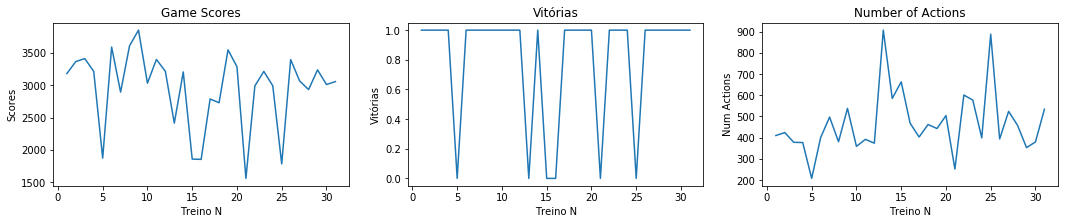

In [15]:
fig = plt.figure(figsize=(18, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

In [7]:
layoutType='mediumClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType,10, pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [0.5959905308632034, 0.5942567070144935]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[0.81874452 0.80204016 0.59321196 0.65486891 0.79387897]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [0.6086157005959308, 0.5913573926255524]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[0.81873728 0.80204254 0.59281007 0.65486559 0.79387897]]   -  ACTION:  East
STATE VARS:  0.018 -0.006944444444444444 1.0 0.01 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [0.6085

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.015625
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.015625
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.027777777777777776
Action Score:  [0.612090435856502, 0.15870857689763956, 0.6223838159801232]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.027777777777777776
W:  [[0.81857039 0.80206125 0.58237337 0.6566851  0.79380547]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00390625 0.015625
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
Action Score:  [0.5957046145061656, 0.6225082218189992]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
W:  [[0.81856404 0.80206125 0.58202036 0.65668329 0.79379566]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.02

STATE VARS:  0.018 -0.006944444444444444 1.0 0.04 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.02040816326530612 0
Action Score:  [0.6105055220325203, 0.15145403027938803]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.04 0
W:  [[0.81639168 0.80208977 0.57467231 0.65658369 0.80058603]]   -  ACTION:  North
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0625 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.027777777777777776 0
Action Score:  [0.6248337691554585, 0.15618143420646471]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0625 0
W:  [[0.81638446 0.80209256 0.57427107 0.65655861 0.80058603]]   -  ACTION:  North
STATE VARS:  0.018 -0.005917159763313609 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.04 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.04 0
Action Score:  [0.657170832325729, 0.1634512319607854, 0.6085994657993542]
['North', 'South', 'East', 'Stop']
-- ep

STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0.006944444444444444
STATE VARS:  0.018 -0.015625 1.0 0 0.00510204081632653
STATE VARS:  0.018 -0.015625 1.0 0 0.00510204081632653
Action Score:  [0.1219009170803983, 0.5671764355443812, 0.5671764355443812]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.015625 1.0 0 0.00510204081632653
W:  [[0.81617833 0.80222507 0.5606677  0.65848951 0.8047783 ]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 1.0 0 0.005917159763313609
STATE VARS:  -0.002 -0.01 1.0 0 0.005917159763313609
Action Score:  [0.5512625820598684, 0.5557750980707354]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 1.0 0 0.005917159763313609
W:  [[0.81617944 0.80223059 0.56011587 0.65848951 0.80477503]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0.005917159763313609
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0.005917159763313609
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0.005917159763313609
STATE VARS:  0.018

STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  0.018 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.25 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
Action Score:  [0.5230648883358364, 0.37265636822106984, 0.0878593595810051, 0.5230648883358364]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.81610771 0.80219607 0.55823436 0.65848951 0.80475208]]   -  ACTION:  North
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.0625 1.0 0 0
Action Score:  [0.5506410715437051, 0.5064648873030436]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.81610346 0.80220262 0.55799845 0.65848951 0.80475208]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
Action Score:  [0.11558400035688149, 0.010959290331852521]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
W:  [[0.81611064 

STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
Action Score:  [-0.003992059284886428, -0.0035317119183639212]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[0.81611119 0.80221034 0.5615154  0.65848951 0.80475208]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
Action Score:  [-0.004707503550187084, -0.0037821724399582975]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
W:  [[0.81611122 0.80221042 0.56151534 0.65848951 0.80475208]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
Action Score:  [-0.005470056073785933, -0.005009708810103521]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 

STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
Action Score:  [-0.007921274716525737, -0.007921274716525737]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
W:  [[0.8161118  0.80221234 0.5615144  0.65848951 0.80475208]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.01 0.002770083102493075 0 0
Action Score:  [-0.012223835039238583, -0.008098905464229297]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 0.002770083102493075 0 0
W:  [[0.81611182 0.80221245 0.56151437 0.65848951 0.80475208]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
Action Score:  [-0.012433724153310857, -0.012433724153310857]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
W:  [[0.8161119  0.80221309 0.56151425 0

STATE VARS:  -0.002 -0.01 0.01 0 0
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0 0
Action Score:  [-0.004039217716523828, -0.010267409900432593]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 0.01 0 0
W:  [[0.81611196 0.80221397 0.56151449 0.65848951 0.80475208]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
Action Score:  [-0.000270876617366269, -0.005013748012235787]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.006944444444444444 0.012345679012345678 0 0
W:  [[0.81611193 0.80221387 0.56151467 0.65848951 0.80475208]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.015625 0 0
STATE VARS:  -0.002 -0.01 0.01 0 0
Action Score:  [0.001570513157645094, -0.004039215902716154]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.006944444444444444 0.015625 0 0
W:  [[0.81611194 0.80221389 0.56151463 0.65848951 0.80475208]]   -  ACTION: 

STATE VARS:  1.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [1.3583479599286887, 0.12321537389499125]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  1.018 -0.027777777777777776 1.0 0 0
W:  [[0.82162879 0.81086744 0.55550282 0.65848951 0.80475208]]   -  ACTION:  South
Pacman emerges victorious! Score: 1883
Average Score: 1883.0
Scores:        1883.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.82162879 0.81086744 0.55550282 0.65848951 0.80475208]]
1883.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [0.5712611309356187, 0.5695147039914826]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[0.82150982 0.81089682 0.54889312 0.65844361 0.80475208]]   -  ACTION:  East
STATE VARS:  0.018 -0.00591715976331

STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.1111111111111111
STATE VARS:  0.418 -0.015625 1.0 0.00390625 0.008264462809917356
Action Score:  [0.22634960225133377, 0.8845434094437785]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.00390625 0.008264462809917356
W:  [[0.82095453 0.81092317 0.54340317 0.66053214 0.80825203]]   -  ACTION:  West
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0044444444444444444 0.012345679012345678
STATE VARS:  0.018 -0.015625 1.0 0.0034602076124567475 0.008264462809917356
STATE VARS:  -0.002 -0.015625 0.25 0.0034602076124567475 0.008264462809917356
Action Score:  [0.548568822390762, 0.554475020126589, 0.1305035551011864]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.015625 1.0 0.0034602076124567475 0.008264462809917356
W:  [[0.82089873 0.81097161 0.54030304 0.66052141 0.80822641]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.00390625 0.01
STATE VARS:  -0.002 -0.015625 1.0 0.

STATE VARS:  -0.002 0 1.0 1.0 0.006944444444444444
STATE VARS:  -0.002 0 0.1111111111111111 0.25 0.00510204081632653
Action Score:  [1.205903204132881, 0.22817444039515414]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.006944444444444444
W:  [[0.82088041 0.81103343 0.53743863 0.66238884 0.80820474]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.13750017211817195, 0.5588938507272259]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.82078178 0.81103343 0.53195944 0.66238884 0.80815946]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [0.5567107848130634, 0.13802729911334355]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.82077316 0.81103343 0.5314806  0.66238884 0.80815355]]   -  ACTION:  East


STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [0.16112658122809875, 0.6263508357119971, 0.16112658122809875, 0.16112658122809875]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[0.82061094 0.81103343 0.52189644 0.66238884 0.80778517]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
Action Score:  [0.17931946197062848, 0.73861373222658]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.82061906 0.81103343 0.52234766 0.66238884 0.80789797]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.418 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.25
Action Score:  [0.3309201680420888, 0.8753404715078033, 0.7390932913673096]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0 0.01234567901234567

STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.11566681907195939, 0.5265871213494558, 0.1202289121692582, 0.1202289121692582]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.82077601 0.81104162 0.51963896 0.66238884 0.80780163]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
Action Score:  [0.11559566260248164, 0.52630251168742]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.82077099 0.81104441 0.51935964 0.66238884 0.80780163]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
Action Score:  [0.11552579929272395, 0.526023074369566]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.82076596 0.8110472  0.51908059 0.66238884 0.80780163]]   -  ACTION:  East
STATE VARS:  0.018

STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.025008480038544993, 0.025008480038544993, 0.11937862410011524]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 0.25 0 0
W:  [[0.82069887 0.81114901 0.51663678 0.66238884 0.80780163]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.015625 1.0 0 0
Action Score:  [0.04765119912785824, 0.5023211815203563]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 1.0 0 0
W:  [[0.82069358 0.81110767 0.51928247 0.66238884 0.80780163]]   -  ACTION:  West
STATE VARS:  0.018 -0.015625 1.0 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
Action Score:  [0.5213813931226406, 0.511524181870209, 0.11550567202160601, 0.10564846076917431]
['North', 'South', 'East', 'West',

STATE VARS:  0.018 0 1.0 0.002066115702479339 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.015625
Action Score:  [0.5590776516066955, 0.14216760584327745]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.027777777777777776
W:  [[0.83432788 0.81079658 0.51978564 0.6645429  0.80764421]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
Action Score:  [0.5686162091041584, 0.146016513644193]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
W:  [[0.83432077 0.81079658 0.51939105 0.66454201 0.80762843]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0025 0.04
Action Score:  [0.5522640618119808, 0.146034355521523, 0.5683753204302029]
['North', 'South', 'West', 'S

STATE VARS:  0.018 -0.015625 1.0 0.0025 0.01
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.0030864197530864196 0.015625
Action Score:  [0.5256687373166546, 0.11887353978926181]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.015625 1.0 0.0025 0.01
W:  [[0.83366005 0.81091933 0.51322316 0.66451925 0.8074073 ]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.01
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.015625
Action Score:  [0.5378099613313231, 0.14109498276160282]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.01
W:  [[0.83365377 0.81091933 0.51287404 0.66451845 0.80740381]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0025 0.01
Action Score:  [0.5348597535857318, 0.13628653741386518]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.006944444444444444
W:  [[0.83364535 0.81091933 0.51240655 0.6

STATE VARS:  0.018 -0.0625 1.0 0.00390625 0
STATE VARS:  -0.002 -0.25 1.0 0.00510204081632653 0
Action Score:  [0.4800258561433007, 0.3113073297501444]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0625 1.0 0.00390625 0
W:  [[0.83365611 0.81517081 0.51296626 0.66443314 0.80757714]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 0.25 0.0044444444444444444 0
STATE VARS:  0.018 -0.0625 1.0 0.0044444444444444444 0
Action Score:  [-0.07426541507322734, 0.4799769263047669]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0625 1.0 0.0044444444444444444 0
W:  [[0.83365178 0.81518584 0.51272588 0.66443207 0.80757714]]   -  ACTION:  West
STATE VARS:  -0.002 -0.25 0.25 0.00390625 0
STATE VARS:  0.018 -0.0625 1.0 0.00510204081632653 0
Action Score:  [-0.07468685388815627, 0.4801724598561349]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0625 1.0 0.00510204081632653 0
W:  [[0.83364749 0.81520075 0.51248731 0.66443085 0.80757714]]   -  ACTION:  West
STA

STATE VARS:  0.018 -0.012345679012345678 1.0 0 0.00510204081632653
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0.00390625
Action Score:  [0.5147379322750628, 0.5004614966116697]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0.00510204081632653
W:  [[0.83166422 0.81528237 0.50253772 0.66675243 0.81049236]]   -  ACTION:  East
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0.005917159763313609
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0.0044444444444444444
Action Score:  [0.5056650685087608, 0.11750807426391074]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0.005917159763313609
W:  [[0.83165534 0.81529243 0.5020446  0.66675243 0.81048944]]   -  ACTION:  East
STATE VARS:  0.018 -0.04 1.0 0 0.005917159763313609
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0.005917159763313609
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0.0044444444444444444
Action Score:  [0.489198494904194, 0.505171571130255, 0.

STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [0.1304840848068248, 0.5234644804149419, 0.13379157767404887, 0.1304840848068248]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.83157738 0.81537107 0.50148087 0.66675243 0.81041582]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 0 0.1111111111111111 0 0.008264462809917356
Action Score:  [0.0640620758176804, 0.060754593657355124]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
W:  [[0.83158486 0.81537107 0.50106504 0.66675243 0.81036961]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.0625 0 0.01
STATE VARS:  -0.002 0 0.0625 0 0.01
STATE VARS:  -0.002 0 0.0625 0 0.015625
STATE VARS:  -0.002 0 0.25 0 

STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0625 1.0 0 0
Action Score:  [0.0028077688505282125, 0.4462799298032973]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.0625 1.0 0 0
W:  [[0.83150473 0.81526208 0.50130032 0.66675243 0.81038504]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0625 0.25 0 0
STATE VARS:  0.018 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.25 0 0
Action Score:  [0.07270819111453668, 0.3124518873639348, 0.07270819111453668]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.25 1.0 0 0
W:  [[0.83148067 0.81559623 0.49996374 0.66675243 0.81038504]]   -  ACTION:  East
STATE VARS:  -1.402 -1.0 1.0 0 0
STATE VARS:  -0.002 -0.25 0.1111111111111111 0 0
Action Score:  [-1.4813683888749987, -0.1500104921160675]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.25 0.1111111111111111 0 0
W:  [[0.83148786 0.81649515 0.49956422 0.66675243 0.81038504]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.0625 

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00390625
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00390625
Action Score:  [0.5194919156798475, 0.12767895728919246]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00390625
W:  [[0.83666665 0.81572317 0.49445178 0.66877072 0.81035953]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0016 0.00390625
Action Score:  [0.5149104856303602, 0.12617511217615612]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00510204081632653
W:  [[0.83665829 0.81572317 0.4939872  0.66876984 0.81035716]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0044444444444444444
Action Score:  [0.5152238196660871, 0.12658613000579802]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005

STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.01
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.015625
Action Score:  [0.13268454582713704, 0.523767944921885]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.015625
W:  [[0.83805584 0.8157349  0.49110399 0.66876308 0.81048823]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0.005917159763313609 0.012345679012345678
STATE VARS:  0.018 -0.027777777777777776 1.0 0.008264462809917356 0.02040816326530612
Action Score:  [0.12231723466754528, 0.5055972407421807]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.008264462809917356 0.02040816326530612
W:  [[0.83804854 0.81574617 0.49069815 0.66875973 0.81047994]]   -  ACTION:  West
STATE VARS:  0.018 -0.0625 1.0 0.01 0.015625
STATE VARS:  0.018 -0.027777777777777776 1.0 0.006944444444444444 0.015625
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.006944444444444444 0.015625
STATE VARS:  0.018 -0.0625 1.0 0.01

STATE VARS:  0.018 0 1.0 0 1.0
STATE VARS:  -0.002 0 0.25 0 1.0
Action Score:  [1.2661219856566706, 0.9136418318232451]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 1.0
W:  [[0.83739823 0.82172919 0.44659399 0.64463415 0.80235764]]   -  ACTION:  East
STATE VARS:  0.418 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.25
Action Score:  [0.8467738060178661, 0.31056311177535995]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0 0.0625
W:  [[0.83570608 0.82172919 0.44254579 0.64463415 0.80210463]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.25
Action Score:  [0.5077200374403501, 0.3094911917587956]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[0.83564966 0.82172919 0.43941118 0.64463415 0.80190871]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.1972824645621892, 0.48652922502923895]
['North', 'South', 'Stop']


STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.10083036732811798, 0.44206702613116927, 0.10083036732811798]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.83559216 0.82174453 0.43695313 0.64463415 0.80252596]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 0.04 0 0
Action Score:  [0.034039405130508876, 0.007589495541763712]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
W:  [[0.83559878 0.82179621 0.43658564 0.64463415 0.80252596]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.01 0.0625 0 0
STATE VARS:  -0.002 -0.01 0.0625 0 0
STATE VARS:  -0.002 -0.01 0.0625 0 0
Action Score:  [0.09463464549558416, 0.01739744253333367, 0.01739744253333367, 0.01739744253333367]
['North', 'South'

STATE VARS:  -0.002 -0.0625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
Action Score:  [-0.049482634159890924, -0.020929944539332165]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
W:  [[0.83551352 0.82231731 0.43357138 0.64463415 0.80252596]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.01 0 0
STATE VARS:  -0.002 -0.0625 0.006944444444444444 0 0
Action Score:  [-0.020177460785768736, -0.05005494672450612]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.027777777777777776 0.01 0 0
W:  [[0.83551351 0.82231714 0.43357145 0.64463415 0.80252596]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0625 0.008264462809917356 0 0
Action Score:  [-0.019160435949585004, -0.04948261330306999]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0 0
W:

STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0 0
Action Score:  [-0.0011102980677612714, -0.00297477252004435]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
W:  [[0.83551367 0.82231864 0.43356994 0.64463415 0.80252596]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0 0
Action Score:  [0.008645080620632396, 0.00022050002777111895]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
W:  [[0.83551356 0.82231751 0.43357338 0.64463415 0.80252596]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
Action Score:  [0.005519840065577604, 0.02972180297587622]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
W:  [[0.83551

STATE VARS:  0.018 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [0.44923070664622405, 0.4315664979844496]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[0.84106369 0.82228941 0.43319702 0.64458322 0.80252596]]   -  ACTION:  East
STATE VARS:  0.018 -0.006944444444444444 1.0 0.01 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [0.4490716573398595, 0.10689804627713181]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.01 0
W:  [[0.84105692 0.82229203 0.43282049 0.64457945 0.80252596]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.008264462809917356 0
Action Score:  [0.4476943673404344, 0.10613975081802665]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0.012345679012345

STATE VARS:  -0.002 0 1.0 0.00390625 0.015625
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
Action Score:  [0.43884316183265026, 0.466187533934291]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
W:  [[0.84093856 0.82229627 0.42523338 0.64668286 0.80246211]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.04
Action Score:  [0.4596211934168886, 0.4596211934168886, 0.12387739051562532, 0.47629527977618275]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.04
W:  [[0.84093575 0.82229627 0.4250772  0.64668194 0.80245586]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0069444

STATE VARS:  -0.002 -0.04 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.00390625 0
Action Score:  [0.07323084181905362, 0.4189468360105228]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.00390625 0
W:  [[0.84035067 0.82272347 0.41786739 0.64662786 0.80848233]]   -  ACTION:  South
STATE VARS:  -0.002 -0.04 0.25 0.0044444444444444444 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0034602076124567475 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0034602076124567475 0
Action Score:  [0.07275110805683567, 0.4184408895700999, 0.4184408895700999]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0034602076124567475 0
W:  [[0.84034717 0.82272744 0.41767259 0.64662719 0.80848233]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.00390625 0
STATE VARS:  -0.002 -0.012345679012345678 1.0 0.0030864197530864196 0
Action Score:  [0.4017274225053923, 0.4078305250130952

STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [0.5166992784286718, 0.1335904387116347]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[0.84026066 0.82270816 0.41162468 0.6489102  0.80812799]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [0.628781365997783, 0.15173364720810473]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.84026746 0.82270816 0.41200231 0.6489102  0.8082224 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0 0.25
Action Score:  [0.7597894050200493, 0.3033756415909758]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0 0.005917159763313609
W:  [[0.84044479 0.82270391 0.41242654 0.6489102  0.80822491]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0.00510204081632653
STATE VARS:  0.018 -0.015625 1.0 0 0.0069444444

STATE VARS:  0.018 -0.015625 1.0 0 0.005917159763313609
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0.005917159763313609
STATE VARS:  -0.002 -0.015625 0.25 0 0.0044444444444444444
Action Score:  [0.41554302994467046, 0.08235845604082911, 0.09117269818442389]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.015625 1.0 0 0.005917159763313609
W:  [[0.84034976 0.82322857 0.40830552 0.6489102  0.80818988]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 1.0 0 0.005917159763313609
STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0.005917159763313609
Action Score:  [0.3985440619909011, 0.025601308788350395]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 1.0 0 0.005917159763313609
W:  [[0.8403507  0.82323593 0.40783469 0.6489102  0.8081871 ]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.25 0 0.00510204081632653
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0.00510204081632653
STATE VARS:  -0.002 -0.015625 0.25 0 0.0

STATE VARS:  -0.002 -0.008264462809917356 0.0625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0 0
Action Score:  [0.017028942559582927, -0.0005058917202213475]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.008264462809917356 0.0625 0 0
W:  [[0.84033343 0.82338124 0.40802688 0.6489102  0.80832785]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
Action Score:  [0.03878357495510311, 0.007835604758567847]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.005917159763313609 0.1111111111111111 0 0
W:  [[0.84033318 0.82338049 0.40804099 0.6489102  0.80832785]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
Action Score:  [0.03945630097377663, 0.01810397569204103

STATE VARS:  -0.002 -0.002770083102493075 0.0025 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
Action Score:  [-0.0029415803591682035, -0.0029628103680600466]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.002770083102493075 0.0025 0 0
W:  [[0.84029464 0.8234207  0.40798099 0.6489102  0.80832785]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.0025 0.002770083102493075 0 0
Action Score:  [-0.0030364060949150114, -0.0026089997934487567]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.0025 0.002770083102493075 0 0
W:  [[0.84029466 0.82342073 0.40798096 0.6489102  0.80832785]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.0025 0 0
STATE VARS:  -0.002 -0.0025 0.0030864197530864196 0 0
Action Score:  [-0.002527804120127668, -0.002479940666256759]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.0025 0.0030864197530864196 0 0
W:  [[0

STATE VARS:  -0.002 -0.006944444444444444 0.0025 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0030864197530864196 0 0
Action Score:  [-0.006378845909687037, -0.006139598339068539]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.006944444444444444 0.0030864197530864196 0 0
W:  [[0.84029529 0.82342176 0.40798    0.6489102  0.80832785]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
Action Score:  [-0.00475158349752747, -0.005987101738878358]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
W:  [[0.84029529 0.82342177 0.40798    0.6489102  0.80832785]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
Action Score:  [-0.004861772041945146, -0.004622524513271727]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0

STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.015625 0.01 0 0
Action Score:  [-0.021720328247086047, -0.010466817568104397]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.01 0 0
W:  [[0.84029567 0.82342546 0.4079796  0.6489102  0.80832785]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0 0
Action Score:  [-0.01117488201179204, -0.01117488201179204, -0.02118178868393831, -0.009509829076597497]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0 0
W:  [[0.84029567 0.82342547 0.40797959 0.6489102  0.80832785]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.01 0 0
STATE VARS:  -0.002 -0.015625 0.015625 0 0
Action Score:  [-0.02047372533662794, -0.0081

STATE VARS:  -0.002 -0.04 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
Action Score:  [-0.023374706283997404, -0.007207794157387438, -0.007207794157387438, 0.006933891327075704]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
W:  [[0.84030444 0.82518508 0.40728378 0.6489102  0.80832785]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
Action Score:  [-0.0022297696910388784, 0.026732632242467903]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
W:  [[0.84030419 0.82518261 0.40729722 0.6489102  0.80832785]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0


STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00510204081632653
Action Score:  [0.4287271074433778, 0.10566829881946391]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
W:  [[0.83903451 0.82720223 0.40292942 0.65110762 0.80829558]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0016 0.0044444444444444444
Action Score:  [0.4240456864275499, 0.10368848392200887]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.005917159763313609
W:  [[0.83902745 0.82720223 0.40253674 0.65110688 0.80829326]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0044444444444444444
Action Score:  [0.4237672924159917, 0.10367893744576398]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:

STATE VARS:  0.018 -0.02040816326530612 1.0 0.04 0
STATE VARS:  -0.002 -0.04 1.0 0.02040816326530612 0
Action Score:  [0.41562703438043647, 0.36880201887213854]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.04 0
W:  [[0.86723304 0.85383772 0.39125432 0.65088294 0.8099796 ]]   -  ACTION:  East
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.018 -0.04 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.027777777777777776 0
Action Score:  [0.4301194361512362, 0.3907910847639536, 0.09673393542089476]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
W:  [[0.86722865 0.8538427  0.39101016 0.65086769 0.8099796 ]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [0.3978850494218204, 0.46839763996347167]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  

STATE VARS:  0.018 -0.1111111111111111 1.0 0.00390625 0.027777777777777776
STATE VARS:  -0.402 -1.0 1.0 0.00510204081632653 0.0625
Action Score:  [0.32530705076958744, -0.7684607959042571]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.00390625 0.027777777777777776
W:  [[0.86527499 0.85472009 0.3757396  0.65317159 0.81426069]]   -  ACTION:  North
STATE VARS:  -0.402 -1.0 0.25 0.0044444444444444444 0.04
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0044444444444444444 0.02040816326530612
Action Score:  [-1.0731523284297102, 0.31586620327847265]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0044444444444444444 0.02040816326530612
W:  [[0.86527168 0.85474056 0.37555538 0.65317077 0.81425693]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.25 0.00390625 0.02040816326530612
STATE VARS:  0.018 -0.1111111111111111 1.0 0.00510204081632653 0.012345679012345678
Action Score:  [-1.0895219948801342, 0.3095441582478229]
[

STATE VARS:  -0.402 -1.0 0.25 0.0625 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.027777777777777776 0
Action Score:  [-1.069638784421298, 0.30843365721132754]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.027777777777777776 0
W:  [[0.8632043  0.85591334 0.36969367 0.65278963 0.81763451]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.25 0.04 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.02040816326530612 0
Action Score:  [-1.0843864653860242, 0.3034521022462118]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.02040816326530612 0
W:  [[0.86320181 0.85592874 0.36955506 0.6527868  0.81763451]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.015625 0
Action Score:  [-1.0924141360075263, 0.3001892883365488]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.015625 0
W:  [[0.86319961 0.85594232 0.3694328 

STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0.01
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0 0.006944444444444444
Action Score:  [0.01729003866261202, 0.006400068757452821]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0.01
W:  [[0.86267038 0.85834612 0.342069   0.66106011 0.82327121]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0.008264462809917356
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0.008264462809917356
Action Score:  [0.025568951998079043, 0.046446167578757004, 0.028928899795185148, 0.008164447684352334]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
W:  [[0.86267002 0.85834612 0.34208901 0.66106011 0.82327343]]   -  ACTION:  South
STATE VARS: 

STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.07540603516292281, 0.02778698131573941]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 0.25 0 0
W:  [[0.86215566 0.85841868 0.34228906 0.66106011 0.82724717]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
Action Score:  [0.33198055977477803, 0.030346565402501607]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 1.0 0 0
W:  [[0.86215211 0.85840097 0.34406007 0.66106011 0.82724717]]   -  ACTION:  North
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.3509947979820459, 0.07832959533835422, 0.3536176898322246, 0.07570670348817556]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.8

STATE VARS:  -0.002 -0.027777777777777776 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.01 0 0
Action Score:  [-0.020212246966930428, -0.011708255016386587]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.01 0 0
W:  [[0.86214614 0.85857724 0.34313311 0.66106011 0.82724717]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0 0
Action Score:  [-0.006073853425830619, -0.010903350377781309]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
W:  [[0.86214607 0.8585769  0.34313353 0.66106011 0.82724717]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.01 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.015625 0 0
Action Score:  [-0.006878725836389883, -0.0023251703429417086]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.006944444444444444 0.015625 0 0
W:  [[0.86214604 0.85857679 0.34313377 0.66106011 0.82724717]]   -  ACTION:  South
STATE V

STATE VARS:  0.018 -0.015625 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.01 0.25 0.012345679012345678 0
Action Score:  [0.35656149010920485, 0.08305492283984976]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.015625 1.0 0.02040816326530612 0
W:  [[0.86798329 0.85851539 0.34058365 0.66099171 0.82724717]]   -  ACTION:  North
STATE VARS:  0.018 -0.015625 1.0 0.015625 0
STATE VARS:  -0.002 -0.01 0.25 0.015625 0
STATE VARS:  0.018 -0.01 1.0 0.027777777777777776 0
STATE VARS:  0.018 -0.01 1.0 0.015625 0
Action Score:  [0.35312104441614417, 0.08515278809558965, 0.3659830788177955, 0.3579501934976839]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0.027777777777777776 0
W:  [[0.86798197 0.85851613 0.34051024 0.66098967 0.82724717]]   -  ACTION:  East
STATE VARS:  0.018 -0.006944444444444444 1.0 0.04 0
STATE VARS:  -0.002 -0.01 1.0 0.02040816326530612 0
Action Score:  [0.37661158360767233, 0.343678698844308]
['East', 'West', 'Stop']


STATE VARS:  -0.002 0 0.25 0.006944444444444444 1.0
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.1111111111111111
STATE VARS:  0.418 -0.0625 1.0 0.01 0.01
Action Score:  [0.9142704260042072, 0.17883985009292527, 0.6602022570261301]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.25 0.006944444444444444 1.0
W:  [[0.86791    0.85850182 0.33751514 0.66341426 0.83277856]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.008264462809917356 1.0
STATE VARS:  -0.002 0 0.1111111111111111 0.005917159763313609 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.008264462809917356 1.0
Action Score:  [1.1740406378100179, 0.13222234100380287, 1.1740406378100179]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0.008264462809917356 1.0
W:  [[0.86790775 0.85850182 0.33863807 0.66342355 0.83390148]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.1111111111111111
S

STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.09366922999889958, 0.36809766106843056, 0.35790296965096335]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.8672455  0.85882283 0.32908285 0.66583151 0.83887463]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0 0.015625
Action Score:  [0.35065043481537767, 0.3404557778997389]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
W:  [[0.86724637 0.85882283 0.32864675 0.66583151 0.83886251]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.36137683252063313, 0.10372893238670115, 0.11398169642669848, 0.09754683904161927]
['North', 'South', 'East',

STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.2878115805734477, 0.31763190565655874, 0.05586994959986061, 0.31763190565655874]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.86858749 0.85882846 0.32574189 0.66583151 0.84250095]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0625 1.0 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.2703279332615287, 0.3175201158926308]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.8685855  0.85883155 0.32563098 0.66583151 0.84250095]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.05581414141266467, 0.3278462728840926]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0156

STATE VARS:  -0.002 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
Action Score:  [0.30080142298969215, 0.02110938673319192]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.027777777777777776 1.0 0 0
W:  [[0.86856119 0.85881226 0.3280964  0.66583151 0.84250095]]   -  ACTION:  North
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3198746055045544, 0.06686803612376484, 0.05643108155924889, 0.06686803612376484]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.86855904 0.85881558 0.32797709 0.66583151 0.84250095]]   -  ACTION:  North
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3197551605590163, 0.0668381600773181]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:

STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.06759960452961636, 0.05716269281379325, 0.3228006156918281]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.86855495 0.85880999 0.33097732 0.66583151 0.84250095]]   -  ACTION:  East
STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
Action Score:  [0.29293568120202995, 0.05715138618454793]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.86854614 0.85884057 0.33048805 0.66583151 0.84250095]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
Action Score:  [0.11404081420933587, -0.018693733486510898]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.25 1.0 0 0
W:  [[0.86854922 0.85922517 0.32894966 0.66583151 0.84250095]]   -  ACTION:  East


STATE VARS:  0.018 -0.01 1.0 0.04 0
STATE VARS:  -0.002 -0.015625 1.0 0.02040816326530612 0
Action Score:  [0.36187932120754124, 0.3265135794800476]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0.04 0
W:  [[0.87447529 0.85914489 0.32789715 0.66575308 0.84250095]]   -  ACTION:  East
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0625 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.01 0.25 0.027777777777777776 0
Action Score:  [0.379280987754309, 0.3561645614570563, 0.09012702880546136]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0625 0
W:  [[0.87447205 0.85914614 0.32771694 0.66574181 0.84250095]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 1.0 0.04 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.1111111111111111 0
Action Score:  [0.34663137345122885, 0.4130453485370629]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0051020408163265

STATE VARS:  -0.002 -0.015625 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.006944444444444444 0
Action Score:  [0.06931795284862688, 0.32089226886341216]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.006944444444444444 0
W:  [[0.87631367 0.85918104 0.32415267 0.66818536 0.84246644]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.0625 1.0 0.008264462809917356 0
Action Score:  [0.05937316082831477, 0.29174969860506345]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.0625 1.0 0.008264462809917356 0
W:  [[0.87630787 0.8592012  0.32383013 0.6681827  0.84246644]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0.006944444444444444 0
STATE VARS:  0.018 -0.25 1.0 0.01 0
Action Score:  [0.030145000588737425, 0.1314852033923857]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.25 1.0 0.01 0
W:  [[0.87628549 0.85951202 0.32258683 0.66

STATE VARS:  -0.002 -0.04 0.25 0.0625 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.25 0
Action Score:  [0.08364998273531492, 0.4800630006755784]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.25 0
W:  [[0.87647167 0.8788022  0.31579158 0.6678508  0.84246644]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.25 0.1111111111111111 0
STATE VARS:  0.018 -0.02040816326530612 1.0 1.0 0
Action Score:  [0.11624850885106128, 0.9814841344287197]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 1.0 0
W:  [[0.87653233 0.87873342 0.31916176 0.67122098 0.84246644]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
Action Score:  [0.18358126420157717, 1.005822874532918]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
W:  [[0.87653358 0.87873342 0.31853582 0.67059503 0.84245366]]   -  ACTION:  West
ST

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3517360059743504, 0.08958682170749527]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.87594571 0.87875859 0.31221026 0.67059503 0.84630946]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.36182966227598196, 0.0935722955189405]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.87594166 0.87875859 0.31198555 0.67059503 0.84630047]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.1111111111111111 0 0.02040816326530612
Action Score:  [0.34408568221646957, 0.05018461562479578]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.04
W:  [[0.87594253 0.87875859 0.31155233 0.67059503 0.84628314]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.0277777

STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.04 0.01 0 0
Action Score:  [-0.017577202885760323, -0.03386673188522061]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
W:  [[0.87589701 0.87887804 0.30380303 0.67059503 0.85173192]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.015625 0.005917159763313609 0 0
Action Score:  [-0.02365430391599178, -0.013686612241304522]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.005917159763313609 0 0
W:  [[0.87589696 0.87887763 0.30380319 0.67059503 0.85173192]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0 0
Action Score:  [-0.013934240592840284, -0.024055317007079535]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.00510204081632653 0 0
W:  [[0.8

STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
STATE VARS:  -0.002 -0.04 0.25 0 0
Action Score:  [-0.0007002760579222674, 0.039044381985248816]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.04 0.25 0 0
W:  [[0.87589643 0.87886834 0.30387808 0.67059503 0.85173192]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.04 1.0 0 0
Action Score:  [0.014076349796614568, 0.26697155446376525]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.04 1.0 0 0
W:  [[0.87589324 0.87880459 0.30547192 0.67059503 0.85173192]]   -  ACTION:  West
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
STATE VARS:  0.018 -0.04 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.3033032119668332, 0.28608581601093275, 0.056681406311478236, 0.056681406311478236]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1

STATE VARS:  -0.002 -0.1111111111111111 0.0625 0 0
STATE VARS:  -0.402 -1.0 0.25 0 0
Action Score:  [-0.08043311960097901, -1.1554365986872146]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.1111111111111111 0.0625 0 0
W:  [[0.87587568 0.87986445 0.30445085 0.67059503 0.85173192]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.04 0 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0 0
Action Score:  [-0.08733643387985826, -1.1981385993919507]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.1111111111111111 0.04 0 0
W:  [[0.87588208 0.88022015 0.30432279 0.67059503 0.85173192]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0
STATE VARS:  -0.402 -1.0 0.0625 0 0
Action Score:  [-0.09110059256492965, -1.2133045769133717]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0
W:  [[0.87588843 0.88057273 0.30423465 0.67059503 0.85173192]]   -  ACTION:  North


STATE VARS:  0.018 -0.01 1.0 0.04 0
STATE VARS:  -0.002 -0.015625 1.0 0.02040816326530612 0
Action Score:  [0.3400174747684926, 0.30428184472037484]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0.04 0
W:  [[0.88192815 0.88180187 0.3059166  0.6705185  0.85173192]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0.0625 0
STATE VARS:  0.018 -0.01 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.015625 0.25 0.027777777777777776 0
Action Score:  [0.35488069706663894, 0.3315988046671101, 0.07956265407197274]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0.0625 0
W:  [[0.88192489 0.88180368 0.3057356  0.67050719 0.85173192]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 1.0 0.04 0
STATE VARS:  0.018 -0.01 1.0 0.1111111111111111 0
Action Score:  [0.3170138591910058, 0.38729301396726157]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.01 1.0 0.1111111111111111 0
W:  [[0.88192658 0.88180275 0.30582907 0.67051757 0.85173

STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.0625
Action Score:  [0.10124647789202601, 0.37748531074912706]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.0625
W:  [[0.88357205 0.88176544 0.30348874 0.67308373 0.85187928]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.04
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.1111111111111111
Action Score:  [0.11216295720458357, 0.41960897035625466]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.1111111111111111
W:  [[0.88357466 0.88176544 0.30363405 0.67308493 0.85189542]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.04
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
Action Score:  [0.11289138022976553, 0.4209242872411197]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
W:  [[0.88357138 0.88176544 0.30345

STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 1.0 0 0.01
Action Score:  [0.3303100126215806, 0.3078334678283597]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[0.8830194  0.88180251 0.30077897 0.67579948 0.85618505]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.34045623558617305, 0.08680659469129731]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.88301567 0.88180251 0.30057177 0.67579948 0.8561793 ]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.3507132269945082, 0.3339391020126143, 0.09084995877757003]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.88301181 0.88180251 0.30035726 0.67579948 0.85617072]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0 0.111

STATE VARS:  0.018 -0.00510204081632653 1.0 0 0.002066115702479339
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0.002066115702479339
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0.0025
Action Score:  [0.3115964392022387, 0.07010642730587596, 0.0688533108742889]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0.002066115702479339
W:  [[0.8838336  0.88180554 0.29548438 0.67579948 0.85620778]]   -  ACTION:  North
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0.001736111111111111
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0.002066115702479339
Action Score:  [0.3083808448566917, 0.06774880152886043]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0.001736111111111111
W:  [[0.88382841 0.88180701 0.29519595 0.67579948 0.85620728]]   -  ACTION:  North
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0.001890359168241966
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0.001890359168241966
Action Sc

STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0 0
Action Score:  [-0.02263414508865459, -0.020263810915058054]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0 0
W:  [[0.88381261 0.88185907 0.29399574 0.67579948 0.85620625]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
Action Score:  [-0.021670026897087878, -0.021670026897087878, -0.007380124682298558]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
W:  [[0.88381243 0.88185761 0.29399833 0.67579948 0.85620625]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.015625 0.04 0 0
Action Score:  [-0.020263703821349413, -0.0037867169877584227]
['East', 'W

STATE VARS:  0.018 -0.012345679012345678 1.0 0.04 0
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.02040816326530612 0
Action Score:  [0.33547453888673145, 0.2963560109733984]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.04 0
W:  [[0.92298917 0.91985255 0.30296155 0.67590495 0.85620625]]   -  ACTION:  East
STATE VARS:  0.018 -0.008264462809917356 1.0 0.0625 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.027777777777777776 0
Action Score:  [0.354217325794428, 0.3307484039304792, 0.08131334194965416]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.0625 0
W:  [[0.92298648 0.91985379 0.30281212 0.67589561 0.85620625]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 1.0 0.04 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.1111111111111111 0
Action Score:  [0.3203998710797589, 0.38908246409609293]
['North', 'South', '

STATE VARS:  -0.002 0 0.25 0.01 0.015625
STATE VARS:  0.018 0 1.0 0.015625 0.027777777777777776
Action Score:  [0.09281714174919875, 0.3490001299109078]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.015625 0.027777777777777776
W:  [[0.92291474 0.91983777 0.29788675 0.67842909 0.85614934]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.04
Action Score:  [0.09847396157769954, 0.3625906819021279]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.04
W:  [[0.92291407 0.91983777 0.2978494  0.67842832 0.85614784]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.015625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
Action Score:  [0.3425347041389833, 0.3425347041389833, 0.10068937023227763, 0.3675530015798291]
['North', '

STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.1111111111111111 0 0
Action Score:  [0.28371173484853696, 0.025284618937192804]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
W:  [[0.92281918 0.91987654 0.29275106 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.2980053048732783, 0.06373984121675064, 0.2980053048732783, 0.06373984121675064]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.92281666 0.91987827 0.292611   0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
Action Score:  [0.2904486784238856, 0.2794088492475095]
['North', 'S

STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 1.0 0 0
Action Score:  [0.2943829804761628, 0.2685109560294783]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.9227467  0.91994285 0.28887849 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.27567568098569173, 0.051599786124136376]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
W:  [[0.92274747 0.91994762 0.28849229 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.05892020071265829, 0.28632730792775296, 0.05892020071265829, 0.0515031375403226]
['North', 'South', 'East', 'West', 'Stop']
--

STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
Action Score:  [0.05910195190089586, 0.28705597848415765]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
W:  [[0.92271604 0.92003367 0.28913805 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
Action Score:  [0.059080639442014304, 0.2869707391523466]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
W:  [[0.92271449 0.92003543 0.28905179 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
Action Score:  [0.05905905618776874, 0.2868844167725393]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
W:  [[0.92271294 0.92003719 0.28896559 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 

In [8]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

In [9]:
layoutType='originalClassic'
# pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,10,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.320947835144134, 0.3208609823886076]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.0022675736961451248 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.002770083102493075 0
STATE VARS:  -0.002 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.3207099883747558, 0.3212035458210681, 0.3021169036004637]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.002770083102493075 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.0030864197530864196 0
STATE VARS:  -0.002 -0.00111111

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.00390625
Action Score:  [0.3258849860023352, 0.0783430940546298]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.006944444444444444
Action Score:  [0.07944861557716534, 0.3275666742304662]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.01
Action Score:  [0.08111793974921229, 0.33030111354027386]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.01
W:  [[0.93720394 0.91846014 0.30346

STATE VARS:  0.018 0 1.0 0.0625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.04
Action Score:  [0.38040544399230736, 0.12715617731716822]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0625 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.04 0.04
Action Score:  [0.41354390641226824, 0.1354881335827584]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.25 0.015625
STATE VARS:  -0.002 0 0.25 0.0625 0.027777777777777776
Action Score:  [0.5041322963730874, 0.1403680071709976]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.25 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 1.0 0.015625
STATE V

STATE VARS:  -0.002 0 0.015625 0.0011890606420927466 0.001736111111111111
STATE VARS:  -0.002 0 0.027777777777777776 0.0013717421124828531 0.002066115702479339
Action Score:  [0.005163420097628927, 0.009258293428900003]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.027777777777777776 0.0013717421124828531 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0.0012755102040816326 0.002066115702479339
STATE VARS:  -0.002 0 0.02040816326530612 0.0012755102040816326 0.002066115702479339
STATE VARS:  -0.002 0 0.04 0.0014792899408284023 0.0025
Action Score:  [0.006956264130072226, 0.006956264130072226, 0.013411911166513477]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 0 0.04 0.0014792899408284023 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.027777777777777776 0.0013717421124828531 0.0022675736961451248
STATE VARS

STATE VARS:  0.018 -0.01 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.01 0.25 0.008264462809917356 0
STATE VARS:  0.018 -0.015625 1.0 0.012345679012345678 0
Action Score:  [0.3167850046278879, 0.07044142189749394, 0.3144008539270634]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 1.0 0.01 0
STATE VARS:  0.018 -0.01 1.0 0.006944444444444444 0
Action Score:  [0.2992240511096137, 0.31588514083136005]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0.008264462809917356 0
STATE VARS:  0.018 -0.015625 1.0 0.005917159763313609 0
Action Score:  [0.07044142189749394, 0.3100184969168911]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.3034

STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0.0022675736961451248 0
STATE VARS:  -0.002 -0.01 0.0625 0.0022675736961451248 0
STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0.002770083102493075 0
Action Score:  [0.0017228254545773002, 0.009453433544386929, 0.0020653888870377484]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0625 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.04 0.002066115702479339 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0.002066115702479339 0
STATE VARS:  -0.002 -0.006944444444444444 0.04 0.0025 0
Action Score:  [0.005294519382863065, 0.02406791821950038, 0.005590300700330484]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.1111111111111111 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.00189

STATE VARS:  -0.002 -0.027777777777777776 0.027777777777777776 0.0022675736961451248 0
STATE VARS:  -0.002 -0.015625 0.015625 0.001890359168241966 0
Action Score:  [-0.017411760783542046, -0.010195022959415096]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.015625 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0.002066115702479339 0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0.001736111111111111 0
Action Score:  [-0.019785523284768118, -0.011295337150351796]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0.001890359168241966 0
STATE VARS:  -0.002 -0.015625 0.01 0.0016 0
Action Score:  [-0.021356864931651384, -0.012099958684617851]
['East', 'West', 'Stop']
STATE VARS: 

STATE VARS:  0.018 -0.006944444444444444 1.0 0.002066115702479339 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.001736111111111111 0
Action Score:  [0.315365963217087, 0.07048958883072813]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.001890359168241966 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0022675736961451248 0
Action Score:  [0.07059474058158811, 0.3155032982419342]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.002066115702479339 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0025 0
Action Score:  [0.07071455477986009, 0.3156617445345544]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.00

STATE VARS:  -0.002 -0.001736111111111111 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.006944444444444444 0
Action Score:  [0.07587563393229232, 0.3231720973094802]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.001736111111111111 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.008264462809917356 0
Action Score:  [0.07643130501191006, 0.32407196110600806]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.001736111111111111 0.25 0.006944444444444444 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.01 0
Action Score:  [0.07713161064208676, 0.32525508637587774]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.01 0
W: 

STATE VARS:  0.018 -0.0044444444444444444 1.0 0.001890359168241966 0.00390625
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.0022675736961451248 0.00510204081632653
Action Score:  [0.32088485987929577, 0.0744690288646794]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.001890359168241966 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.0044444444444444444
Action Score:  [0.3244800767327308, 0.07920366697072415]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0016 0.002770083102493075
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.001890359168241966 0.0034602076124567475
Action Score:  [0.32061868984032443, 0.07415960068906477

STATE VARS:  0.018 0 1.0 0.006944444444444444 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.00390625
Action Score:  [0.329435535547331, 0.08081274329737535]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.0044444444444444444
Action Score:  [0.33103289295146354, 0.0818289449364113]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.01 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.005917159763313609
Action Score:  [0.33422459485443534, 0.08378944642454172]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.008264462809917356
W:  [[0.93720394 

STATE VARS:  -0.002 0 0.1111111111111111 0 0.00510204081632653
STATE VARS:  -0.002 0 1.0 0 0.00390625
Action Score:  [0.03620983047134077, 0.3049341578894254]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0 0.00390625
Action Score:  [0.0766331289014666, 0.32297671163186054, 0.07733465394717537]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
Action Score:  [0.0769529774873383, 0.3227060237862946]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Sou

STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.0790553803645473, 0.3274075397280434]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.027777777777777776 0 0.006944444444444444
STATE VARS:  -0.002 0 0.0625 0 0.01
Action Score:  [0.012497533177250705, 0.02564917236018685]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.0625 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.04 0 0.01
STATE VARS:  -0.002 0 0.1111111111111111 0 0.01
STATE VARS:  -0.002 0 0.04 0 0.015625
Action Score:  [0.01882118724191935, 0.0404009920601475, 0.023634474379064574]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.00

STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
Action Score:  [-0.006372459787042014, -0.0051977879298056836]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
Action Score:  [-0.006468457206713744, -0.005268321411753017]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.002267573696145124

STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0022675736961451248 0 0
Action Score:  [-0.012372795892506432, -0.019930360825778617]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0025 0 0
Action Score:  [-0.012276798472834702, -0.019859827343831283]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
Action Score:  [-0.008414932162013087, -0.012372795892506432]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0034602

STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
Action Score:  [-0.009263352437275385, -0.0057446197770056875]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.01 0 0
Action Score:  [-0.008951606458831585, -0.005217943238957506]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
Action Score:  [-0.008551025758596526, -0.004506109399467341, -0.008551025758596526]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.00694444444

STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.0625 0.01 0 0
Action Score:  [-0.025279786715360093, -0.0562435065406091]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.0625 0.008264462809917356 0 0
Action Score:  [-0.05748250975733614, -0.05677018307865728]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0625 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.0625 0.01 0 0
Action Score:  [-0.05717076377889233, -0.0562435065406091]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0625 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0

STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.04847931178444316, 0.30598473648707336]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
Action Score:  [0.059641153756679444, 0.3111510747713656]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
Action Score:  [0.06480749204097166, 0.3111510747713656]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  1.018 -0.015625 1.0 0 0
Action Score:  [0.06480749204097166, 1.2431886758942685]
['East', 'West', 'Stop']
STATE VARS:  1

STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.002770083102493075
Action Score:  [0.32430500032518667, 0.07723196339345065]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0016 0.00390625
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0030864197530864196
Action Score:  [0.324768965497792, 0.0775682530614655]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.00390625
Action Score:  [0.3258849860023352, 0.0783430940546298]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
W:  [[0.93720394 0.91846014 

STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.01 0.027777777777777776
Action Score:  [0.179721018853372, 0.7258036262507118]
['East', 'West', 'Stop']
STATE VARS:  0.418 0 1.0 0.01 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
Action Score:  [0.3434327793088799, 0.09987138416195374, 0.3601974256641068]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.01 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.04
Action Score:  [0.32587182579060564, 0.35929756186757894]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.04
W:  [[0.93720394

STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.002770083102493075
Action Score:  [0.07674303521725641, 0.3236411479462935]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.002770083102493075
Action Score:  [0.07680196836022948, 0.32314555109062343, 0.323714463893749]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.0013717421124828531 0.0025
STATE VARS:  0.018 0 1.0 0.0016 0.0030864197530864196
Action Score:  [0.304665960265138, 0.3240674404

STATE VARS:  -0.002 0 0.012345679012345678 0.0016 0.027777777777777776
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.0625
Action Score:  [0.026732134029240722, 0.059088412358288225]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.015625 0.001736111111111111 0.027777777777777776
STATE VARS:  -0.002 0 0.027777777777777776 0.002066115702479339 0.0625
Action Score:  [0.027820084164093324, 0.061444654032939076]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.027777777777777776 0.002066115702479339 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.04
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.04
STATE VARS:  -0.002 0 0.04 0.0022675736961451248 0.1111111111111111
Action Score:  [0.039835263809

STATE VARS:  0.018 -0.04 1.0 0.25 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0625 0
Action Score:  [0.45402364874827267, 0.014547561371915513]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.1111111111111111 0
STATE VARS:  0.018 -0.04 1.0 1.0 0
Action Score:  [0.047686023791876406, 0.9653027832276695]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.04 1.0 1.0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.1111111111111111 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.04
Action Score:  [0.10021928870616285, 1.0175249296586364]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.0012

STATE VARS:  -0.002 0 0.25 0.0016 0.01
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.006944444444444444
Action Score:  [0.08363977716597207, 0.3272131301246065]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.01
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.006944444444444444
Action Score:  [0.0835574884532038, 0.3271475283021576]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.008264462809917356
Action Score:  [0.08199908115764835, 0.07986596955912423, 0.3283426638880423]
['North', 'East'

STATE VARS:  0.018 -0.012345679012345678 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.008264462809917356 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.012345679012345678 0
Action Score:  [0.31741277953861924, 0.07203544362708274, 0.32116121394094443]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 1.0 0.01 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.015625 0
Action Score:  [0.3008180728392025, 0.3255526494194093]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0.015625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.012345679012345678 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.02040816326530612 0
Action Score:  [0.07697353549401803, 0.3301659885023307]
['East'

STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.3288926310761433, 0.07993442323421368]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.3262780059646076, 0.3288926310761433, 0.07993442323421368]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
Action Score:  [0.04240817901445772, 0.3086634609398995]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.005917159763

STATE VARS:  -0.002 -0.0030864197530864196 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0025 0.015625 0 0
Action Score:  [0.0037204498615475597, 0.0005710981047414975]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.04 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.02040816326530612 0 0
Action Score:  [0.006676497411791567, 0.001484022385168685]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.027777777777777776 0 0
Action Score:  [0.01301017238557432, 0.003377140612113149]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  E

STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.008264462809917356 0 0
Action Score:  [-0.005513426424219096, -0.006957004029007739]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0 0
Action Score:  [-0.004408156997761143, -0.005201680445775295]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.005917159763313609 0 0
Action Score:  [-0.004160796107110225, -0.0032568138091709307]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.003460

STATE VARS:  -0.002 -0.005917159763313609 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0 0
Action Score:  [-0.004801099745540236, -0.0035625893680018895, -0.003448469428431365]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.01 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.006944444444444444 0 0
Action Score:  [-0.004274423207492054, -0.003849050128666424]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.005917159763313609 0 0
Action Score:  [-0.004801099745540236

STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
STATE VARS:  -0.002 -0.01 0.0013717421124828531 0 0
Action Score:  [-0.007767057683110706, -0.010642732173994621]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.01 0.0014792899408284023 0 0
Action Score:  [-0.007725752587950816, -0.010610095064152603]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.01 0.0016 0 0
Action Score:  [-0.007678943546234765, -0.010573463664701544]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549

STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
Action Score:  [0.024253457484958597, 0.2902525833104853]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
Action Score:  [0.06640151377056046, 0.06265307936823528, 0.3127450965009544]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.3149010007844219, 0.06640151377056046]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.

STATE VARS:  -0.002 -0.0034602076124567475 0.01 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.015625 0 0
Action Score:  [-0.002017810592443889, -0.0012147966108163079]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
Action Score:  [-0.0022099590508930186, -0.0011158994793138907]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.015625 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0 0
Action Score:  [-0.002567426927925179, -0.001035376286402519]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0 0
W:  [[0.937

STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.04 0.04 0 0
Action Score:  [-0.09773235070137606, -0.0264741732457502]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.04 0.0625 0 0
Action Score:  [-0.0954959232249972, -0.0196461881274827]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.04 0 0
Action Score:  [-0.004894368427522049, -0.09178689427186423]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.04 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.25 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.06

STATE VARS:  -0.002 -0.0044444444444444444 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.02040816326530612 0 0
Action Score:  [0.002473158314173855, 0.0011407131357342743]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.04 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
Action Score:  [0.0002367308377949802, 0.006182187267306818, -0.0011158994793138907]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.027777777777777776 0 0
Action Score:  [0.011657542068465448, 0.001120527997064984]
['East',

STATE VARS:  -0.002 -0.0016 0.04 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.04 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.1111111111111111 0 0
Action Score:  [0.008794696108351378, 0.009004341879546313, 0.030584146697774466]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0013717421124828531 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.0625 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0 0
Action Score:  [0.01562268122661888, 0.07273220298337632]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0014792899408284023 1.0 0 0
Action Score:  [0.03037450092657953, 0.30023292853220873]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 1.0 0 0
W:  [[0.93720394 0.91846014 0.3034660

STATE VARS:  0.018 -0.0011890606420927466 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.0044444444444444444 0
Action Score:  [0.32327733179235374, 0.07606616195775516]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.006944444444444444 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.00510204081632653 0
Action Score:  [0.32397763742253044, 0.07651444902955871]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.005917159763313609 0
Action Score:  [0.3247981007423003, 0.07700534259905364]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0012755102

STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.00510204081632653
Action Score:  [0.32894091812335446, 0.08046191611694015]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.006944444444444444
Action Score:  [0.33192243335453975, 0.08229326583850155]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.01
Action Score:  [0.3297560953148076, 0.08259733539296053, 0.08259733539296053, 0.

STATE VARS:  -0.002 0 1.0 0.0013717421124828531 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0016 0.01
Action Score:  [0.30846905133646263, 0.329983359896366]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.01
Action Score:  [0.08094286334166811, 0.3300761475911419]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0016 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.012345679012345678
Action Score:  [0.08215468581787216, 0.33218848629631215]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STAT

STATE VARS:  -0.002 0 0.015625 0.0014792899408284023 0.002770083102493075
STATE VARS:  -0.002 0 0.027777777777777776 0.001736111111111111 0.0034602076124567475
Action Score:  [0.006246036181401941, 0.010699603945373929]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.027777777777777776 0.001736111111111111 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0.0016 0.0034602076124567475
STATE VARS:  -0.002 0 0.04 0.001890359168241966 0.0044444444444444444
Action Score:  [0.008370388774219164, 0.015355991668622162]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.04 0.001890359168241966 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.027777777777777776 0.001736111111111111 0.00390625
STATE VARS:  -0.002 0 0.0625 0.002066115702479339 0.00510204081632653
Action Score:  [0.011081280405210992, 0.022866493235510692

STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0.0011111111111111111 0
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0.0011111111111111111 0
Action Score:  [-0.017753638973092917, -0.017753638973092917]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0.001040582726326743 0
STATE VARS:  -0.002 -0.04 0.008264462809917356 0.0011890606420927466 0
Action Score:  [-0.01811346454024176, -0.035294240746911454]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0.001040582726326743 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.006944444444444444 0.0011111111111111111 0
STATE VARS:  -0.002 -0.04 0.006944444444444444 0.0011111111111111111 0
Action Score:  [-

STATE VARS:  -0.002 -0.008264462809917356 0.015625 0.001736111111111111 0
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0.001736111111111111 0
Action Score:  [-0.0035398146963940783, -0.008283411538795974]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.015625 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0.0016 0
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.001890359168241966 0
Action Score:  [-0.008376199233571864, -0.0019831354969228002]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0.001736111111111111 0
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0.002066115702479339 0
Action Score:  [-0.

STATE VARS:  -0.002 -0.02040816326530612 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.04 1.0 0.006944444444444444 0
Action Score:  [0.05872609830731121, 0.28833133664846816]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.04 1.0 0.008264462809917356 0
Action Score:  [0.059281769386928945, 0.289231200444996]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.006944444444444444 0
STATE VARS:  0.018 -0.04 1.0 0.01 0
Action Score:  [0.059982075017105646, 0.2904143257148657]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.01 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002

STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.015625
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.027777777777777776
Action Score:  [0.09039213776129101, 0.3481387557912595]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.015625
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.027777777777777776
Action Score:  [0.09084042483309457, 0.3488390614214362]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.04
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.02040816326530612
Action Score:  [0.09548902715178137, 0.36019

STATE VARS:  -0.002 -0.006944444444444444 1.0 0.008264462809917356 0.0012755102040816326
STATE VARS:  0.018 -0.00510204081632653 1.0 0.012345679012345678 0.0011111111111111111
Action Score:  [0.30193878015175324, 0.32501654525394463]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.012345679012345678 0.0011111111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.01 0.0011890606420927466
STATE VARS:  0.018 -0.00510204081632653 1.0 0.015625 0.001040582726326743
Action Score:  [0.07544842697897591, 0.3271917256280911]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.015625 0.001040582726326743
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.012345679012345678 0.001040582726326743
STATE VARS:  0.018 -0.00510204081632653 1.0 0.02040816326530612 0.0009182736455463728
Actio

STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
Action Score:  [0.0769529774873383, 0.3227060237862946]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0025
Action Score:  [0.0766331289014666, 0.322474914893283]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0025
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
Action Score:  [0.322474914893283, 0.0766331289014666]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
Action Score:  [0.3222760

STATE VARS:  -0.002 -0.0034602076124567475 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0044444444444444444 0 0
Action Score:  [-0.004002415263497419, -0.004607715141807257]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0034602076124567475 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.00390625 0 0
Action Score:  [-0.004115847171993849, -0.0038670565619746706]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002770083102493075 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0044444444444444444 0 0
Action Score:  [-0.0033685634098523116, -0.0037037328438679633]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102

STATE VARS:  -0.002 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.2872406576989295, 0.02265943575536981]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.2948228945148371, 0.059641153756679444]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
Action Score:  [0.2948228945148371, 0.26293191745130484, 0.04847931178444316]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.02777777

STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
Action Score:  [-1.2193496217573376, 0.2182845495623597]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
Action Score:  [0.2182845495623597, -1.2193496217573376, 0.2182845495623597]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 1.0 0 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
Action Score:  [-0.9917501178150876, 0.2182845495623597]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:

STATE VARS:  -0.402 -1.0 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0
Action Score:  [-1.2914696291793675, -0.09773235070137606]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.015625 0 0
Action Score:  [-0.030183202198883166, -0.09918387814998736]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.04 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
STATE VARS:  -0.002 -0.04 0.02040816326530612 0 0
Action Score:  [-0.008479852146718782, -0.03241962967526204]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS

STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.012345679012345678 0 0
Action Score:  [-0.0020594195107793423, -0.002813935106300323]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.015625 0 0
Action Score:  [0.00017700796559953248, -0.0018187726662236125]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.04 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.02040816326530612 0 0
Action Score:  [0.005

STATE VARS:  -0.002 -0.0011890606420927466 0.01 0 0
STATE VARS:  -0.002 -0.001040582726326743 0.006944444444444444 0 0
Action Score:  [6.81473706220367e-05, -0.0007227388204445249]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0011890606420927466 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0013717421124828531 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0011890606420927466 0.008264462809917356 0 0
Action Score:  [0.0006121955613464761, -0.00045852916742614505]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0013717421124828531 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0016 0.015625 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.01 0 0
Action Score:  [0.0013977122302282529, -9.963827814368862e-05]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]] 

STATE VARS:  0.018 -0.0022675736961451248 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0.008264462809917356 0
Action Score:  [0.3266691175525243, 0.07788980374655545]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.012345679012345678 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0.015625 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.01 0
Action Score:  [0.3284431138881026, 0.07872647250853228]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.015625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.012345679012345678 0
Action Score:  [0.33106997080027, 0.0798639999627113]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.02040816326530612 0
W:  [[0.

STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.006944444444444444
Action Score:  [0.33362669713613774, 0.08341251258441366]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.008264462809917356
Action Score:  [0.3365337478869758, 0.08509771742746718]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.01 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.008264462809917356
Action Score:  [0.3377168731568455, 0.08579802305764388]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.012345679012345678
W:  [[0.93720394 0.91846014 0.3034660

STATE VARS:  0.018 0 1.0 0.0625 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.0034602076124567475
Action Score:  [0.36531261832624434, 0.09588924172731596]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0625 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.04 0
Action Score:  [0.3935365222130258, 0.09808225117464396]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0.25 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.0625 0
Action Score:  [0.48821784341291413, 0.11342062520902586]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]  

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.01
Action Score:  [0.08148024072319145, 0.3301812993420019]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.01
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
Action Score:  [0.08395753080987993, 0.33488943472828714]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
Action Score:  [0.08584490356591817, 0.3388895782725803]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Wes

STATE VARS:  -0.002 -0.0625 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.006944444444444444 0
Action Score:  [0.0200664240711109, 0.29955696057483155]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.0625 1.0 0.005917159763313609 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.0625 0.25 0.005917159763313609 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.005917159763313609 0
Action Score:  [0.2669656778811226, 0.3004568243713594, 0.020622095150728638, 0.05251307221426088]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0625 1.0 0.006944444444444444 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.01

STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00510204081632653
Action Score:  [0.32782382345358535, 0.07964655502280123, 0.3259901377531952]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.005917159763313609
Action Score:  [0.32911180350964137, 0.3080633667709279]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.008264462809917356
Action Score:  [0.31404412016374783, 0.0826097744866272

STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.008264462809917356
Action Score:  [0.08549135946005848, 0.3282181289226203]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.012345679012345678
Action Score:  [0.32816499029764246, 0.08542575763760958]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.01
Action Score:  [0.3269873769455017, 0.08335963754032628]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.0069444

STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0.001040582726326743 0
STATE VARS:  -0.002 -0.00390625 0.00510204081632653 0.0009182736455463728 0
Action Score:  [-0.004665643934427205, -0.0032878546469961405]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.00510204081632653 0.0009182736455463728 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.005917159763313609 0.0008650519031141869 0
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0.0009765625 0
Action Score:  [-0.003076775311553507, -0.004545963157527848]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.005917159763313609 0.0008650519031141869 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.006944444444444444 0.0008163265306122449 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0.0009182736455463728 0
Action Score:  [-0.0027982456881496783,

STATE VARS:  -0.002 -0.01 0.25 0.0008163265306122449 0
STATE VARS:  0.018 -0.015625 1.0 0.0008163265306122449 0
STATE VARS:  0.018 -0.01 1.0 0.0009182736455463728 0
Action Score:  [0.06536398633700366, 0.30654123078310536, 0.31177706697764584]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.0009182736455463728 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 1.0 0.0008650519031141869 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0009765625 0
Action Score:  [0.2929967066342937, 0.31462320879264316]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0009765625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.0009182736455463728 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.001040582726326743 0
Action Score:  [0.06823989022884275, 0.31635902602701754]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005102

STATE VARS:  -0.002 -0.25 0.002770083102493075 0.0005408328826392645 0
STATE VARS:  -0.002 -0.0625 0.0034602076124567475 0.000594883997620464 0
Action Score:  [-0.23028012792539315, -0.05782257551110391]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0625 0.0034602076124567475 0.000594883997620464 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.25 0.0030864197530864196 0.0005668934240362812 0
STATE VARS:  -0.002 -0.0625 0.00390625 0.000625 0
Action Score:  [-0.2301663648909887, -0.05766668656474038]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0625 0.00390625 0.000625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.25 0.0044444444444444444 0.0006574621959237344 0
STATE VARS:  -0.002 -0.25 0.0034602076124567475 0.000594883997620464 0
Action Score:  [-0.2296925093317942, -0.230033851654178]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.25 0.0044444444444444444 0.00

STATE VARS:  -0.002 -0.01 0.0044444444444444444 0.0006574621959237344 0
STATE VARS:  -0.002 -0.01 0.005917159763313609 0.0007304601899196494 0
Action Score:  [-0.009262075868659337, -0.008765393699043686]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.005917159763313609 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.00510204081632653 0.0006925207756232687 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0.0007716049382716049 0
Action Score:  [-0.009038618097566748, -0.008425599118832205]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.006944444444444444 0.0007716049382716049 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.005917159763313609 0.0007304601899196494 0
STATE VARS:  -0.002 -0.01 0.008264462809917356 0.0008163265306122449 0
Action Score:  [-0.008765393699043686, -0.00799453146256453]
['East', 'West', 'Stop']
STATE VA

STATE VARS:  -0.002 -0.25 0.02040816326530612 0.001890359168241966 0
STATE VARS:  -1.402 -1.0 0.027777777777777776 0.001890359168241966 0
STATE VARS:  -0.002 -0.25 0.04 0.001890359168241966 0
STATE VARS:  -0.002 -0.25 0.027777777777777776 0.0022675736961451248 0
Action Score:  [-0.22400759068964643, -2.222701782955637, -0.2180621342601346, -0.2215140139901484]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.04 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 0.0625 0.001736111111111111 0
STATE VARS:  -1.402 -1.0 0.027777777777777776 0.002066115702479339 0
Action Score:  [-0.2113393008927271, -2.222581968757365]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.0625 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.0016 0
STATE VARS:  -1.402 -1.0 0.04 0.001890359168241966 0
Action

STATE VARS:  -0.002 -0.027777777777777776 0.00510204081632653 0.0011890606420927466 0
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0.0013717421124828531 0
Action Score:  [-0.025028304389877885, -0.013182820583124909]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0.0013717421124828531 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.005917159763313609 0.0012755102040816326 0
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0.0014792899408284023 0
Action Score:  [-0.024722010356253897, -0.012708923935434314]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0.0013717421124828531 0
STATE VARS:  -0.002 -0.015625 0.01 0.0016 0
Action Score:  [-0.024344662555361194, -0.0120999586846178

STATE VARS:  -0.002 -0.0014792899408284023 1.0 0.02040816326530612 0
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.04 0
Action Score:  [0.31414528593300867, 0.34643239139134585]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0012755102040816326 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.0625 0
Action Score:  [0.09175685239536176, 0.3619217594395796]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.04 0
STATE VARS:  0.018 -0.0009765625 1.0 0.1111111111111111 0
Action Score:  [0.10023980267480376, 0.3951837993956617]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]

STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  -0.002 0 0.0625 0 0.015625
Action Score:  [0.08254904834574936, 0.030462459497332076]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
Action Score:  [0.3086634609398995, 0.04240817901445772]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.08106395699764946, 0.08455623530005958, 0.3274075397280434]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STA

STATE VARS:  -0.002 -0.0025 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.02040816326530612 0 0
Action Score:  [-0.0004240643353352132, 0.0024211309857499813]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002066115702479339 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0025 0.015625 0 0
Action Score:  [0.004657558462128856, 0.0005710981047414975]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.04 0 0
STATE VARS:  -0.002 -0.0025 0.02040816326530612 0 0
Action Score:  [0.00836658741526182, 0.0020226255533527856]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556954

STATE VARS:  0.018 -0.001040582726326743 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.0009182736455463728 0.25 0.005917159763313609 0
Action Score:  [0.32501387226627493, 0.07718245612456351]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001040582726326743 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.01 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.006944444444444444 0
Action Score:  [0.326060626488928, 0.07777042573935315]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.01 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0013717421124828531 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.0011890606420927466 0.25 0.008264462809917356 0
Action Score:  [0.3274919031537603, 0.07853391848866433]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0013717421124828531 1.0 0.012345679012345678 

STATE VARS:  0.018 0 1.0 0.00510204081632653 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.01
Action Score:  [0.3297560953148076, 0.08259733539296053, 0.08259733539296053, 0.08521196050449621]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.008264462809917356
Action Score:  [0.329432723524759, 0.08409375927604588]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0051020408163265

STATE VARS:  -0.002 0 0.25 0.0016 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.005917159763313609
Action Score:  [0.07888591332681628, 0.32668763136079987]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.001736111111111111 0.005917159763313609
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.008264462809917356
Action Score:  [0.03809084059394405, 0.31007194340403005]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0

STATE VARS:  0.018 -0.012345679012345678 1.0 0.0034602076124567475 0.006944444444444444
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0034602076124567475 0.006944444444444444
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0044444444444444444 0.01
Action Score:  [0.3172978345018618, 0.06354918136034382, 0.32058341928750606]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0044444444444444444 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.00390625 0.01
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.015625
Action Score:  [0.29406737996858856, 0.33718400756348854]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0044444444444444444 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.02040816326530

STATE VARS:  -0.002 -0.006944444444444444 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.04 0
Action Score:  [0.08152625542336242, 0.3429178755516913]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0625 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.027777777777777776 0
Action Score:  [0.3582562495860732, 0.08824233655570718]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.00510204081632653 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.00390625 0.25 0.04 0
Action Score:  [0.3913947120060341, 0.0976725790211894]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   - 

STATE VARS:  -0.002 0 0.25 0.0016 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
Action Score:  [0.08564696412028229, 0.3388895782725803]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.015625
Action Score:  [0.3452885118764404, 0.08837077559034902]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0016 0.015625
Action Score:  [0.3453936636273004, 0.0884530643031173]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]

STATE VARS:  -0.002 -0.015625 0.25 0.0016 0
STATE VARS:  0.018 -0.01 1.0 0.001890359168241966 0
Action Score:  [0.06073188257690215, 0.3124397430372242]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.01 1.0 0.002066115702479339 0
STATE VARS:  -0.002 -0.01 0.25 0.001736111111111111 0
Action Score:  [0.31255955723549617, 0.06599100855597027]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.001890359168241966 0
STATE VARS:  0.018 -0.01 1.0 0.0022675736961451248 0
Action Score:  [0.06890256628842109, 0.31269689226034336]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002

STATE VARS:  -0.002 -0.027777777777777776 0.25 0.0044444444444444444 0
STATE VARS:  0.018 -0.015625 1.0 0.005917159763313609 0
Action Score:  [0.05150911406283959, 0.3100184969168911]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.01 1.0 0.006944444444444444 0
Action Score:  [0.06311924310687943, 0.31588514083136005]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.008264462809917356 0
Action Score:  [0.06884125247078939, 0.3195914106094787]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855

STATE VARS:  -0.002 -0.25 0.0625 0.0034602076124567475 0
STATE VARS:  -1.402 -1.0 0.027777777777777776 0.0044444444444444444 0
Action Score:  [-0.21016397480343782, -2.220960648943099]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.0625 0.0034602076124567475 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.0030864197530864196 0
STATE VARS:  -1.402 -1.0 0.04 0.00390625 0
Action Score:  [-0.19566696834776753, -2.2176185101096157]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.1111111111111111 0.0030864197530864196 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 0.25 0.002770083102493075 0
STATE VARS:  -1.402 -1.0 0.0625 0.0034602076124567475 0
Action Score:  [-0.15373456050072498, -2.2110945945458074]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.25 0.002770083102493075 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556

STATE VARS:  0.018 -0.0022675736961451248 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0.008264462809917356 0
Action Score:  [0.3266691175525243, 0.07788980374655545]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.012345679012345678 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0.015625 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.01 0
Action Score:  [0.3284431138881026, 0.07872647250853228]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.015625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.012345679012345678 0
Action Score:  [0.33106997080027, 0.0798639999627113]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.02040816326530612 0
W:  [[0.

STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.0014792899408284023 1.0
Action Score:  [0.17025288673338318, 1.1770396073211578]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0013717421124828531 1.0
STATE VARS:  -0.002 0 0.25 0.0016 0.1111111111111111
Action Score:  [1.1769662913737022, 0.17016009903860727]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.398 0 0.02040816326530612 0.0012755102040816326 0.001736111111111111
STATE VARS:  -0.002 0 0.04 0.0014792899408284023 0.25
Action Score:  [0.3815554564520914, 0.2251965452009035]
['East', 'West', 'Stop']
STATE VARS:  0.398 0 0.02040816326530612 0.0012755102040816326 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.681

STATE VARS:  -0.002 0 0.25 0.0025 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.01
Action Score:  [0.08163868701581167, 0.3279822697462056, 0.08395753080987993]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.005917159763313609
STATE VARS:  -0.002 0 0.1111111111111111 0.0022675736961451248 0.008264462809917356
Action Score:  [0.30854326522823555, 0.040461718201025364]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0025 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0025 0.0044444444444444444
STATE VARS:  -0.002 0 0.25

STATE VARS:  -0.002 0 0.25 0.001040582726326743 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0034602076124567475
Action Score:  [0.07707181203679471, 0.32410714941230917]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0011111111111111111 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0044444444444444444
Action Score:  [0.07771042805693741, 0.32500828957453753]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.00390625
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.00510204081632653
Action Score:  [0.0781452431417523, 0.3256365936473355]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531

STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.0625
Action Score:  [0.10339534248757014, 0.37785040478598314]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0625
Action Score:  [0.10249547869104228, 0.3772947337063654]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.25
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.0625
Action Score:  [0.5372893512060695, 0.1315068220555892]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Ea

STATE VARS:  -0.002 -0.012345679012345678 1.0 0.0016 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.0013717421124828531 0
Action Score:  [0.291343312130708, 0.014035076831508269]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.012345679012345678 1.0 0.001736111111111111 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0014792899408284023 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.0014792899408284023 0
Action Score:  [0.3101801786136278, 0.05625644906456566, 0.06366151947568971]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.012345679012345678 1.0 0.001890359168241966 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0016 0
Action Score:  [0.3102853303644878, 0.05633

STATE VARS:  -0.002 -0.008264462809917356 0.25 0.0016 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.001890359168241966 0
Action Score:  [0.06749224259078317, 0.3161896690502805]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.001736111111111111 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.002066115702479339 0
Action Score:  [0.06974093456902657, 0.3176621135656613]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.001890359168241966 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0022675736961451248 0
Action Score:  [0.07119871663699542, 0.3187034308884478]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0

STATE VARS:  -0.002 -0.001890359168241966 1.0 0.02040816326530612 0
STATE VARS:  0.018 -0.0016 1.0 0.04 0
Action Score:  [0.31376773523308316, 0.34613436044814316]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.0013717421124828531 1.0 0.0625 0
Action Score:  [0.09145882145215904, 0.36168238025372]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0013717421124828531 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.04 0
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.1111111111111111 0
Action Score:  [0.10000042348894415, 0.39498862832244663]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VAR

STATE VARS:  -0.002 0 0.25 0.01 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.015625 0.0034602076124567475
Action Score:  [0.0831794961822926, 0.33394820885271964]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.0034602076124567475
Action Score:  [0.08536909492732837, 0.3325548846769776, 0.3317126776577223, 0.33720891761853217]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.015625 0.00390625
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.00308641975

STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
Action Score:  [0.08455623530005958, 0.3377988494523576]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3441049953614418, 0.08736233548289458]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3441049953614418, 0.08736233548289458]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score: 

STATE VARS:  -0.002 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
Action Score:  [0.29240699598322173, 0.025465841736960648]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.06480749204097166, 0.06480749204097166, 0.30598473648707336, 0.06480749204097166]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.2948228945148371, 0.059641153756679444]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION

STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
Action Score:  [0.31395748075295643, 0.06930607231572952]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
Action Score:  [0.012406196330167015, 0.06761389802256251]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
Action Score:  [0.027158016030127664, 0.027158016030127664, 0.29521340196481255]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.

STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0025 0 0
Action Score:  [-0.010122385800098303, -0.007493938278380006]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.01 0.002770083102493075 0 0
Action Score:  [-0.00756447176032734, -0.010218383219770033]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.01 0.0025 0 0
Action Score:  [-0.007625607412892052, -0.010300344259970843]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556954

STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
Action Score:  [-0.006145200477240747, -0.009510713327926303]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
Action Score:  [-0.008551025758596526, -0.009263352437275385]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.01 0.01 0 0
Action Score:  [-0.0057446197770056875, -0.008951606458831585, -0.006145200477240747, -0.0080243492

STATE VARS:  -0.002 -0.00510204081632653 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0
Action Score:  [-0.004453026184073729, -0.005012133053168447]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.005917159763313609 0 0
Action Score:  [-0.0057446197770056875, -0.004764772162517529]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0
Action Score:  [-0.004453026184073729, -0.005012133053168447]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 

STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00510204081632653 0 0
Action Score:  [-0.005375014915321269, -0.005760787314870014]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0044444444444444444 0 0
Action Score:  [-0.005211691197214562, -0.0069038654903815794]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0
Action Score:  [-0.007067189208488287, -0.005012133053168447]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0


STATE VARS:  -0.002 -0.001736111111111111 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.002066115702479339 1.0 0 0
Action Score:  [0.030249488296490486, 0.29969395246134184]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001736111111111111 0.25 0 0
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.25 0 0
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0
Action Score:  [0.07239754458209234, 0.31874112731248627, 0.07209444851909183, 0.31874112731248627]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001736111111111111 1.0 0 0
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0
Action Score:  [0.2999970485243424, 0.31874112731248627]
['North', 'South', 'Stop']
STATE VA

STATE VARS:  0.018 -0.0016 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.012345679012345678 0
Action Score:  [0.3327784973433753, 0.0811483204233664]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0016 0.25 0.015625 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0.027777777777777776 0
Action Score:  [0.08317420584716882, 0.3375357208604048]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.001890359168241966 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.04 0
Action Score:  [0.08616823129083308, 0.3455212206181021]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855

STATE VARS:  0.018 0 1.0 0.01 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.005917159763313609
Action Score:  [0.33422459485443534, 0.08378944642454172]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.01
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.01
Action Score:  [0.33730874851613335, 0.08556835309073596, 0.33730874851613335]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.015625
STATE VARS:  -0.002 0 1.0 0.01 0.01
Action Score:  [0.34435756684827595, 0.3169656074143914]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.015625
W:  [[0.93720394 0.91846014 0.303466

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.008264462809917356
Action Score:  [0.08060119785352507, 0.3292959206494816]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0025 0.01
STATE VARS:  -0.002 0 0.25 0.0025 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.006944444444444444
Action Score:  [0.3305968948577413, 0.08163868701581167, 0.32838203532460514]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.01
Action Score:  [0.30942230809790194, 0.33043844856512106]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00226757

STATE VARS:  -0.002 0 0.01 0.0009765625 0.006944444444444444
STATE VARS:  -0.002 0 0.015625 0.0011111111111111111 0.01
Action Score:  [0.007768310012380383, 0.01218165393339533]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.015625 0.0011111111111111111 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.012345679012345678 0.001040582726326743 0.01
STATE VARS:  -0.002 0 0.02040816326530612 0.0011890606420927466 0.015625
Action Score:  [0.011138411904613576, 0.018499607144129664]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.02040816326530612 0.0011890606420927466 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.015625 0.0011111111111111111 0.012345679012345678
STATE VARS:  -0.002 0 0.027777777777777776 0.0012755102040816326 0.02040816326530612
Action Score:  [0.014188840887705546, 0.024887899002550676]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.0277777

STATE VARS:  -0.002 -0.04 0.25 0.001736111111111111 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0014792899408284023 0
Action Score:  [0.03843720437307842, 0.3026000317949596]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.04 0.25 0.0016 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0013717421124828531 0
Action Score:  [0.03834441667830252, 0.30252671584750407]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0013717421124828531 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.25 0.0014792899408284023 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0014792899408284023 0
Action Score:  [0.03826212796553424, 0.3026000317949596]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 

STATE VARS:  0.018 -0.002770083102493075 1.0 0.0625 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.027777777777777776 0
Action Score:  [0.36039805979306494, 0.33609387763944776, 0.09038414676269889]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.002770083102493075 1.0 0.04 0
Action Score:  [0.3939980570724449, 0.3263156069705391]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.25 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.0625 0
Action Score:  [0.4886793782723332, 0.11451601192209006]
['North', 'South', 'Stop']
STATE VARS

STATE VARS:  0.018 0 1.0 0.02040816326530612 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.008264462809917356
Action Score:  [0.3448121754312535, 0.08948007443763953]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.015625 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.012345679012345678
Action Score:  [0.34155146666544095, 0.09520788393504702, 0.348450498087345, 0.3498360822704312]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.015625
STATE VARS:  0.018 0 1.0 0.04 0.01
Action Score:  [0.32

STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [0.534259548927673, 0.1274730616257715]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [0.534259548927673, 0.1274730616257715]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.015625 0 1.0
STATE VARS:  -0.002 0 0.027777777777777776 0 0.1111111111111111
Action Score:  [0.8585627395013562, 0.10163248016142158]
['South', 'West', 'Stop']
STATE VARS:  -0.002 0 0.015625 0 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0 0.1111111111111111
STATE VARS:  0.398 -0.02040816326530612 0.012345679012345678 0 0.005917159763313609
Action Score:  [0.0993960

STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
Action Score:  [0.26293191745130484, 0.04847931178444316]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.25 0 0
Action Score:  [0.09072064130823074, 0.016588334720910917]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.25 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.25 0 0
Action Score:  [0.09072064130823074, 0.016588334720910917]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.25 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 0.015625 0 0
STATE VARS:  -0.002 -0.0625 0.012345679012345678 0 0
Action Score:  [-0.2267477864041163, -0.05553167270111893]
['East', 'West', 'Stop']


STATE VARS:  -0.002 -0.0016 0.25 0 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
Action Score:  [0.07252255721218138, 0.3185994566204271]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.25 0 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
Action Score:  [0.07252255721218138, 0.3185994566204271]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.01 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.015625 0 0
Action Score:  [-0.00030928404933862255, 0.0011310289080800366]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002066115702479339 0.02040816326530612 0 0
STATE VARS:  -0.00

STATE VARS:  -0.002 -0.001736111111111111 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.0022675736961451248 0 0
Action Score:  [-0.002780825200797503, -0.002780825200797503]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0014792899408284023 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.0025 0 0
Action Score:  [-0.0026060808454958524, -0.002710291718850169]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0014792899408284023 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.0022675736961451248 0 0
Action Score:  [-0.0025449451929311405, -0.0025449451929311405]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.001479289940

STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
Action Score:  [-0.012525290414654576, -0.012525290414654576]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0025 0 0
Action Score:  [-0.012586426067219289, -0.019859827343831283]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
Action Score:  [-0.012525290414654576, -0.012525290414654576]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0

STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
Action Score:  [-0.003730487260168616, -0.003730487260168616]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0025 0 0
Action Score:  [-0.0033300880533142386, -0.003659953778221282]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0022675736961451248 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0022675736961451248 0 0
Action Score:  [-0.0032689524007495268, -0.0032689524007495268]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.002267573696

STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
Action Score:  [-0.00877685601232939, -0.00877685601232939]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
Action Score:  [-0.0066820873814266, -0.008706322530382057]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
Action Score:  [-0.006620951728861888, -0.006620951728861888]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00

STATE VARS:  -0.002 -0.015625 0.0625 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
Action Score:  [0.002741277771116938, -0.01524854931938685]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.04 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
Action Score:  [-0.004086707347150564, 0.0063312554988413025, -0.01524854931938685]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
STATE VARS:  -0.002 -0.0625 0.25 0 0
Action Score:  [-0.008420564201119349, 0.016588334720910917]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0625 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]] 

STATE VARS:  -0.002 -0.02040816326530612 0.01 0 0
STATE VARS:  -0.002 -0.04 0.015625 0 0
Action Score:  [-0.017583832304408784, -0.03387115712387333]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0 0
Action Score:  [-0.010705438431332925, -0.01687199846491862, -0.01687199846491862]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
Action Score:  [-0.0073575847292427984, -0.010178761893284743]
['North', 'South', 'Stop']
STATE VARS:  -0

STATE VARS:  -0.002 -0.01 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
Action Score:  [-0.006317352940981468, -0.0077957363002835265]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.015625 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
Action Score:  [-0.007312515381058178, -0.010032163776662401, -0.007312515381058178, -0.007312515381058178]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.01 0 0
STATE VARS:  -0.002 -0.015625 0.015625 0 0
Action Score:  [-0.008024349220548344, -0.01148369122527369]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.01 0 0
W

STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
Action Score:  [0.06930607231572952, 0.31564965504612347, 0.06761389802256251]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.06761389802256251, 0.31564965504612347]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.06761389802256251, 0.3149010007844219]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855695

STATE VARS:  -0.002 -0.0030864197530864196 0.015625 0 0
STATE VARS:  -0.002 -0.00390625 0.01 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.01 0 0
Action Score:  [3.249493655739684e-05, -0.002427482745898434, -0.0016745013430094786]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0 0
Action Score:  [0.001484022385168685, -0.0009626675035193139]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.015625 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.027777777777777776 0 0
Action Score:  [0.0005710981047414975, 0.0037204498615475597]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -

STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.005917159763313609 0 0
Action Score:  [-0.024879206015125034, -0.05677018307865728, -0.025591532693803893]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.01 0 0
STATE VARS:  -0.002 -0.0625 0.006944444444444444 0 0
Action Score:  [-0.02435252947707685, -0.05717076377889233]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.008264462809917356 0 0
Action Score:  [-0.02364069563758

STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
Action Score:  [0.3185994566204271, 0.07190941738214032]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  1.018 -0.002066115702479339 1.0 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
Action Score:  [1.255641970656681, 0.07225587389003317]
['North', 'South', 'Stop']
STATE VARS:  1.018 -0.002066115702479339 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
Pacman emerges victorious! Score: 2893
Average Score: 2893.0
Scores:        2893.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]
2893.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.00

STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.0044444444444444444
Action Score:  [0.3264074032023957, 0.07866470684414358]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0016 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.00510204081632653
Action Score:  [0.3273687347848303, 0.07929301091694153]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.00510204081632653
Action Score:  [0.3274615224796062, 0.07936632686439707]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00694444444444444

STATE VARS:  0.018 -0.005917159763313609 1.0 0.0022675736961451248 0.0034602076124567475
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.001890359168241966 0.0034602076124567475
Action Score:  [0.319407702325469, 0.07415960068906477]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0.0022675736961451248 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.0025 0.00390625
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0025 0.0030864197530864196
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.002066115702479339 0.0030864197530864196
Action Score:  [0.07360424234753235, 0.3205989303493264, 0.07395956630146505]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0025 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 1.0 0.002770083102493075 

STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.015625
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.015625
Action Score:  [0.3344633687828876, 0.08823185782044458]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.012345679012345678
Action Score:  [0.3385082204332517, 0.0853668244946365]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0011111111111111111 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.02040816326530612
Action Score:  [0.08531368586965869, 0.3385563000219567]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.02040816326530612
W:  [[0.

STATE VARS:  -0.002 -0.1111111111111111 0.04 0.002066115702479339 0.0034602076124567475
STATE VARS:  -0.402 -1.0 0.02040816326530612 0.001736111111111111 0.0044444444444444444
Action Score:  [-0.08741752775566432, -1.2840363317043564]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.04 0.002066115702479339 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.1111111111111111 0.0625 0.0022675736961451248 0.0034602076124567475
STATE VARS:  -0.402 -1.0 0.027777777777777776 0.001890359168241966 0.0044444444444444444
Action Score:  [-0.08045220761254962, -1.2816947524771176]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.0625 0.0022675736961451248 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.1111111111111111 0.0025 0.0030864197530864196
STATE VARS:  -0.402 -1.0 0.04 0.00206611570

STATE VARS:  -0.002 -0.012345679012345678 0.25 0.0625 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.25 0
Action Score:  [0.105259673908185, 0.48317147466075333]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.1111111111111111 0
Action Score:  [0.990702174737825, 0.388490153460865, 0.1383981363281459]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 1.0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
STATE VARS:  -0.002 -0.012345679012345678 1.0 0.25 0
Action Score:  [1.0007602833034095, 0.46067896147028425]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
W:  [[0.9372

STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.012345679012345678 1.0
Action Score:  [0.17470330007490684, 1.1844472846536935]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.01 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.015625 0.0625
Action Score:  [0.1758864253447765, 0.7593498687540309]
['North', 'South', 'Stop']
STATE VARS:  0.418 0 1.0 0.015625 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.04
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.04
Action Score:  [0.11663603051718065, 0.36297961324757455, 0.42382907038876855, 0.36847585320838444]
['North', 'South', 'East', 'West', 'Stop']
STATE

STATE VARS:  -0.002 -0.0025 0.25 0.012345679012345678 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.02040816326530612 0
Action Score:  [0.08011206052668471, 0.3323503886502857]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.25 0.015625 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.027777777777777776 0
Action Score:  [0.08234759172168207, 0.33737429548946346]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.04 0
Action Score:  [0.08560830048749454, 0.3457062517550536]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556954

STATE VARS:  0.018 0 1.0 0 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0 0.0025
Action Score:  [0.322103642056258, 0.07613133216288906]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.001890359168241966
STATE VARS:  -0.002 0 0.25 0 0.0022675736961451248
Action Score:  [0.3219532479823889, 0.07593244602267948]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.001890359168241966
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.001736111111111111
STATE VARS:  -0.002 0 0.25 0 0.002066115702479339
Action Score:  [0.32182125861539906, 0.07576005932586408]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.001736111111111111
STATE VARS:  0.018 0 1.0 0 0.00

STATE VARS:  -0.002 -0.0008650519031141869 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.0009765625 0.0044444444444444444 0 0
Action Score:  [-0.0008732667345263062, -0.0014226038075869753]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0008650519031141869 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0007716049382716049 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.0008650519031141869 0.00510204081632653 0 0
Action Score:  [-0.0004756934437239028, -0.0011206276251772241]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0007716049382716049 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0007304601899196494 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0007716049382716049 0.005917159763313609 0 0
Action Score:  [-3.732293218070568e-05, -0.0007874394221677036]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00073046018

STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
Action Score:  [0.07144788252272123, 0.31825300011253427, 0.07190941738214032]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
Action Score:  [0.07190941738214032, 0.3185994566204271]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002066115702479339 0.25 0 0
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0
Action Score:  [0.07209444851909183, 0.31874112731248627]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551

STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
Action Score:  [-0.007067189208488287, -0.005623805525340447]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.0055103736168440175, -0.005719802945012177]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.00390625 0.0030864197530864196 0 0
Action Score:  [-0.005375014915321269, -0.0045255193254483935]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0030864197530864196 0 0
W: 

STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.015625 0.01 0 0
Action Score:  [-0.008951606458831585, -0.013190687504840565]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0 0
Action Score:  [-0.014429690721567606, -0.013717364042888747]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.01 0 0
Action Score:  [-0.014117944743123806, -0.02435252947707685]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0277

STATE VARS:  -0.002 -0.0016 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.012345679012345678 0 0
Action Score:  [0.002849239678839541, 0.00013586646800332587]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0016 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.015625 0 0
Action Score:  [0.005085667155218416, 0.0011310289080800366]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.04 0 0
Action Score:  [0.0025825563566913247, 0.008528012786203163]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  AC

STATE VARS:  -0.002 -0.0625 0.04 0 0
STATE VARS:  -0.002 -0.25 0.04 0 0
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
Action Score:  [-0.04713952638291909, -0.2193508025259932, -0.02555972156469094]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.0625 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
Action Score:  [-0.04031154126465159, 0.04847931178444316]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.015625 1.0 0 0
Action Score:  [0.0063312554988413025, 0.2872406576989295]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.

STATE VARS:  -0.002 -0.001890359168241966 0.04 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.04 0 0
Action Score:  [0.008528012786203163, 0.030107817604431316, 0.02976136109653846, 0.008528012786203163]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.0625 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
Action Score:  [0.01500954139657781, 0.07225587389003317]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0022675736961451248 1.0 0 0
Action Score:  [0.02976136109653

STATE VARS:  1.018 -0.0034602076124567475 1.0 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
Action Score:  [1.2543615528066652, 0.07144788252272123]
['East', 'West', 'Stop']
STATE VARS:  1.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
Pacman emerges victorious! Score: 3609
Average Score: 3609.0
Scores:        3609.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]
3609.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.320947835144134, 0.3208609823886076]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.0022675736961451248 0
STATE VAR

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.0022675736961451248
Action Score:  [0.3238895403012932, 0.07694088613013392]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.002770083102493075
Action Score:  [0.07702317484290219, 0.3239946920521532]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0025
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0030864197530864196
Action Score:  [0.07731484867788767, 0.3243851940959911]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0030864197530864196


STATE VARS:  0.018 0 1.0 0.015625 0.25
STATE VARS:  -0.002 0 0.25 0.015625 0.0625
Action Score:  [0.5449111975626604, 0.13812471026075893]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.02040816326530612 1.0
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
Action Score:  [1.1899435246145034, 0.17748548765837463]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.015625 0.0014792899408284023
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.027777777777777776 0.0012755102040816326
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.015625 0.0012755102040816326
Action Score:  [0.08047488842133498, 0.33628134367192686, 0.3279967280669366]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.00

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
Action Score:  [0.3332586606347414, 0.08691507790434745, 0.34082865173075405]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00390625 0.015625
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
Action Score:  [0.3176247515838915, 0.3475830847116418]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.0625
Action Score:  [0.10079121490944429, 0.37785040478598314]
['East', 'We

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.008264462809917356
Action Score:  [0.33208333454545214, 0.08207239710510389]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0016 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0016 0.012345679012345678
Action Score:  [0.3390875177182162, 0.33199054685067625, 0.08564696412028229]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.001736111111111111 0.015625
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.027777777777777776
Action Score:  [0.3161453559401432, 0.34551347782557235]
['North', 'South

STATE VARS:  -0.002 0 0.25 0.01 0.0625
STATE VARS:  0.018 0 1.0 0.015625 0.25
Action Score:  [0.13429011675216343, 0.5449111975626604]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.0625
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.25
Action Score:  [0.13588917906576156, 0.5481719063284729]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.027777777777777776 1.0
Action Score:  [0.179721018853372, 1.1949674314536811]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.027777777777777776 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.1111111111111111
STATE VARS:  

STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.08736233548289458, 0.33370591821328854]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
Action Score:  [0.33370591821328854, 0.08736233548289458, 0.3441049953614418]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.31905477066421367, 0.3545634958075845]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.0625 0 0.1111111111111111
A

STATE VARS:  -0.002 -0.002770083102493075 1.0 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [0.29904738646497125, 0.028665974383474263]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0025 1.0 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
Action Score:  [0.31803952581708855, 0.07115733991851053, 0.07144788252272123]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  0.018 -0.0025 1.0 0 0
Action Score:  [0.07115733991851053, 0.31803952581708855]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VAR

STATE VARS:  -0.002 -0.0013717421124828531 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.0012755102040816326 0.008264462809917356 0 0
Action Score:  [-0.0013386414948707301, -0.0005379296441840962]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.0012755102040816326 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0012755102040816326 0.01 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.006944444444444444 0 0
Action Score:  [-1.1253106135914424e-05, -0.0010268955164269293]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0012755102040816326 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0014792899408284023 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.008264462809917356 0 0
Action Score:  [0.0005134171679288583, -0.0006263148161918704]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 0.01234567901

STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.2940010177128105, 0.3149010007844219]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.06640151377056046, 0.3149010007844219]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.06640151377056046, 0.3149010007844219]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE V

STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.007202547910011035, -0.005719802945012177]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.007315979818507465, -0.005801763985212988]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.007411977238179195, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 

STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
Action Score:  [-0.005115826889604873, -0.004906397561436713]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
Action Score:  [-0.005019829469933143, -0.006123669177022836]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.005115826889604873, -0.006259027878545584]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.004444444444444

STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.0055103736168440175, -0.005719802945012177]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
Action Score:  [-0.007067189208488287, -0.005623805525340447]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
Action Score:  [-0.007202547910011035, -0.007411977238179195]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 

STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.008116249742383631, -0.006259027878545584]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
Action Score:  [-0.006123669177022836, -0.006372459787042014]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
Action Score:  [-0.005960345458916128, -0.004906397561436713]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0

STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.002770083102493075 0 0
Action Score:  [-0.006620951728861888, -0.008624361490181247]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.0025 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0025 0 0
Action Score:  [-0.0065504182469145545, -0.0065504182469145545]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
Action Score:  [-0.005268321411753017, -0.006468457206713744]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0


STATE VARS:  -0.002 -0.001736111111111111 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
Action Score:  [-0.0024189013504811985, -0.002628330678649359]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.00390625 0 0
STATE VARS:  -0.002 -0.0016 0.0030864197530864196 0 0
Action Score:  [-0.0024252133410176202, -0.0024073206288885815]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0016 0.002770083102493075 0 0
Action Score:  [-0.0025605720425403685, -0.0025033180485603125]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.002770083102493075 0 0
W:  [[0.93720394 0.918

STATE VARS:  -0.002 -0.002066115702479339 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.0034602076124567475 0 0
Action Score:  [-0.0024233149938522563, -0.0024189013504811985]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001736111111111111 0.00390625 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.0030864197530864196 0 0
Action Score:  [-0.0022835426489584503, -0.0022964532511112654]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001736111111111111 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.0034602076124567475 0 0
Action Score:  [-0.002120218930851743, -0.002183021342614836]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0017361111111111

STATE VARS:  -0.002 -0.001736111111111111 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.0034602076124567475 0 0
Action Score:  [-0.002120218930851743, -0.002183021342614836]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0016 0.00390625 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.00510204081632653 0 0
Action Score:  [-0.002158530018869404, -0.0020623314788647982]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.005917159763313609 0 0
Action Score:  [-0.0019952063007626967, -0.0018149705882138803]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.005917159763313609 0 0


STATE VARS:  -0.002 -0.0013717421124828531 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0016 0.02040816326530612 0 0
Action Score:  [0.0006121955613464761, 0.002849239678839541]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.015625 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.027777777777777776 0 0
Action Score:  [0.0013977122302282529, 0.004818983833070199]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.001890359168241966 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.04 0 0
Action Score:  [0.0025825563566913247, 0.008181556278310308]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]

STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
Action Score:  [0.31825300011253427, 0.07144788252272123]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
Action Score:  [0.3185994566204271, 0.07190941738214032]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
Action Score:  [0.07190941738214032, 0.3185994566204271]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0


STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
Action Score:  [-0.0011158994793138907, 0.0026736526667304437]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0625 0 0
Action Score:  [0.001120527997064984, 0.009501637784997945]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [0.0026736526667304437, -0.0010747817355947417, 0.024253457484958597]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0082644

STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0
Action Score:  [-0.0077957363002835265, 0.00575320338267276]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.04 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 0.04 0 0
Action Score:  [-0.004086707347150564, 0.02050502308263341, 0.02265943575536981, 0.0010796309371416575]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  -0.002 -0.015625 0.0625 0 0
Action Score:  [0.06480749204097166, 0.002741277771116938]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.25 0 0
W:  [[0

STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  -0.002 -0.0025 0.0625 0 0
Action Score:  [0.07115733991851053, 0.014796067101132125]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0 0
STATE VARS:  -0.002 -0.0025 0.1111111111111111 0 0
Action Score:  [0.29875684386076057, 0.029547886801092778]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  -0.002 -0.0025 0.25 0 0
STATE VARS:  0.018 -0.0025 1.0 0 0
Action Score:  [0.07115733991851053, 0.07169594308669464, 0.31803952581708855]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:

STATE VARS:  -0.002 -0.002066115702479339 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.0025 1.0 0.04 0
Action Score:  [0.08600680591989174, 0.3453077463226564]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.0025 1.0 0.0625 0
STATE VARS:  -0.002 -0.0025 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.027777777777777776 0
Action Score:  [0.3606461203570383, 0.09063220732667229, 0.33643718688888213]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0025 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0.04 0
Action Score:  [0.3937845827769992, 0.3260250643663284]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 

STATE VARS:  0.018 0 1.0 0.015625 0.01
STATE VARS:  -0.002 0 1.0 0.01 0.015625
Action Score:  [0.3395442797111307, 0.3217788945515366]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.012345679012345678
Action Score:  [0.3413198971288433, 0.09297235274004965]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.015625 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.015625 0.008264462809917356
Action Score:  [0.3380591883630308, 0.09520788393504702, 0.34634380396802106, 0.3380591883630308]
['North', 'South

STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.0034602076124567475 0.04
Action Score:  [0.39855725508207285, 0.7318039141747504]
['East', 'West', 'Stop']
STATE VARS:  0.418 0 1.0 0.0034602076124567475 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.00390625 0.04
Action Score:  [0.17117339957838207, 0.35722640796633137]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.0625
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.027777777777777776
Action Score:  [0.34646383796572966, 0.12983190423005936, 0.34713479763983823]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444

STATE VARS:  -0.002 -0.005917159763313609 0.25 0.0013717421124828531 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0011890606420927466 0
Action Score:  [0.06949254221402686, 0.3170642202961077]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.0012755102040816326 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0011111111111111111 0
Action Score:  [0.07077957070868683, 0.31791506396906916]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.0011890606420927466 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0011890606420927466 0
Action Score:  [0.07162461986365305, 0.317968202594047]
['North', 'West', 'Stop']
STATE VARS:  0.018

STATE VARS:  -0.002 -0.02040816326530612 0.04 0.001890359168241966 0
STATE VARS:  -0.002 -0.04 0.04 0.001890359168241966 0
STATE VARS:  -0.002 -0.02040816326530612 0.04 0.001890359168241966 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.0022675736961451248 0
Action Score:  [-0.007191183880860189, -0.02518550497989161, -0.007191183880860189, 0.014645770160487136]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.0625 0.002066115702479339 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0025 0
Action Score:  [-0.01823770566335213, 0.05695227273870922]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0025 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.0022675736961451248 0
STATE VA

STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0044444444444444444 0
STATE VARS:  0.018 -0.04 1.0 0.005917159763313609 0
Action Score:  [-0.025029230889637794, 0.28763103101829146]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.04 1.0 0.006944444444444444 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.00510204081632653 0
Action Score:  [0.28833133664846816, -0.02458094381783424]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0625 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.005917159763313609 0
Action Score:  [0.2685658473078271, -0.024025272738216502]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556954

STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
Action Score:  [0.07737088116335508, 0.3244800767327308, 0.3244800767327308]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0016 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00390625
Action Score:  [0.30532336166393936, 0.3249669049434279]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00390625
Action Score:  [0.07781664541646521, 0.32508671914169984]
['North', 

STATE VARS:  -0.002 0 0.1111111111111111 0.25 0.008264462809917356
STATE VARS:  -0.002 0 1.0 1.0 0.005917159763313609
Action Score:  [0.20934227887184653, 0.9883603969459931]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
Action Score:  [0.07993442323421368, 0.3247014694873366]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.3247014694873366, 0.07993442323421368]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.004444444444444444

STATE VARS:  -0.002 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
Action Score:  [0.3358194170194406, 0.4154129529487785]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
Action Score:  [0.1274730616257715, 0.534259548927673]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.418 0 1.0 0 0.002770083102493075
Action Score:  [0.2879159661972791, 0.6975875995491727]
['North', 'East', 'Stop']
STATE VARS:  0.418 0 1.0 0 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
Action Score:  [0.32227602875307343, 0.076362441055

STATE VARS:  -0.002 -0.002770083102493075 0.0625 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.027777777777777776 0 0
Action Score:  [0.01454800653715872, 0.004472527325177346]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.04 0 0
Action Score:  [0.028665974383474263, 0.007720021418891219]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.06991004837113683, 0.013914154683513614]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]  

STATE VARS:  -0.002 -0.027777777777777776 1.0 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.2760788157266932, 0.30598473648707336]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
Action Score:  [0.059641153756679444, 0.3111510747713656]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06480749204097166, 0.31395748075295643]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
Action Score:  [0.31564965504612347, 0

STATE VARS:  -0.002 -0.015625 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.01 0.002066115702479339 0 0
Action Score:  [-0.015698496853833874, -0.01043201339448289]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.01 0.0022675736961451248 0 0
Action Score:  [-0.015651687812117825, -0.015651687812117825, -0.010370877741918177]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.01 0.0025 0 0
Action Score:  [-0.01559835167877511, -0.010300344259970843]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.6817

STATE VARS:  -0.002 -0.0030864197530864196 0.015625 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.027777777777777776 0 0
Action Score:  [3.249493655739684e-05, 0.004010992465758256]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.04 0 0
Action Score:  [0.0017745649893793815, 0.007086169565246112]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0625 0 0
Action Score:  [0.003377140612113149, 0.01301017238557432]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68

STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.04 0.008264462809917356 0 0
Action Score:  [-0.018822835521135825, -0.018822835521135825, -0.036104829941488385]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.04 0.006944444444444444 0 0
Action Score:  [-0.01907019641178674, -0.03650541064172344]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
Action Score:  [-0.011864684144708816, -0.018822835521135825]
[

STATE VARS:  0.018 -0.0013717421124828531 1.0 0.0022675736961451248 0
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.002770083102493075 0
STATE VARS:  -0.002 -0.0011890606420927466 1.0 0.0022675736961451248 0
Action Score:  [0.320621603202748, 0.32113195228397423, 0.3020453100633698]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.002770083102493075 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0030864197530864196 0
STATE VARS:  -0.002 -0.0013717421124828531 1.0 0.0025 0
Action Score:  [0.32134760072253354, 0.3020359707072244]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0030864197530864196 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0034602076124567475 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.002770083102493075 0
Action Score:  [0.3216024139

STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.001736111111111111
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.002066115702479339
Action Score:  [0.07666119240000374, 0.3235121245203886]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.0025
Action Score:  [0.07704872759172267, 0.32402073238226076]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0025 0.002770083102493075
Action Score:  [0.07734092848681005, 0.3244102875678926]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.002770083102493075
W:  [[0.93720394 0.91846014 0.303

STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0025
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.0030864197530864196
Action Score:  [0.3232323654628821, 0.0775026512390166]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.0025
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.0030864197530864196
Action Score:  [0.3231842858741771, 0.07744371809604353]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0011111111111111111 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.002770083102493075
Action Score:  [0.07711989162549976, 0.3234634743558937]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.002770083102493075
W:  [[0.93720394 0.918

STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.01 0.04
Action Score:  [0.09618933278195807, 0.3613805509339765]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
Action Score:  [0.3434327793088799, 0.09708919657848594, 0.36297961324757455]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.01 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.015625 0.0625
Action Score:  [0.3321779716996899, 0.3844682929911528]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8

STATE VARS:  -0.002 -0.00510204081632653 0.25 0.002770083102493075 0.0030864197530864196
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0034602076124567475 0.0030864197530864196
Action Score:  [0.0738354887033654, 0.320649533116609]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0034602076124567475 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.0030864197530864196 0.002770083102493075
STATE VARS:  0.018 -0.006944444444444444 1.0 0.00390625 0.0034602076124567475
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0030864197530864196 0.002770083102493075
Action Score:  [0.07378044929635873, 0.31958127696377264, 0.3201240320267527]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0030864197530864196 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00591715976

STATE VARS:  -0.002 -0.005917159763313609 0.25 0.005917159763313609 0.001736111111111111
STATE VARS:  0.018 -0.00510204081632653 1.0 0.008264462809917356 0.001736111111111111
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.005917159763313609 0.002066115702479339
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.005917159763313609 0.001736111111111111
Action Score:  [0.07407676093358186, 0.3227691673523819, 0.07341562434297536, 0.07482541519528342]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.008264462809917356 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.006944444444444444 0.001890359168241966
STATE VARS:  0.018 -0.00510204081632653 1.0 0.01 0.0016
Action Score:  [0.0739655358992829, 0.3238358229581923]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.01 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8

STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0 0.012345679012345678
Action Score:  [0.3377988494523576, 0.3121557392423096]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3253609165732979, 0.08736233548289458]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
Action Score:  [0.1274730616257715, 0.09776141263104786, 0.3441049953614418, 0.09776141263104786]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.9372039

STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
Action Score:  [0.07040435851562157, 0.06930607231572952, 0.3167479412460155]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
Action Score:  [0.07040435851562157, 0.3171576133994701]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
Action Score:  [0.07081403066907613, 0.31625363110153076]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0

STATE VARS:  -0.002 -0.00390625 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
Action Score:  [-0.004113404997322509, -0.0055103736168440175]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.00390625 0 0
STATE VARS:  -0.002 -0.00390625 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
Action Score:  [-0.0042767287154292155, -0.0039138468532763935, -0.005375014915321269]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
Action Score:  [-0.0036664859626254756, -0.005211691197214562]
['East', 'West', 'Stop']
STATE VARS:  -0.0

STATE VARS:  -0.002 -0.0034602076124567475 1.0 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.1111111111111111 0 0
Action Score:  [0.29841353461132614, 0.02776199208553497]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
Action Score:  [0.06991004837113683, 0.3171576133994701, 0.07081403066907613, 0.06991004837113683]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
Action Score:  [0.06991004837113683, 0.3171576133994701]
['North', 'South', 'Stop']


STATE VARS:  -0.002 -0.002770083102493075 0.04 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.02040816326530612 0 0
Action Score:  [0.007720021418891219, 0.002236099848798471]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.0625 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.027777777777777776 0 0
Action Score:  [0.01454800653715872, 0.004472527325177346]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.04 0 0
Action Score:  [0.029299826237119374, 0.008181556278310308]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556

STATE VARS:  -0.002 -0.0034602076124567475 0.00390625 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
Action Score:  [-0.0038670565619746706, -0.005019829469933143]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0044444444444444444 0 0
Action Score:  [-0.004906397561436713, -0.0037037328438679633]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.00390625 0 0
Action Score:  [-0.0035041746998218486, -0.004771038859913965]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.005102

STATE VARS:  0.018 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.25 0 0
Action Score:  [0.09072064130823074, 0.016588334720910917]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.25 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -1.382 -1.0 1.0 0 0
STATE VARS:  -0.002 -0.25 0.25 0 0
Action Score:  [-1.9102099784341386, -0.15562294142216318]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 1.0 0 0
STATE VARS:  -0.002 -0.25 0.1111111111111111 0 0
Action Score:  [-1.9289540572222825, -0.19777099770776504]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  -0.002 -0.25 0.0625 0 0
Action Score:  [-2.1565535611645323, -0.2125228174077257]
['East', 'West', 'Stop']
STATE VARS:

STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.06480749204097166, 0.30598473648707336]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.06480749204097166, 0.30598473648707336]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.30598473648707336, 0.06480749204097166]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.30598473648707336, 0.06480749204097166]
['North', 'South', 'Stop']
STATE VARS:  0.018 

STATE VARS:  -0.002 -0.027777777777777776 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.02654656347629854, -0.015175292175894094]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
Action Score:  [-0.02645056605662681, -0.015039933474371346]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
Action Score:  [-0.019568436975462313, -0.011864684144708816]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0

STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.012345679012345678 0 0
Action Score:  [-0.003271803762781394, -0.005718493651469392]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.015625 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0 0
Action Score:  [-0.002567426927925179, -0.001035376286402519]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
Action Score:  [-0.0011158994793138907, 0.0026736526667304437]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
W:  [[0.937

STATE VARS:  -0.002 -0.0044444444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.25 0 0
Action Score:  [0.01301017238557432, 0.06855741805402796]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
Action Score:  [0.0264093617684261, 0.2940010177128105]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
Action Score:  [0.06640151377056046, 0.3127450965009544, 0.06265307936823528]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30

STATE VARS:  0.018 -0.00390625 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.00510204081632653 1.0 0.04 0
Action Score:  [0.39249299820592615, 0.3241737967635474]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.00390625 1.0 0.25 0
STATE VARS:  -0.002 -0.00390625 0.25 0.0625 0
Action Score:  [0.48717431940581446, 0.11301095305557131]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.1111111111111111 0
STATE VARS:  0.018 -0.00390625 1.0 1.0 0
Action Score:  [0.14690239687842116, 0.9984534538852112]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 1.0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.00390625
STATE VARS:  -

STATE VARS:  0.018 0 1.0 0.015625 0.0625
STATE VARS:  -0.002 0 0.25 0.015625 0.0625
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.0625
STATE VARS:  0.018 0 1.0 0.015625 0.25
Action Score:  [0.3844682929911528, 0.13812471026075893, 0.3927529085961431, 0.5449111975626604]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.25
STATE VARS:  0.418 -0.00510204081632653 1.0 0.012345679012345678 0.0030864197530864196
Action Score:  [0.529427827540329, 0.7015883837151893]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.012345679012345678 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.015625 0.002770083102493075
STATE VARS:  0.018 -0.006944444444444444 1.0 0.01 0.0034602076124567475
Action Score:  [0.0823280685

STATE VARS:  -0.002 -0.00510204081632653 0.25 0.04 0
STATE VARS:  0.018 -0.00390625 1.0 0.1111111111111111 0
Action Score:  [0.09657429282129736, 0.39249299820592615]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.25 0.0625 0
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.25 0
Action Score:  [0.11301095305557131, 0.4879273008087034]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.0030864197530864196 1.0 1.0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.1111111111111111 0
Action Score:  [0.9992064352881003, 0.14690239687842116]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 1.0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0

STATE VARS:  -0.002 0 1.0 0.015625 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.02040816326530612
Action Score:  [0.322807387877297, 0.3567351136923353]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.04 0.02040816326530612
Action Score:  [0.09846859270085949, 0.3650670699579254]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.04 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0625 0.02040816326530612
Action Score:  [0.10349249954003724, 0.38040544399230736]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0625 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]

STATE VARS:  0.018 0 1.0 0.0008650519031141869 0.01
STATE VARS:  -0.002 0 0.25 0.0009765625 0.015625
Action Score:  [0.3294823417272153, 0.0880280635225813]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0008650519031141869 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0009182736455463728 0.012345679012345678
Action Score:  [0.32796403402407537, 0.08518222750633983]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0008650519031141869 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0008650519031141869 0.012345679012345678
Action Score:  [0.32799725037911537, 0.08514594595113155]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0008650519031141869 0.008264462809917356
W:  [[0.93720394 0.91846

STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.0008650519031141869 0
STATE VARS:  -0.002 -0.0034602076124567475 1.0 0.0007716049382716049 0
Action Score:  [0.0704997590222088, 0.2989395419513255]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 1.0 0.0007716049382716049 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.0007304601899196494 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.0008163265306122449 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0007304601899196494 0
Action Score:  [0.07194584126095294, 0.07137052496510812, 0.3182894239913469]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.0007716049382716049 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.0006925207756232687 0
Action 

STATE VARS:  -0.002 -0.0044444444444444444 0.01 0.0007716049382716049 0
STATE VARS:  -0.002 -0.0044444444444444444 0.01 0.0006925207756232687 0
STATE VARS:  -0.002 -0.005917159763313609 0.015625 0.0007716049382716049 0
Action Score:  [-0.0023957855503838037, -0.0024496976600236293, -0.0020414195879257992]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.015625 0.0007716049382716049 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.0008163265306122449 0
STATE VARS:  -0.002 -0.005917159763313609 0.012345679012345678 0.0007304601899196494 0
Action Score:  [-0.002715309466749397, -0.0030646306297701905]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.0008163265306122449 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0.0008650

STATE VARS:  0.018 -0.002770083102493075 1.0 0.0014792899408284023 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.0012755102040816326 0
Action Score:  [0.3187999053605696, 0.07277893971969032]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0016 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.0013717421124828531 0
Action Score:  [0.3188821940733379, 0.07284454154213922]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.0014792899408284023 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.001736111111111111 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0014792899408284023 0
Action Score:  [0.07291785748959476, 0.31943651662753286, 0.318799

STATE VARS:  -0.002 -0.005917159763313609 0.25 0.002066115702479339 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.001736111111111111 0
Action Score:  [0.06996590051815853, 0.313928613015953]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.001890359168241966 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0016 0
Action Score:  [0.06769018203641905, 0.3100873909188519]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0014792899408284023 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.001736111111111111 0
Action Score:  [0.3100051022060836, 0.06758503028555907]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0014792899408284023 

STATE VARS:  -0.002 -0.0034602076124567475 0.001890359168241966 0.0009765625 0
STATE VARS:  -0.002 -0.002770083102493075 0.0016 0.0008650519031141869 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0016 0.0008650519031141869 0
Action Score:  [-0.003813082860034434, -0.0033433625318800135, -0.00397721438552512]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0016 0.0008650519031141869 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.0014792899408284023 0.0008163265306122449 0
STATE VARS:  -0.002 -0.0034602076124567475 0.001736111111111111 0.0009182736455463728 0
Action Score:  [-0.003413210286371046, -0.0038996277351569463]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0014792899408284023 0.0008163265306122449 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.0013717421124828531 0.

STATE VARS:  -0.002 -0.002770083102493075 0.0013717421124828531 0.0007716049382716049 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0011890606420927466 0.0006925207756232687 0
Action Score:  [-0.0034763343522456807, -0.003124149218520056]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0011890606420927466 0.0006925207756232687 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.0012755102040816326 0.0007304601899196494 0
STATE VARS:  -0.002 -0.002770083102493075 0.0012755102040816326 0.0007304601899196494 0
Action Score:  [-0.003533586066834073, -0.003533586066834073]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0012755102040816326 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 0.0013717421124828531 0.0007716049382716049 0
STATE VARS:  -0.002 -0.002770083102493075 

STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0.0014792899408284023 0
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0.0012755102040816326 0
Action Score:  [-0.003897957453982281, -0.004246304552054879]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.00390625 0.0016 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0.0013717421124828531 0
Action Score:  [-0.003680310039691251, -0.004084705309934246]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.00390625 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0.0014792899408284023 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0044444444444444444 0.001736111111111111 

STATE VARS:  0.018 -0.0034602076124567475 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.015625 0
Action Score:  [0.33609387763944776, 0.08056169700612427]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.04 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.02040816326530612 0
Action Score:  [0.3444258339050379, 0.08382240577193674]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0625 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.027777777777777776 0
Action Score:  [0.3597642079394198, 0.08884631261111449]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.3034

STATE VARS:  -0.002 0 0.0625 0 0.002770083102493075
STATE VARS:  -0.002 0 0.04 0 0.0034602076124567475
STATE VARS:  -0.002 0 0.04 0 0.002770083102493075
STATE VARS:  -0.002 0 0.1111111111111111 0 0.002770083102493075
Action Score:  [0.019462565070338136, 0.013225116383508288, 0.012634579952070636, 0.03421438477029879]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.0625 0 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0 0.0022675736961451248
Action Score:  [0.019462565070338136, 0.07593244602267948]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0 0.0025
STATE VARS:  -0.002 0 1.0 0 0.002066115702479339
Action Score:  [0.0339832758772872, 0.30335956326811414]
['East', 'West'

STATE VARS:  -0.002 -0.002770083102493075 0.04 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [0.007720021418891219, 0.029299826237119374, 0.028665974383474263]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.07144788252272123, 0.013914154683513614]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 1.0 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [0.29904738646497125, 0.028665974383474263]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0027700831

STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.04 1.0 0 0
Action Score:  [0.055248008957111225, 0.2835972705884737]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.04 0.005917159763313609 0 0
Action Score:  [-0.018110508842456966, -0.03681715662016724]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.01 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
Action Score:  [-0.017583832304408784, -0.018511089542692025]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0

STATE VARS:  0.018 -0.0009765625 1.0 0.0034602076124567475 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.002770083102493075 0
Action Score:  [0.3217975850400389, 0.07485996309067414]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0034602076124567475 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.00390625 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0030864197530864196 0
Action Score:  [0.3221016545944979, 0.07507561152923344]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0034602076124567475 0
Action Score:  [0.3224685447141475, 0.0753304247735238]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
W:  [[0.93720394 0.91846014 0.30

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.00390625
STATE VARS:  0.018 0 1.0 0.0025 0.00510204081632653
Action Score:  [0.07874313641130594, 0.3264057332689346]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.005917159763313609
Action Score:  [0.07934100199557134, 0.3272873440163795]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0025 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0025 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0025 0.005917159763313609
Action Score:  [0.3262427965969851, 0.3258430310185855, 0.07949944828819

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.005917159763313609
Action Score:  [0.08046386282867787, 0.32710322687653925]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.0044444444444444444
Action Score:  [0.326944780583919, 0.08060119785352507, 0.32602714815842576]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0.0025 0.00510204081632653
Action Score:  [0.3279822697462056, 0.30766165448079064]
['North', 'South', 'Stop']
ST

STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0025
Action Score:  [0.3237873008264375, 0.07706645632288796]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.002770083102493075
Action Score:  [0.3240540107873313, 0.07723196339345065]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0034602076124567475
Action Score:  [0.07717303025047757, 0.32410714941230917]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00118906064209274

STATE VARS:  -0.002 0 0.015625 0.0009765625 0.01
STATE VARS:  -0.002 0 0.027777777777777776 0.0011111111111111111 0.006944444444444444
Action Score:  [0.012089931403482938, 0.013254983746849813]
['South', 'East', 'Stop']
STATE VARS:  -0.002 0 0.027777777777777776 0.0011111111111111111 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.04 0.0011890606420927466 0.005917159763313609
STATE VARS:  -0.002 0 0.02040816326530612 0.001040582726326743 0.008264462809917356
Action Score:  [0.016138108455294217, 0.012100010445201672]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.04 0.0011890606420927466 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.0625 0.0012755102040816326 0.0044444444444444444
STATE VARS:  -0.002 0 0.027777777777777776 0.0011111111111111111 0.005917159763313609
Action Score:  [0.021764830858581066, 0.012375940877183432]
[

STATE VARS:  0.018 -0.04 1.0 0.00390625 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0030864197530864196 0
Action Score:  [0.2862601827472206, -0.02595500380803671]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.04 1.0 0.0044444444444444444 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0034602076124567475 0
Action Score:  [0.28662707286687017, -0.025700190563746353]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.0044444444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.04 1.0 0.00510204081632653 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.00390625 0
STATE VARS:  -0.002 -0.04 0.25 0.00390625 0
STATE VARS:  -0.002 -0.04 0.25 0.00390625 0
Action Score:  [0.2870753599386737, -0.02539612100928737, 0.03991660001682666, 0.03991660001682666]
['North', 'South', 'East', 'West', 'S

STATE VARS:  -0.002 0 1.0 0.0013717421124828531 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
Action Score:  [0.3130908634023085, 0.3388895782725803]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.015625
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.027777777777777776
Action Score:  [0.08837077559034902, 0.3452885118764404]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0016 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0625
Action Score:  [0.09885214145127057, 0.375105312622024]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -

STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0.0016 0.002770083102493075
STATE VARS:  -0.002 -0.0625 0.02040816326530612 0.001890359168241966 0.0034602076124567475
Action Score:  [-0.017732929308044286, -0.04883543049450299]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0.0016 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.015625 0.001736111111111111 0.0030864197530864196
STATE VARS:  -0.002 -0.02040816326530612 0.027777777777777776 0.001736111111111111 0.0030864197530864196
Action Score:  [-0.03004660514267707, -0.008364329118655485]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.027777777777777776 0.001736111111111111 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.04 0.001890359168241966 0.00390625
STATE VARS:  -0.002 -0.

STATE VARS:  -0.402 -1.0 0.25 0.012345679012345678 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.02040816326530612 0
Action Score:  [-1.2109335043173475, 0.23219690696315964]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.1111111111111111 1.0 0.015625 0
STATE VARS:  -0.402 -1.0 0.25 0.015625 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.027777777777777776 0
Action Score:  [0.22893619819734712, -1.2086979731223502, 0.2372208138023374]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 1.0 0.02040816326530612 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0.04 0
Action Score:  [-0.9778377604142876, 0.24555277006792753]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0.04

STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0.00390625
Action Score:  [0.07835788675694264, 0.015000102580371856]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.1111111111111111 0 0.00510204081632653
Action Score:  [0.3075339271764637, 0.03620983047134077]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
Action Score:  [0.3274075397280434, 0.08106395699764946, 0.0790553803645473]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.6

STATE VARS:  -0.002 -0.01 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
Action Score:  [-0.0026293980159913053, 0.010714022036999997]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.04 0 0
STATE VARS:  -0.002 -0.01 0.04 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
Action Score:  [0.0038860369187324953, 0.0010796309371416575, 0.025465841736960648]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.0625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
Action Score:  [0.00790761605540916, 0.06761389802256251]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
W:  [[0.93720394 0.91846014 0.303466

STATE VARS:  -0.002 -0.005917159763313609 0.25 0 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
Action Score:  [0.06855741805402796, 0.31625363110153076]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
Action Score:  [0.06991004837113683, 0.3171576133994701]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
STATE VARS:  0.018 -0.0030864197530864196 1.0 0 0
Action Score:  [0.07081403066907613, 0.3167479412460155, 0.31750092264890445]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855695

STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0 0
Action Score:  [-0.008551025758596526, -0.0124788536653504]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.01 0.01 0 0
Action Score:  [-0.006145200477240747, -0.008024349220548344]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
Action Score:  [-0.009263352437275385, -0.0057446197770056875]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   

STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.01749309747107759, 0.29240699598322173, 0.02265943575536981]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06480749204097166, 0.31395748075295643]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.06761389802256251, 0.31564965504612347]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.0

STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
Action Score:  [0.06265307936823528, 0.3127450965009544]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
Action Score:  [0.06265307936823528, 0.3127450965009544]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.06640151377056046, 0.3149010007844219]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.0009765625 0 

STATE VARS:  -0.002 -0.002066115702479339 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0009182736455463728 0 0
Action Score:  [-0.0034562713118943948, -0.003493387960045388]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.001040582726326743 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.0011111111111111111 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0009765625 0 0
Action Score:  [-0.0038333737771038966, -0.003475699274233378]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0009765625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.0025 0.0009182736455463728 0 0
Action Score:  [-0.0038547767442915905, -0.0038918933924425836]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.001040582726326743 0 0
W:  [[0.93720394 0.91846014 0

STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.01 0.0016 0 0
Action Score:  [-0.007678943546234765, -0.010573463664701544]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.01 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.01 0.001736111111111111 0 0
Action Score:  [-0.007625607412892052, -0.01043201339448289, -0.010532158569541653]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.002066115702479339 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.01 0.001890359168241966 0 0
Action Score:  [-0.00756447176032734, -0.010485349527825602]
['North', 'South', 'Stop']
STATE VARS:  -0

STATE VARS:  -0.002 -0.0030864197530864196 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0025 0.0022675736961451248 0 0
Action Score:  [-0.0038685353422311685, -0.003482426696195212]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.0025 0 0
Action Score:  [-0.003950496382431979]
['East', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0025 0.0022675736961451248 0 0
Action Score:  [-0.0038685353422311685, -0.003482426696195212]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.0025 0 0
Action S

STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
Action Score:  [-0.0046215167451201244, -0.004021029864379313]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
Action Score:  [-0.004703477785320934]
['East', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action S

STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0022675736961451248 0 0
Action Score:  [-0.005115826889604873, -0.004364339113813723]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.0025 0 0
Action Score:  [-0.0042938056318663894]
['East', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
Action Score:  [-0.004211844591665579, -0.003730487260168616]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE

STATE VARS:  -0.002 -0.008264462809917356 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
Action Score:  [-0.008624361490181247, -0.006620951728861888]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
Action Score:  [-0.008706322530382057]
['East', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
Action Score:  [-0.008624361490181247, -0.006620951728861888]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS: 

STATE VARS:  -0.002 -0.015625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.01 0.0022675736961451248 0 0
Action Score:  [-0.015384721504062254, -0.010370877741918177]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.0025 0 0
Action Score:  [-0.015466682544263064]
['East', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
Action Score:  [-0.02654656347629854, -0.015537216026210398]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.0025 0 0
Action Score:  [-0.02662852451649935]
['East', 'Stop

STATE VARS:  -0.002 -0.0625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0022675736961451248 0 0
Action Score:  [-0.05843754053983079, -0.026699057998446685]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.0025 0 0
Action Score:  [-0.02662852451649935]
['East', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
Action Score:  [-0.02654656347629854, -0.015537216026210398]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.0025 0 0
Action Score

STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
Action Score:

STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
Action Score:  [-0.0046215167451201244, -0.004021029864379313]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
Action Score:  [-0.004703477785320934]
['East', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
Action Score:  [-

STATE VARS:  -0.002 -0.015625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.01 0.0022675736961451248 0 0
Action Score:  [-0.015384721504062254, -0.010370877741918177]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.0025 0 0
Action Score:  [-0.010300344259970843]
['East', 'Stop']
STATE VARS:  -0.002 -0.01 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.01 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0022675736961451248 0 0
Action Score:  [-0.010218383219770033, -0.00756447176032734]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.0025 0 0
Action Score:  [-0.007493938278380006]
['East', 'Sto

STATE VARS:  -0.002 -0.0030864197530864196 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0025 0.0022675736961451248 0 0
Action Score:  [-0.0038685353422311685, -0.003482426696195212]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.0025 0 0
Action Score:  [-0.003950496382431979]
['East', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
Action Score:  [-0.0046215167451201244, -0.004021029864379313]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0025 0 0


STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.007411977238179195, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.002

STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
Action Score:  [-0.004211844591665579, -0.003730487260168616]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.0025 0 0
Action Score:  [-0.003659953778221282]
['East', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0022675736961451248 0 0
Action Score:  [-0.003577992738020472, -0.0032689524007495268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VA

STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
Action Score:  [-0.004703477785320934]
['East', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
Action Score:  [-0.0046215167451201244, -0.004021029864379313]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.0025 0 0
Action

STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.007411977238179195, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.002

STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.007411977238179195, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.002

STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
Action Score:  [-0.006468457206713744, -0.005268321411753017]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.007411977238179195, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -

STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
Action Score:  [-0.007411977238179195, -0.005872297467160322]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.005719802945012177, -0.004774011267268268]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.002

STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
Action Score:  [-0.012372795892506432, -0.00877685601232939]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.0025 0 0
Action Score:  [-0.012454756932707242]
['East', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
Action Score:  [-0.019777866303630473, -0.012525290414654576]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -

STATE VARS:  0.018 -0.0025 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.002066115702479339 0.25 0.012345679012345678 0
Action Score:  [0.3319518832178885, 0.0805105659590819]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.25 0.015625 0
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.027777777777777776 0
Action Score:  [0.08234759172168207, 0.33643718688888213]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.00390625 1.0 0.04 0
Action Score:  [0.08506969731931044, 0.34401616175158334]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTIO

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0025 0.0034602076124567475
Action Score:  [0.07777092352003122, 0.3250008239993302]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.00390625
Action Score:  [0.3245225291208383, 0.07817894639044437, 0.07922303486861358]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.0025 0.00390625
Action Score:  [0.3243851940959911, 0.07903891772877336]
['North', 'South', 'Stop']

STATE VARS:  0.018 -0.012345679012345678 1.0 0.015625 0.0025
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.01 0.0030864197530864196
Action Score:  [0.3217875494612367, 0.2923056034919509]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.015625 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.008264462809917356 1.0 0.02040816326530612 0.002066115702479339
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.012345679012345678 0.0025
Action Score:  [0.32842541979234946, 0.07320843553584544]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0.02040816326530612 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0.027777777777777776 0.001890359168241966
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.015625 0.0022675736961451248
Action Score:  [0.33545483684112554, 0.07899351499295841]
['East',

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.015625
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.027777777777777776
Action Score:  [0.08890815297187235, 0.34599337628288]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0025 0.015625
STATE VARS:  -0.002 0 0.25 0.0025 0.015625
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.027777777777777776
Action Score:  [0.33541018199488654, 0.08906659926449258, 0.34620902472143933]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.04
Action Score:  [0.3209431515856519, 0.3569223384118724]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034

STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.002770083102493075
Action Score:  [0.32430500032518667, 0.07723196339345065]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0016 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0034602076124567475
Action Score:  [0.32522949605721024, 0.0778881016473372]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.00390625
Action Score:  [0.3258849860023352, 0.0783430940546298]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
W:  [[0.937

STATE VARS:  -0.002 -0.0044444444444444444 1.0 0.015625 0.0034602076124567475
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.027777777777777776 0.002770083102493075
Action Score:  [0.31112208500044364, 0.3384642252600794]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.027777777777777776 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.02040816326530612 0.002770083102493075
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.04 0.0022675736961451248
Action Score:  [0.08619275339256843, 0.3463661864924484]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.04 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.027777777777777776 0.0025
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0625 0.002066115702479339
Action Score:  [0.090985551338734

STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.3288926310761433, 0.07993442323421368]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [0.3274075397280434, 0.33089981803045354, 0.08106395699764946]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
Action Score:  [0.08455623530005958, 0.3086634609398995]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1

STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06480749204097166, 0.31395748075295643, 0.31395748075295643]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 1.0 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.29240699598322173, 0.31395748075295643]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06480749204097166, 0.31395748075295643]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 

STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0
Action Score:  [0.06991004837113683, 0.011657542068465448]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 1.0 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.1111111111111111 0 0
Action Score:  [0.2975095523133869, 0.0264093617684261]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.25 0 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
Action Score:  [0.06991004837113683, 0.06855741805402796, 0.31625363110153076]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846

STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0 0
Action Score:  [-0.01687199846491862, -0.007020238165106579]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0 0
Action Score:  [-0.0026293980159913053, -0.008471765613717867]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.01 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.04 0 0
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
Action Score:  [-0.004086707347150564, -0.00486582549237018]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE 

STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.06480749204097166, 0.30598473648707336, 0.3111510747713656, 0.06480749204097166]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 1.0 0 0
Action Score:  [0.3111510747713656, 0.2872406576989295]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.31395748075295643, 0.06480749204097166]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0051020408163265

STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0 0
Action Score:  [0.0026736526667304437, 0.0026736526667304437, 0.02050502308263341]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.00575320338267276, 0.055248008957111225]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.04 1.0 0 0
Action Score:  [0.01309995267150937, 0.26485319180032985]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346

STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0 0
Action Score:  [-0.010178761893284743, -0.008471765613717867]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.02040816326530612 0 0
Action Score:  [-0.009466928053794578, -0.009466928053794578, -0.01442530857623062]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
Action Score:  [-0.015876836024841908, -0.010178761893284743]
['North', 'South', 'Stop']
STATE VAR

STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.31395748075295643, 0.06640151377056046]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.31395748075295643, 0.06640151377056046]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.31395748075295643, 0.06640151377056046]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.25 0 

STATE VARS:  -0.002 -0.00510204081632653 0.0011890606420927466 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0013717421124828531 0 0
Action Score:  [-0.006199589515290405, -0.007836326192403783]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0011890606420927466 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0011111111111111111 0 0
Action Score:  [-0.007865529305224496, -0.007915418841236024]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0011890606420927466 0 0
STATE VARS:  -0.002 -0.01 0.0013717421124828531 0 0
Action Score:  [-0.007891763808457422, -0.010642732173994621]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 

STATE VARS:  -0.002 -0.01 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0016 0 0
Action Score:  [-0.010642732173994621, -0.008979441935112758]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.001736111111111111 0 0
Action Score:  [-0.007803689082561766, -0.008938136839952867]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0016 0 0
Action Score:  [-0.007836326192403783, -0.006823537651645254]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0016 0 0
W:  [[0.93720394 0.91846014 0.303

STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.00510204081632653 0 0
Action Score:  [-0.008279573460490339, -0.005760787314870014]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
Action Score:  [-0.008116249742383631, -0.005513426424219096, -0.008116249742383631]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0 0
Action Score:  [-0.0052016804457752

STATE VARS:  -0.002 -0.015625 0.0025 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0030864197530864196 0 0
Action Score:  [-0.015466682544263064, -0.02645056605662681]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
Action Score:  [-0.02654656347629854, -0.015537216026210398]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0025 0 0
Action Score:  [-0.015537216026210398, -0.02662852451649935]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Eas

STATE VARS:  -0.002 -0.006944444444444444 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0011890606420927466 0 0
Action Score:  [-0.007836326192403783, -0.0068928061609383326, -0.009104148060459474]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0012755102040816326 0 0
Action Score:  [-0.006860169051096315, -0.009077913557226548]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.0016 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0013717421124828531 0 0
Action Score:  [-0.0068235376516

STATE VARS:  -0.002 -0.02040816326530612 0.0016 0 0
STATE VARS:  -0.002 -0.04 0.0016 0 0
Action Score:  [-0.020132946748561982, -0.038127267847593405]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.001736111111111111 0 0
Action Score:  [-0.020169578148013043, -0.020091641653402093]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.0016 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.001890359168241966 0 0
Action Score:  [-0.012727876337437943, -0.020044832611686044]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556

STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0016 0 0
Action Score:  [-0.015651687812117825, -0.012727876337437943]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0014792899408284023 0 0
Action Score:  [-0.015698496853833874, -0.012764507736889003]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.0016 0 0
STATE VARS:  -0.002 -0.01 0.0016 0 0
Action Score:  [-0.012727876337437943, -0.010573463664701544]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.01 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  

STATE VARS:  -0.002 -0.01 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0009182736455463728 0 0
Action Score:  [-0.010743227790014557, -0.009186322708576763]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0009182736455463728 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.0009765625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0009182736455463728 0 0
Action Score:  [-0.01076265575235354, -0.012934757110901949]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0009765625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0009182736455463728 0 0
Action Score:  [-0.015909566074306776, -0.012934757110901949]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0009182736455463728 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.681

STATE VARS:  -1.402 -1.0 0.0025 0 0
STATE VARS:  -0.002 -0.25 0.0030864197530864196 0 0
Action Score:  [-2.231661397465475, -0.23055281926323315]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.25 0.0034602076124567475 0 0
Action Score:  [-2.231579436425274, -0.23043938735473674]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.25 0.00390625 0 0
Action Score:  [-2.2314834390056024, -0.23030402865321398]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.0034602076124567475 0 0
STATE VARS:  -0.0

STATE VARS:  0.018 -0.00390625 1.0 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
Action Score:  [0.3167479412460155, 0.07115733991851053]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0030864197530864196 0.01 0 0
STATE VARS:  -0.002 -0.00390625 0.006944444444444444 0 0
Action Score:  [-0.0016745013430094786, -0.0033547399841816748]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0025 0.012345679012345678 0 0
Action Score:  [-0.0022011778810576603, -0.0004240643353352132]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0025 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.

STATE VARS:  0.018 -0.0016 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.0044444444444444444 0
Action Score:  [0.3228999003723931, 0.07576200526177275]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.001890359168241966 1.0 0.006944444444444444 0
STATE VARS:  -0.002 -0.0016 0.25 0.00510204081632653 0
Action Score:  [0.32333352268042154, 0.07600064656238137]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0.005917159763313609 0
Action Score:  [0.32388692996905655, 0.07628963431985089]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.008264462809917356 0
W:  [[0.9

STATE VARS:  0.018 0 1.0 0.00390625 0.25
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.0625
Action Score:  [0.5369224610864198, 0.129577090985769]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0044444444444444444 1.0
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.1111111111111111
Action Score:  [1.1790609694920997, 0.17142821282267243]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.00390625 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.00390625 0.1111111111111111
STATE VARS:  0.398 0 0.25 0.00390625 0.012345679012345678
Action Score:  [0.4188910422989785, 0.1717322823771314, 0.1717322823771314, 0.4621007232216845]
['North', 'South', 'East', '

STATE VARS:  -0.002 0 0.25 0.001040582726326743 0.0025
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0030864197530864196
Action Score:  [0.07684070314378312, 0.3237873008264375]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0011111111111111111 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0034602076124567475
Action Score:  [0.07711989162549976, 0.32416608255528223]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.0044444444444444444
Action Score:  [0.07776356668191522, 0.32507389139698645]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 

STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.005917159763313609 0.002770083102493075
STATE VARS:  0.018 -0.002770083102493075 1.0 0.008264462809917356 0.0022675736961451248
Action Score:  [0.07721813871952553, 0.32536574769704796]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.008264462809917356 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.006944444444444444 0.0025
STATE VARS:  0.018 -0.002770083102493075 1.0 0.01 0.0025
Action Score:  [0.07768733545669064, 0.3267477591071272]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.01 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.008264462809917356 0.0025
STATE VARS:  0.018 -0.002770083102493075 1.0 0.012345679012345678 0.0025
Action Score:  [0.07922105110686362, 0.3283468214207253]
['East', '

STATE VARS:  0.018 0 1.0 0.0030864197530864196 1.0
STATE VARS:  0.018 0 1.0 0.00390625 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.1111111111111111
Action Score:  [1.178135196573701, 0.41807586510752537, 0.17117339957838207]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002770083102493075 1.0
STATE VARS:  -0.002 0 1.0 0.0034602076124567475 0.1111111111111111
Action Score:  [1.1779195481351417, 0.39902771676492244]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.418 0 1.0 0.0025 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.25
Action Score:  [0.7919987924932546, 0.2900199955572766]
['North', 'South', 'Stop']
STATE VARS:  0.418 0 1.0 0.0025 0.1111111111111111
W:  [[0

STATE VARS:  -0.402 -1.0 0.1111111111111111 0.002066115702479339 0.0025
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.0025 0.0030864197530864196
Action Score:  [-1.257949956851189, 0.20388577002201147]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.0025 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0022675736961451248 0.002770083102493075
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.002770083102493075 0.0034602076124567475
STATE VARS:  -0.402 -1.0 0.25 0.0022675736961451248 0.002770083102493075
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0022675736961451248 0.002770083102493075
Action Score:  [0.22220071467196917, -0.023209768194526664, -1.2154334566477283, 0.22220071467196917]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0022675736961451248 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85

STATE VARS:  0.018 -0.012345679012345678 1.0 0.0009765625 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0011111111111111111 0
Action Score:  [0.3096623901383159, 0.056005459526710336]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0009765625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.008264462809917356 1.0 0.0009182736455463728 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.001040582726326743 0
Action Score:  [0.3133710887072346, 0.06336245034912932]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0.0009182736455463728 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.0009765625 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.0008650519031141869 0
Action Score:  [0.06706724181024717, 0.3154907114354939]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0.000865

STATE VARS:  -0.002 -0.001890359168241966 0.012345679012345678 0.000625 0
STATE VARS:  -0.002 -0.0022675736961451248 0.008264462809917356 0.0006925207756232687 0
Action Score:  [0.0005619324134028235, -0.0009770051870683204]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.012345679012345678 0.000625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.01 0.000594883997620464 0
STATE VARS:  -0.002 -0.0022675736961451248 0.01 0.0006574621959237344 0
STATE VARS:  -0.002 -0.0022675736961451248 0.015625 0.0006574621959237344 0
Action Score:  [-0.0001704316709281264, -0.000474228276066612, 0.0012327680035002639]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.015625 0.0006574621959237344 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0022675736961451248 0.012345679012345678 0.000625 0
STATE VARS:  -0.002

STATE VARS:  -0.002 -0.0044444444444444444 0.005917159763313609 0.0011111111111111111 0
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0.0012755102040816326 0
Action Score:  [-0.0034033455375111184, -0.0025789470908813704]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0.0012755102040816326 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.006944444444444444 0.0011890606420927466 0
STATE VARS:  -0.002 -0.0044444444444444444 0.01 0.0013717421124828531 0
Action Score:  [-0.002134478636150203, -0.0019866687303842865]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.01 0.0013717421124828531 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.008264462809917356 0.0012755102040816326 0
STATE VARS:  -0.002 -0.00510204081632653 0.012345679012345678 0.0014792899408284023 0

STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0.0011111111111111111 0
STATE VARS:  -0.002 -0.008264462809917356 0.008264462809917356 0.0012755102040816326 0
Action Score:  [-0.005699495886085441, -0.006087481691457744]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.00510204081632653 0.001040582726326743 0
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0.0011890606420927466 0
Action Score:  [-0.0059949363654414, -0.004391091251198367]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.005917159763313609 0.0011111111111111111 0
STATE VARS:  -0.002 -0.005917159763313609 0.008264462

STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0.0030864197530864196 0
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0.00390625 0
Action Score:  [0.0022810373255970507, 0.015069108488913874]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0.0044444444444444444 0
STATE VARS:  -0.002 -0.006944444444444444 0.04 0.0034602076124567475 0
Action Score:  [0.030187818308524086, 0.00624487952302037]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0.0044444444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0.00390625 0
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.00510204081632653 0
Action Score:  [0.015069108488913874, 0.07203550740422794]
['North', 'South', 'Stop']


STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
Action Score:  [0.32329656021773223, 0.07636244105590065]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
Action Score:  [0.32413876723698754, 0.0769529774873383]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.00390625
Action Score:  [0.3247014694873366, 0.07733465394717537]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0

STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
Action Score:  [0.0766331289014666, 0.32329656021773223]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
Action Score:  [0.3236782366775693, 0.0766331289014666]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
Action Score:  [0.3236782366775693, 0.0766331289014666]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
Action

STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
Action Score:  [-0.0017156489064082694, -0.0022011778810576603]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.015625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.01 0 0
Action Score:  [-0.0012147966108163079, -0.002017810592443889]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.015625 0 0
Action Score:  [-0.0011158994793138907, -0.0022099590508930186, -0.0012147966108163079]
['North', 'South', 'East', 'S

STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.00510204081632653 1.0 0 0
Action Score:  [0.31395748075295643, 0.2969055762579796]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
Action Score:  [0.3111510747713656, 0.06761389802256251]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.06480749204097166, 0.30598473648707336]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.2948228945148371, 0.0

STATE VARS:  -0.002 -0.1111111111111111 0.0625 0 0
STATE VARS:  -0.002 -0.04 0.027777777777777776 0 0
Action Score:  [-0.08495890915359673, -0.030183202198883166]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.1111111111111111 0.04 0 0
STATE VARS:  -0.002 -0.04 0.02040816326530612 0 0
Action Score:  [-0.09178689427186423, -0.03241962967526204]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.015625 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.04 0.015625 0 0
Action Score:  [-0.03387115712387333, -0.0954959232249972, -0.03387115712387333]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -

STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
Action Score:  [0.055248008957111225, 0.3089966620986292]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
Action Score:  [0.055248008957111225, 0.3089966620986292]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
Action Score:  [0.055248008957111225, 0.3089966620986292]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.001040582726326743

STATE VARS:  -0.002 -0.001890359168241966 0.0007716049382716049 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.0007716049382716049 0 0
Action Score:  [-0.003376471555796829, -0.003376471555796829]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0007716049382716049 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.0007304601899196494 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0008163265306122449 0 0
Action Score:  [-0.003388957588216474, -0.0037093565807133663]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0007304601899196494 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0022675736961451248 0.0007716049382716049 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0007716049382716049 0 0
Action Score:  [-0.0037229280636896828, -0.0037229280636896828]
['South', 'East', 'Stop']
STATE VARS:  -0.002

STATE VARS:  -0.002 -0.008264462809917356 0.0007716049382716049 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0007716049382716049 0 0
Action Score:  [-0.009230831675269547, -0.009230831675269547]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0007716049382716049 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0007304601899196494 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0008163265306122449 0 0
Action Score:  [-0.009243317707689193, -0.012965694594618417]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0007304601899196494 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.0007716049382716049 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0007716049382716049 0 0
Action Score:  [-0.012979266077594732, -0.012979266077594732]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.01

STATE VARS:  -0.002 -0.0030864197530864196 0.0009765625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0008650519031141869 0 0
Action Score:  [-0.004412807874814674, -0.004789956799629772]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0009765625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0009182736455463728 0 0
Action Score:  [-0.004393379912475692, -0.004139953956415987]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0009182736455463728 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.0009765625 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0008650519031141869 0 0
Action Score:  [-0.0038742047066305735, -0.004156104945984665]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0009765625 0 0
W:  [[0.93720394 0.918

STATE VARS:  -0.002 -0.012345679012345678 0.0008650519031141869 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0008650519031141869 0 0
Action Score:  [-0.012950908100470625, -0.012950908100470625]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0008650519031141869 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.0009182736455463728 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0008163265306122449 0 0
Action Score:  [-0.012934757110901949, -0.012965694594618417]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0009182736455463728 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.0009765625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0008650519031141869 0 0
Action Score:  [-0.01291706842508994, -0.012950908100470625]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678

STATE VARS:  -0.002 -0.0030864197530864196 0.0009765625 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0008650519031141869 0 0
Action Score:  [-0.004412807874814674, -0.004156104945984665]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0008650519031141869 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.0009182736455463728 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0008163265306122449 0 0
Action Score:  [-0.0038918933924425836, -0.004170891440132456]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0009182736455463728 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 0.0009765625 0 0
STATE VARS:  -0.002 -0.0025 0.0008650519031141869 0 0
Action Score:  [-0.004412807874814674, -0.003908044382011261]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0008650519031141869 0 0
W:  [[0.93720394 0.91846014 0.3034

STATE VARS:  -0.002 -0.0625 0.0011111111111111111 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.0012755102040816326 0 0
Action Score:  [-0.058940982142887614, -0.10353846049582123]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0625 0.0011111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.0011890606420927466 0 0
Action Score:  [-0.2311736612531494, -0.10356469499905416]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.0011890606420927466 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.25 0.0011111111111111111 0 0
STATE VARS:  -0.402 -1.0 0.0012755102040816326 0 0
Action Score:  [-0.2311522582859617, -1.2948290490851246]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 0.0011111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]] 

STATE VARS:  -0.002 -0.012345679012345678 0.0009765625 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0011111111111111111 0 0
Action Score:  [-0.01291706842508994, -0.009127803093238076]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0011111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.001040582726326743 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0011890606420927466 0 0
Action Score:  [-0.012897640462750956, -0.009104148060459474]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0011890606420927466 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.0011111111111111111 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0012755102040816326 0 0
Action Score:  [-0.012876237495563261, -0.009077913557226548]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00826446280

STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.006944444444444444 0 0
Action Score:  [-0.007916691598337517, -0.011106019131567984]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
Action Score:  [-0.008116249742383631, -0.011417765110011784]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.00510204081632653 0 0
Action Score:  [-0.008279573460490339, -0.011665126000662702]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.003906

STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.00510204081632653 0 0
Action Score:  [-0.012028007862815524, -0.01907019641178674]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
Action Score:  [-0.011864684144708816]
['West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.00510204081632653 0 0
Action Score:  [-0.008279573460490339, -0.011665126000662702]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0082644

STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00510204081632653 0 0
Action Score:  [-0.005375014915321269, -0.006704307346335465]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
Action Score:  [-0.005211691197214562]
['West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.00390625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0
Action Score:  [-0.0042767287154292155, -0.005012133053168447]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.004444444444444444

STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00510204081632653 0 0
Action Score:  [-0.005375014915321269, -0.006704307346335465]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.0044444444444444444 0 0
Action Score:  [-0.0069038654903815794]
['West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00510204081632653 0 0
Action Score:  [-0.005375014915321269, -0.006704307346335465]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204

STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0034602076124567475 0
Action Score:  [0.3224685447141475, 0.0753304247735238]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.00510204081632653 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.00390625 0
Action Score:  [0.32291683178595104, 0.07563449432798278]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.00510204081632653 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.001040582726326743 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0044444444444444444 0
Action Score:  [0.3234137028395704, 0.07600138444763235]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001040582726326743 1.0 0.005917159763313609 0
W:  [[0.9

STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0025 0.015625
STATE VARS:  -0.002 0 0.25 0.0025 0.015625
STATE VARS:  0.018 0 1.0 0.0025 0.027777777777777776
Action Score:  [0.34620902472143933, 0.33541018199488654, 0.08906659926449258, 0.3458092591430398]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.04
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.02040816326530612
Action Score:  [0.3569223384118724, 0.3209431515856519]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00390625 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.04
Action Score:  [0.41807586510752537, 0.11032394243718809

STATE VARS:  0.018 0 1.0 0.001040582726326743 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.0025
Action Score:  [0.3228130130371521, 0.07694192135746598]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0011111111111111111 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0022675736961451248
Action Score:  [0.0766898965922786, 0.3230334793226725]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001040582726326743 0.001890359168241966
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0022675736961451248
Action Score:  [0.07631903623288899, 0.32308661794765037]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.

STATE VARS:  -0.002 0 0.04 0.0022675736961451248 0.25
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.25
STATE VARS:  0.398 -0.04 0.04 0.0022675736961451248 0.00510204081632653
Action Score:  [0.22573392258242683, 0.21953131692979583, 0.3543190133277793]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.398 -0.04 0.04 0.0022675736961451248 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.0625 0.0025 0.00510204081632653
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0.002066115702479339 0.00390625
STATE VARS:  -0.002 -0.1111111111111111 0.027777777777777776 0.002066115702479339 0.00390625
Action Score:  [-0.013576131024211038, -0.09074488024896021, -0.09074488024896021]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.04 0.0625 0.0025 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.111111111

STATE VARS:  -0.002 -0.02040816326530612 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.04 1.0 0.04 0
Action Score:  [0.06916036635791113, 0.31086549109404155]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  -0.002 -0.04 0.25 0.027777777777777776 0
Action Score:  [0.26089114410230946, 0.056189952098057466]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.382 -1.0 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.04 0
Action Score:  [-0.8972609820670331, -0.0007908126624663891]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 1.0 0.0625 0
STATE 

STATE VARS:  -0.002 -0.006944444444444444 0.25 0.015625 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.027777777777777776 0
Action Score:  [0.07826554665754995, 0.33458591928610115]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.04 0
Action Score:  [0.08152625542336242, 0.3429178755516913]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0625 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.027777777777777776 0
Action Score:  [0.3582562495860732, 0.08655016226254017, 0.33458591928610115]
['North', 'East', 'West', 'Stop']
STATE 

STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.04
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.02040816326530612
Action Score:  [0.09239039088196255, 0.1090305022717675, 0.3387339736123565]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.04
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.02040816326530612
Action Score:  [0.10908943541474057, 0.33880728955981204]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0016 0.015625
Action Score:  [0.09869653679104676, 0.33479664703351125]
['East', 'West', 'Stop']
STA

STATE VARS:  -0.002 -0.01 0.25 0.0007304601899196494 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0008163265306122449 0
Action Score:  [0.06530545077920337, 0.3145139750489884]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0008163265306122449 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.25 0.0007716049382716049 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0008650519031141869 0
Action Score:  [0.06533349938097105, 0.3145471914040284]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0008650519031141869 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.25 0.0008163265306122449 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0009182736455463728 0
Action Score:  [0.06536398633700366, 0.31458347295923667]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0009182736455463728 0
W:  [[0.93

STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.0008163265306122449 0
STATE VARS:  -0.002 -0.00390625 0.0625 0.0009182736455463728 0
Action Score:  [0.07171383421454253, 0.01413047473633932]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.0008163265306122449 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0.0007716049382716049 0
STATE VARS:  -0.002 -0.00390625 0.1111111111111111 0.0008650519031141869 0
Action Score:  [0.2992828512007599, 0.028846012881091686]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0.0007716049382716049 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00390625 1.0 0.0007304601899196494 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.0007304601899196494 0
STATE VARS:  -0.002 -0.00390625 0.25 0.0008163265306122449 0
Action Score:  [0.31724589998424724, 0.071655298656742

STATE VARS:  0.018 -0.006944444444444444 1.0 0.0008163265306122449 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.0007304601899196494 0
Action Score:  [0.3145139750489884, 0.06980403105396123]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0008163265306122449 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 1.0 0.0008650519031141869 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0.0007716049382716049 0
Action Score:  [0.29580311261588454, 0.027684023370127042]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 1.0 0.0008650519031141869 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.0009182736455463728 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.0008163265306122449 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.0008163265306122449 0
STATE VARS:  0.018 -0

STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0.0008163265306122449 0
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0.0007304601899196494 0
Action Score:  [-0.002350534254401226, -0.0022720426324768297]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.0030864197530864196 0.0007716049382716049 0
STATE VARS:  -0.002 -0.001890359168241966 0.0025 0.0006925207756232687 0
Action Score:  [-0.0024944531189302725, -0.002379867180549785]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0025 0.0006925207756232687 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0.0007304601899196494 0
STATE VARS:  -0.002 -0.0016 0.0022675736961451248 0.0006574621959237344

STATE VARS:  -0.002 -0.00510204081632653 0.0016 0.0008163265306122449 0
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0.0009182736455463728 0
Action Score:  [-0.005518389093911691, -0.004419873493064459]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0.0009182736455463728 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0014792899408284023 0.0009765625 0
STATE VARS:  -0.002 -0.00510204081632653 0.0014792899408284023 0.0008650519031141869 0
STATE VARS:  -0.002 -0.00390625 0.0012755102040816326 0.0008650519031141869 0
Action Score:  [-0.00434750054981598, -0.00552180413832278, -0.0044853581610934555]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0014792899408284023 0.0009765625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0.001040582726326743 0
STATE VARS:  -0.002 -0.00510

STATE VARS:  -0.002 -0.00510204081632653 0.0011890606420927466 0.0008163265306122449 0
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0.0009182736455463728 0
Action Score:  [-0.005643095219258408, -0.004419873493064459]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0.0009182736455463728 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0012755102040816326 0.0008650519031141869 0
STATE VARS:  -0.002 -0.00390625 0.0014792899408284023 0.0009765625 0
Action Score:  [-0.005583644360985509, -0.00434750054981598]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0014792899408284023 0.0009765625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0016 0.001040582726326743 0
STATE VARS:  -0.002 -0.00510204081632653 0.0013717421124828531 0.0009182736455463728 0
Action Score:  [-0.0042672262091575704, -0.005

STATE VARS:  -0.002 -0.0025 0.001890359168241966 0.0011890606420927466 0
STATE VARS:  -0.002 -0.0025 0.001890359168241966 0.0011890606420927466 0
Action Score:  [-0.00278630928752571, -0.00278630928752571]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.001890359168241966 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.001736111111111111 0.0011111111111111111 0
STATE VARS:  -0.002 -0.0025 0.002066115702479339 0.0012755102040816326 0
Action Score:  [-0.0024877515218223864, -0.002674040011209929]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.001736111111111111 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002066115702479339 0.001890359168241966 0.0011890606420927466 0
STATE VARS:  -0.002 -0.002066115702479339 0.001890359168241966 0.0011890606420927466 0
Action Score:  [-0

STATE VARS:  -0.002 -0.002066115702479339 0.002770083102493075 0.0016 0
STATE VARS:  -0.002 -0.001736111111111111 0.0022675736961451248 0.0013717421124828531 0
Action Score:  [-0.0018406979214271588, -0.0018457010407986062]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.002770083102493075 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0.001736111111111111 0
STATE VARS:  -0.002 -0.001736111111111111 0.0025 0.0014792899408284023 0
Action Score:  [-0.0016519128069795376, -0.0017018516113957375]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0.0016 0
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0.001890359168241966 0
Action Score: 

STATE VARS:  -0.002 -0.1111111111111111 1.0 0.02040816326530612 0
STATE VARS:  0.018 -0.04 1.0 0.04 0
Action Score:  [0.21345282817501576, 0.31086549109404155]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
Action Score:  [0.056189952098057466, 0.3441981862274549]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.04 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [0.08251622946267906, 0.3847417190585398]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.

STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [0.3738166443561654, 0.534259548927673, 0.1274730616257715]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 1.0
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
Action Score:  [1.1760311672137034, 0.39666887416063457]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.016023335390139122, 0.07835788675694264]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0 0.0044444444444444444
ST

STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.3149010007844219, 0.06640151377056046]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.3149010007844219, 0.06640151377056046]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.3149010007844219, 0.06640151377056046]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS

STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
Action Score:  [-0.012372795892506432, -0.019568436975462313]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
Action Score:  [-0.01968186888395874, -0.012276798472834702]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0034602076124567475 0 0
Action Score:  [-0.019777866303630473, -0.012163366564338272]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01234567901

STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.012345679012345678 0 0
Action Score:  [-0.003448469428431365, -0.0035625893680018895]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.01 0 0
Action Score:  [-0.003849050128666424, -0.0029217928903831833]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.012345679012345678 0 0
Action Score:  [-0.002544487130492071, -0.0022099590508930186]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0123456790123456

STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0625 0 0
Action Score:  [-0.0047838106887277045, -0.0047838106887277045, 0.009501637784997945]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [-0.0010747817355947417, 0.024253457484958597]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
Action Score:  [0.00575320338267276, 0.06265307936823528]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -

STATE VARS:  0.018 -0.0016 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.012345679012345678 0
Action Score:  [0.3327784973433753, 0.0811483204233664]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.015625 0
STATE VARS:  0.018 -0.0016 1.0 0.027777777777777776 0
Action Score:  [0.08338385161836376, 0.33780240418255303]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0016 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0.04 0
Action Score:  [0.08643491461298129, 0.3458676771259949]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
S

STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.04
Action Score:  [0.3446159045787496, 0.112953979137185]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.015625
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.015625
Action Score:  [0.3421220356532786, 0.10339534248757014, 0.3421220356532786]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.012345679012345678
STATE VARS:  -0.002 0 1.0 0.01 0.02040816326530612
Action Score:  [0.34155146666544095, 0.32587182579060564]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.012345679012345678
W:  [[0

STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.015625
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.012345679012345678
Action Score:  [0.08865100374875318, 0.09274393498782224, 0.08584490356591817, 0.3324456355194313]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.015625
STATE VARS:  0.018 0 1.0 0.0025 0.01
Action Score:  [0.08877081794702515, 0.3305968948577413]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.012345679012345678
Action Score: 

STATE VARS:  -0.002 -0.012345679012345678 0.04 0.001040582726326743 0.002770083102493075
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.0011890606420927466 0.0034602076124567475
Action Score:  [0.002004936865931015, 0.01687142591815564]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0.0011890606420927466 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0.0011111111111111111 0.0034602076124567475
STATE VARS:  -0.002 -0.04 0.25 0.0012755102040816326 0.0044444444444444444
Action Score:  [0.002066467593217172, 0.04192630126695443]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.04 0.25 0.0012755102040816326 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.0011890606420927466 0.00390625
STATE VARS:  -0.002 -0.1111111111111111 1.0 0

STATE VARS:  -0.002 -0.04 0.008264462809917356 0.0011890606420927466 0
STATE VARS:  -0.002 -0.1111111111111111 0.008264462809917356 0.0011890606420927466 0
Action Score:  [-0.035294240746911454, -0.10060696177302549]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.008264462809917356 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.01 0.0012755102040816326 0
STATE VARS:  -0.002 -0.1111111111111111 0.006944444444444444 0.0011111111111111111 0
Action Score:  [-0.03470863106589021, -0.10106068109823838]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.04 0.01 0.0012755102040816326 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.012345679012345678 0.0013717421124828531 0
STATE VARS:  -0.002 -0.1111111111111111 0.008264462809917356 0.0011890606420927466 0
Action Score:  [-0.03393119540395114, -0.10060696177302549]
['North', 'South', 'St

STATE VARS:  -0.002 -0.02040816326530612 0.0625 0.002770083102493075 0
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0.0022675736961451248 0
Action Score:  [0.0002365138929869351, -0.003237993199749937]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0.002770083102493075 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.04 0.0025 0
STATE VARS:  -0.002 -0.02040816326530612 0.04 0.0025 0
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.0030864197530864196 0
Action Score:  [-0.006775588365120794, -0.006775588365120794, -0.0027903390675245304]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.04 0.1111111111111111 0.0030864197530864196 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.0625 0.002770083102493075 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0034602076124567475 0
Action Score:  [-0.01775

STATE VARS:  -0.002 -0.006944444444444444 0.25 0.001736111111111111 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.0014792899408284023 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0014792899408284023 0
Action Score:  [0.06879741453756111, 0.31496592086041086, 0.3166580951535779]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.0016 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0016 0
Action Score:  [0.29724765081650073, 0.31734435992175347]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.0014792899408284023 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.001736111111111111 0
Action Score:  [0.06956585816148239, 0.31683317156112206]
['Eas

STATE VARS:  -0.002 -0.25 0.25 0.0025 0
STATE VARS:  0.018 -0.0625 1.0 0.0030864197530864196 0
Action Score:  [-0.1539186776405652, 0.2650359468113024]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0.0030864197530864196 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0.002770083102493075 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0034602076124567475 0
Action Score:  [0.01847671564234913, 0.297181737119125]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0034602076124567475 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.015625 1.0 0.00390625 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.0030864197530864196 0
Action Score:  [0.3086476486458202, 0.05058334114444067]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North


STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0022675736961451248
Action Score:  [0.07674303521725641, 0.3236411479462935, 0.32308661794765037]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0034602076124567475
STATE VARS:  -0.002 0 1.0 0.0012755102040816326 0.002770083102493075
Action Score:  [0.32430500032518667, 0.30483146733570066]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0016 0.00390625
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0030864197530864196
Action Score:  [0.324768965497792, 0.0775682

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.005917159763313609
Action Score:  [0.32976638233233124, 0.08094376128598552]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00390625 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.008264462809917356
Action Score:  [0.3335627301892004, 0.08316798635764697]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.015625
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.01
Action Score:  [0.336735720491685, 0.08490789095003723]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.015625
W:  [[0.93720394 0.91846014

STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0 0.001890359168241966
Action Score:  [0.32227602875307343, 0.07560966525199493]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0 0.001890359168241966
STATE VARS:  -0.002 0 0.25 0 0.001890359168241966
Action Score:  [0.32227602875307343, 0.3219532479823889, 0.07560966525199493]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0 0.002066115702479339
STATE VARS:  0.018 0 1.0 0 0.0025
Action Score:  [0.30335956326811414, 0.322474914893283]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  

STATE VARS:  -0.002 0 0.1111111111111111 0 0.005917159763313609
STATE VARS:  -0.002 0 1.0 0 0.0044444444444444444
Action Score:  [0.036907324078945446, 0.3053946884488436]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.3236782366775693, 0.07835788675694264, 0.07835788675694264]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.3236782366775693, 0.07835788675694264]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS

STATE VARS:  -0.002 -0.0030864197530864196 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.001736111111111111 0 0
Action Score:  [-0.004260247186613739, -0.0038917680877920925]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002770083102493075 0.0016 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.001890359168241966 0 0
Action Score:  [-0.003933073182951982, -0.004478810899721148]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0034602076124567475 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.001736111111111111 0 0
Action Score:  [-0.00460355643604815, -0.0038917680877920925]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0017361111

STATE VARS:  -0.002 -0.02040816326530612 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.006944444444444444 0 0
Action Score:  [-0.01907019641178674, -0.011106019131567984]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.008264462809917356 0 0
Action Score:  [-0.018822835521135825, -0.010705438431332925]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
Action Score:  [-0.018511089542692025, -0.010178761893284743]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
W

STATE VARS:  -0.002 -0.027777777777777776 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.015625 0.00510204081632653 0 0
Action Score:  [-0.025279786715360093, -0.014677051612218524]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
Action Score:  [-0.025591532693803893, -0.014876609756264638]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
Action Score:  [-0.025838893584454813, -0.015039933474371346]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   

STATE VARS:  -0.002 -0.015625 0.01 0 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
Action Score:  [-0.013190687504840565, -0.008951606458831585]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
Action Score:  [-0.013717364042888747, -0.009263352437275385]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
Action Score:  [-0.014117944743123806, -0.009510713327926303]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0069444444

STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  -0.002 -0.0025 0.25 0 0
STATE VARS:  -0.002 -0.0025 0.25 0 0
STATE VARS:  0.018 -0.0030864197530864196 1.0 0 0
Action Score:  [0.07115733991851053, 0.07169594308669464, 0.07169594308669464, 0.31750092264890445]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.0625 0 0
STATE VARS:  -0.002 -0.00390625 0.027777777777777776 0 0
Action Score:  [0.014257463932948024, 0.002967468458658604]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 0.04 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.04 0 0
STATE VARS:  -0.002 -0.00390625 0.04 0 0
Action

STATE VARS:  0.018 -0.0014792899408284023 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.0012755102040816326 0.25 0.012345679012345678 0
Action Score:  [0.3328893647211526, 0.08123670559537417]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0012755102040816326 0.25 0.015625 0
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.027777777777777776 0
Action Score:  [0.08347223679037154, 0.33791327156033035]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0014792899408284023 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.001736111111111111 1.0 0.04 0
Action Score:  [0.08654578199075862, 0.3460093478180541]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001736111111111111 1.0 0.04 0
W:  [[0

STATE VARS:  0.018 0 1.0 0.01 0.015625
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.01
Action Score:  [0.3405229733396805, 0.08728311440574378]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.012345679012345678
Action Score:  [0.34621496689234765, 0.09019016515658186, 0.3393159354704436]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0.01 0.012345679012345678
Action Score:  [0.348450498087345, 0.3189727943687016]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530

STATE VARS:  -0.002 -0.02040816326530612 1.0 0.02040816326530612 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.012345679012345678 0
Action Score:  [0.2967598703001612, 0.3100077091274952]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.012345679012345678 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.25 0.015625 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.015625 0
Action Score:  [0.07029280239166688, 0.30547454314982453]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.015625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.012345679012345678 0
STATE VARS:  0.018 -0.0625 1.0 0.02040816326530612 0
Action Score:  [0.05689542922443323, 0.2768442748521048]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.681705

STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.015625
STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.015625
Action Score:  [0.0894663648428921, 0.34676790752018866, 0.3358099475732861]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0034602076124567475 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
Action Score:  [0.32141361326850154, 0.35759329808598095]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00390625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.04
Action Score:  [0.0941181788807105, 0.3580415851577845]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0

STATE VARS:  0.018 0 1.0 0.000625 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0005668934240362812 0.0034602076124567475
Action Score:  [0.32456483318238705, 0.07733943185958274]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.000625 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0006574621959237344 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.000594883997620464 0.0034602076124567475
Action Score:  [0.32458696284030064, 0.07735851318789701]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0006574621959237344 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.000625 0.00390625
STATE VARS:  0.018 0 1.0 0.0006925207756232687 0.00510204081632653
Action Score:  [0.07776071989257487, 0.32517356471769615]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0006925207756232687 0.00510204081632653
W:  [[0.

STATE VARS:  -0.002 0 1.0 0.0008650519031141869 0.002066115702479339
STATE VARS:  -0.002 0 0.1111111111111111 0.0007716049382716049 0.0025
Action Score:  [0.30394927391918614, 0.03450928321728658]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0.0008650519031141869 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0.0009182736455463728 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0.0008163265306122449 0.0025
Action Score:  [0.32266013635229, 0.07638605153214433, 0.07668782645892105]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0008650519031141869 0.0025
STATE VARS:  0.018 0 1.0 0.0007716049382716049 0.002066115702479339
Action Score:  [0.07672104281396103, 0.322629649

STATE VARS:  0.018 -0.001890359168241966 1.0 0.0004725897920604915 0
STATE VARS:  -0.002 -0.0016 0.25 0.0004725897920604915 0
Action Score:  [0.31892162368689175, 0.07284472427864604]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0.0004725897920604915 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.0004938271604938272 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0.0004526935264825713 0
Action Score:  [0.31858964481013385, 0.07256447756257242]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.0004938271604938272 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0.0004725897920604915 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0005165289256198347 0
Action Score:  [0.07223158444860497, 0.3181435858691478]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.0027700831024

STATE VARS:  -0.002 -0.00390625 0.00390625 0.0005165289256198347 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0.0005668934240362812 0
STATE VARS:  -0.002 -0.0044444444444444444 0.00390625 0.0005165289256198347 0
Action Score:  [-0.003924608099396573, -0.004625678680924006, -0.004418918243881322]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.00390625 0.0005165289256198347 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0.0004938271604938272 0
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0.0005408328826392645 0
Action Score:  [-0.004075442719352361, -0.004843002439702829]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0.0004938271604938272 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0.0005165289256198347 0

STATE VARS:  -0.002 -0.008264462809917356 0.006944444444444444 0.0007716049382716049 0
STATE VARS:  -0.002 -0.005917159763313609 0.00510204081632653 0.0006925207756232687 0
Action Score:  [-0.006831577389243419, -0.00528869208451046]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00510204081632653 0.0006925207756232687 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0.0007304601899196494 0
STATE VARS:  -0.002 -0.005917159763313609 0.0044444444444444444 0.0006574621959237344 0
Action Score:  [-0.005015467685987396, -0.005512149855603048]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.005917159763313609 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.006944444444444444 0.0007716049382716049 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0051020408

STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0.000625 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0.0005668934240362812 0
Action Score:  [-0.00785350751509084, -0.005986005414797571]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0.0005668934240362812 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0034602076124567475 0.000594883997620464 0
STATE VARS:  -0.002 -0.008264462809917356 0.002770083102493075 0.0005408328826392645 0
Action Score:  [-0.008009396461454375, -0.008255672732669514]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0034602076124567475 0.000594883997620464 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0.000625 0
STATE VARS:  -0.002 -0.008264462809917356 0.0030864197530864196 0.0005668934240362812 0
Actio

STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0.000625 0
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0.0005668934240362812 0
Action Score:  [-0.00664112326308879, -0.005237351153096005]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0.0005668934240362812 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0.000594883997620464 0
STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0.0005408328826392645 0
Action Score:  [-0.006797012209452323, -0.007043288480667462]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0.000594883997620464 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.00390625 0.000625 0
STATE VARS:  -0.002 -0.006944444444444444 0.0030864197530864196 0.0005668934240362812 0
Action Score:  [-0.0094

STATE VARS:  -0.002 -0.008264462809917356 0.015625 0.0009765625 0
STATE VARS:  -0.002 -0.012345679012345678 0.01 0.0008650519031141869 0
Action Score:  [-0.004057603171705967, -0.009589051242212774]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.015625 0.0009765625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.001040582726326743 0
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0.0009182736455463728 0
Action Score:  [-0.002562432781887329, -0.008840935847514324]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.001040582726326743 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0.0011111111111111111 0
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0.0009765625 0
Action Score:  [-0.004026360119128599, -0.0

STATE VARS:  -0.002 -0.012345679012345678 0.0625 0.00390625 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0030864197530864196 0
Action Score:  [0.00841611554141962, 0.057352038317108736]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0030864197530864196 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0.0034602076124567475 0
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.002770083102493075 0
Action Score:  [0.022863865686921288, 0.2847358938207995]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 1.0 0.002770083102493075 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.0025 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.0030864197530864196 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0025 0
Action Score:  [0.06435734314983327, 0.06475710872823279, 0.303295

STATE VARS:  -0.002 -0.002770083102493075 0.006944444444444444 0.001736111111111111 0
STATE VARS:  -0.002 -0.0022675736961451248 0.00510204081632653 0.0014792899408284023 0
Action Score:  [-0.0011276994620834186, -0.0014003478793032202]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.006944444444444444 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.008264462809917356 0.001890359168241966 0
STATE VARS:  -0.002 -0.0022675736961451248 0.005917159763313609 0.0016 0
Action Score:  [-0.0006219670109883705, -0.0010706982758840206]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.008264462809917356 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.01 0.002066115702479339 0
STATE VARS:  -0.002 -0.0022675736961451248 0.006944444444444444 0.001736111111111111

STATE VARS:  0.018 -0.006944444444444444 1.0 0.015625 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.015625 0
Action Score:  [0.32460912938794384, 0.33458591928610115, 0.07995772095071696]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00510204081632653 1.0 0.04 0
STATE VARS:  -0.002 -0.006944444444444444 1.0 0.02040816326530612 0
Action Score:  [0.3429178755516913, 0.3091257593656125]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00390625 1.0 0.0625 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.027777777777777776 0
Action Score:  [0.35935453578596527, 0.08824233655570718]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0039062

STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
Action Score:  [0.07779518450659358, 0.07779518450659358, 0.32413876723698754, 0.0790553803645473]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
Action Score:  [0.32329656021773223, 0.07779518450659358]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0 0.00390625
Action Score:  [0.32297671163186054, 0.07733465394717537]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00308641975

STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
Action Score:  [-0.005211691197214562, -0.006456946455684547]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00510204081632653 0 0
Action Score:  [-0.005375014915321269, -0.006704307346335465]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
Action Score:  [-0.007202547910011035, -0.005211691197214562]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00444444444444444

STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.008264462809917356 0 0
Action Score:  [-0.006456946455684547, -0.006957004029007739]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
Action Score:  [-0.006145200477240747, -0.009510713327926303]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
Action Score:  [-0.009263352437275385, -0.0057446197770056875]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0

STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
Action Score:  [0.027158016030127664, 0.29521340196481255, 0.027158016030127664]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06930607231572952, 0.31395748075295643]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.06930607231572952, 0.31395748075295643, 0.31564965504612347]
['North', 'East', 'West', 'Stop

STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.01 0.0625 0 0
Action Score:  [0.059641153756679444, 0.00790761605540916]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.2872406576989295, 0.02265943575536981]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.06480749204097166, 0.3111510747713656, 0.059641153756679444]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Actio

STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0034602076124567475 0
Action Score:  [0.3224685447141475, 0.0753304247735238]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.00510204081632653 0
STATE VARS:  -0.002 -0.0009765625 0.25 0.00390625 0
Action Score:  [0.32291683178595104, 0.07575807186410397]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.00510204081632653 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.0008650519031141869 0.25 0.0044444444444444444 0
Action Score:  [0.3234725028655688, 0.07622738002211718]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.3034

STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0025 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0025 0.012345679012345678
Action Score:  [0.3295115690880409, 0.32911180350964137, 0.08276822077924745, 0.33260408181205153]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.02040816326530612
Action Score:  [0.31404412016374783, 0.33934466694133536]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0025 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0025 0.015625
STATE VARS:  0.018 0 1.0 0.00

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.015625
STATE VARS:  0.018 0 1.0 0.0025 0.027777777777777776
Action Score:  [0.08877081794702515, 0.3458092591430398]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.02040816326530612
Action Score:  [0.35610931329656226, 0.09300108421094141, 0.33968723037379583]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0025 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.0025 0.04
Action Score:  [0.4171172167303765, 0.3375236808010386]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.1111111111111111
W:  [[0.9372039

STATE VARS:  0.018 0 1.0 0.0016 0.001890359168241966
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0016
Action Score:  [0.3230439768026116, 0.07629633038094472]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.001890359168241966
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.001890359168241966
Action Score:  [0.323459545268072, 0.07661810535944936]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0025
Action Score:  [0.07685078814608678, 0.3237635831591416]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855

STATE VARS:  0.018 0 1.0 1.0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.012345679012345678
Action Score:  [1.0126053306696492, 0.403152596687954, 0.1603012922599702]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 1.0 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0.25 0.012345679012345678
Action Score:  [1.0007602833034095, 0.48258211740210855]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.015625
Action Score:  [0.3448624459310409, 0.08823185782044458]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111

STATE VARS:  0.018 -0.015625 1.0 0.00510204081632653 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.02040816326530612
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.00510204081632653 0.012345679012345678
Action Score:  [0.320026967702064, 0.34253291551235204, 0.06252154299943377]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.005917159763313609 0.02040816326530612
Action Score:  [0.3601974256641068, 0.29757574944320564]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.01 0.0625
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.027777777777777776
Action Score:  [0.3806336994825574, 0.1024954786910422

STATE VARS:  0.018 -0.015625 1.0 0.25 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.0625 0
Action Score:  [0.4764111146468723, 0.0910859063243929]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.015625 1.0 1.0 0
STATE VARS:  0.018 -0.015625 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.1111111111111111 0
Action Score:  [0.9876902491262691, 0.381729793446984, 0.12422436874435379]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 1.0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.015625
STATE VARS:  -0.002 -0.027777777777777776 1.0 0.25 0
Action Score:  [0.9966673520643404, 0.4465051938864921]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS

STATE VARS:  -0.002 -0.002066115702479339 0.02040816326530612 0 0.001736111111111111
STATE VARS:  -0.002 -0.0025 0.04 0 0.001736111111111111
Action Score:  [0.003906713435486163, 0.009453664432600803]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.04 0 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.027777777777777776 0 0.0014792899408284023
STATE VARS:  -0.002 -0.0030864197530864196 0.0625 0 0.001736111111111111
Action Score:  [0.005524874762051246, 0.015743046382684207]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0625 0 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.04 0 0.0016
STATE VARS:  -0.002 -0.0030864197530864196 0.1111111111111111 0 0.001890359168241966
Action Score:  [0.009337194768541487, 0.03062685544963465]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.003086419753086

STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.015625 0.04 0 0
Action Score:  [0.0063312554988413025, -0.004086707347150564]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
Action Score:  [0.016588334720910917, -0.008420564201119349]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0625 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 1.0 0 0
STATE VARS:  -0.002 -0.0625 0.1111111111111111 0 0
Action Score:  [0.07197656252008686, -0.02555972156469094]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  -0.002 -0.25 0.25 0 0
STATE

STATE VARS:  -0.002 -0.25 0.015625 0 0
STATE VARS:  -2.402 -1.0 0.02040816326530612 0 0
Action Score:  [-0.2267477864041163, -3.1634308181050703]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0625 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.25 0.015625 0 0
Action Score:  [-0.05308498281243093, -0.2267477864041163]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0625 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0625 0.015625 0 0
Action Score:  [-0.018957578272519815, -0.05453651026104222]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.04 

STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.07040435851562157, 0.31564965504612347]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.07040435851562157, 0.31564965504612347]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  -0.002 -0.00390625 0.25 0 0
Action Score:  [0.31564965504612347, 0.07040435851562157]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  -0.002 -0.00390625 0.25 0 0
A

STATE VARS:  -0.002 -0.0014792899408284023 0.015625 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.01 0 0
Action Score:  [0.001508579608005569, -0.0004342966794276689]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0014792899408284023 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.012345679012345678 0 0
Action Score:  [0.002960107056616857, 0.0005134171679288583]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0014792899408284023 0.015625 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.027777777777777776 0 0
Action Score:  [0.001508579608005569, 0.004960654525129369]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.027777777777777776 0 0
W:  [[0.93720394 0.

STATE VARS:  -0.002 -0.006944444444444444 0.0011890606420927466 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0011890606420927466 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0013717421124828531 0 0
Action Score:  [-0.007891763808457422, -0.007891763808457422, -0.006144151899236766]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.00390625 0.0014792899408284023 0 0
Action Score:  [-0.0061733550120574784, -0.005013228589502695]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0016 0 0
Action Score:  [-0.005045865699344712, -0.004223615787162679]
['

STATE VARS:  -0.002 -0.0014792899408284023 0.0016 0 0
STATE VARS:  -0.002 -0.0012755102040816326 0.0013717421124828531 0 0
Action Score:  [-0.0027475311157145067, -0.0026296360595821928]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0012755102040816326 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0012755102040816326 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.0011111111111111111 0.0012755102040816326 0 0
Action Score:  [-0.002596998949740175, -0.002507845158551079]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0011111111111111111 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0012755102040816326 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0012755102040816326 0.0013717421124828531 0 0
Action Score:  [-0.0026296360595821928, -0.0026296360595821928]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0012755102

STATE VARS:  -0.002 -0.00510204081632653 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
Action Score:  [-0.006144151899236766, -0.006074883389943688]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.001736111111111111 0 0
Action Score:  [-0.0061115147893947485, -0.0060335782947837984]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
STATE VARS:  -0.002 -0.00390625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.001890359168241966 0 0
Action Score:  [-0.006074883389943688, -0.004888483053175694, -0.005986769253067747]
['North', 'South', 'East

STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0022675736961451248 0 0
Action Score:  [-0.015651687812117825, -0.026699057998446685]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.002066115702479339 0 0
Action Score:  [-0.015698496853833874, -0.026760193651011396]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.0016 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
Action Score:  [-0.015739801948993763, -0.026813529784354112, -0.015651687812117825]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.00

STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.29521340196481255, 0.02265943575536981]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.06761389802256251, 0.31395748075295643, 0.06480749204097166]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.3111510747713656, 0.06480749204097166]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.0069444444

STATE VARS:  -0.002 -0.25 0.012345679012345678 0 0
STATE VARS:  -1.402 -1.0 0.02040816326530612 0 0
Action Score:  [-0.22774294884419302, -2.2262268786978745]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.25 0.01 0 0
STATE VARS:  -0.002 -0.25 0.01 0 0
STATE VARS:  -1.402 -1.0 0.015625 0 0
Action Score:  [-0.2284547826836832, -0.2284547826836832, -2.227678406146486]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.25 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 0.008264462809917356 0 0
STATE VARS:  -1.402 -1.0 0.012345679012345678 0 0
Action Score:  [-0.22898145922173138, -2.2286735685865624]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.25 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -1.402 -1.0

STATE VARS:  0.018 -0.0013717421124828531 1.0 0.0022675736961451248 0
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.002770083102493075 0
STATE VARS:  -0.002 -0.0011890606420927466 1.0 0.0022675736961451248 0
Action Score:  [0.320621603202748, 0.32113195228397423, 0.3020453100633698]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.002770083102493075 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0030864197530864196 0
STATE VARS:  -0.002 -0.0013717421124828531 1.0 0.0025 0
Action Score:  [0.32134760072253354, 0.3020359707072244]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0030864197530864196 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0034602076124567475 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.002770083102493075 0
Action Score:  [0.3216024139

STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.002770083102493075
Action Score:  [0.07711596253767809, 0.32411450625042515]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.002770083102493075
Action Score:  [0.07722111428853808, 0.32425184127527235]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.0025
STATE VARS:  0.018 0 1.0 0.0025 0.0030864197530864196
Action Score:  [0.07753981462701963, 0.32468097541345853]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.0030864197530864196
W:  [[0.937203

STATE VARS:  0.018 -0.00390625 1.0 0.00510204081632653 0.0034602076124567475
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.006944444444444444 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0044444444444444444
Action Score:  [0.32318691464828486, 0.07700102242779329, 0.32761685658718753]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.00390625
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.00510204081632653
Action Score:  [0.30896791831924314, 0.3281795588375366]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.00390625
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.00510204081632653
Action Score:  [0.08081274329

STATE VARS:  -0.002 -0.0625 1.0 0.02040816326530612 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.2581001960639609, 0.32209111502040494]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0.027777777777777776 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0
Action Score:  [0.035524598960888575, 0.33742948905478687]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0.04 0
STATE VARS:  0.018 -0.0625 1.0 0.1111111111111111 0
Action Score:  [0.04385655522647875, 0.33867697441121547]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0.0625

STATE VARS:  -0.002 -0.04 0.25 0.00390625 0.0030864197530864196
STATE VARS:  0.018 -0.02040816326530612 1.0 0.00510204081632653 0.00390625
Action Score:  [0.04255763548302432, 0.30841224154961155]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.00510204081632653 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0044444444444444444 0.0030864197530864196
STATE VARS:  0.018 -0.012345679012345678 1.0 0.005917159763313609 0.00390625
Action Score:  [0.06091884670170532, 0.31637298304035333]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.005917159763313609 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.00510204081632653 0.00390625
STATE VARS:  0.018 -0.008264462809917356 1.0 0.006944444444444444 0.00510204081632653
Action Score:  [0.06947372923034166, 0.321

STATE VARS:  0.018 0 1.0 0.000625 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0005668934240362812 0.0022675736961451248
Action Score:  [0.3231320897316941, 0.07631890039492392]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.000625 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0006574621959237344 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.000594883997620464 0.0022675736961451248
Action Score:  [0.3231542193896077, 0.07633798172323819]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0006574621959237344 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0006925207756232687 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.000625 0.0025
Action Score:  [0.3234488068622201, 0.07655739810828856]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0006925207756232687 0.0030864197530864196
W:  [[0.93720394 0

STATE VARS:  -0.002 0 1.0 0.0008650519031141869 0.00390625
STATE VARS:  -0.002 0 0.1111111111111111 0.0007716049382716049 0.00510204081632653
Action Score:  [0.3055238685404974, 0.03673583781134015]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0.0008650519031141869 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0009182736455463728 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0008163265306122449 0.0044444444444444444
Action Score:  [0.3238530545137642, 0.07757896969361855, 0.07835167880262557]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0008650519031141869 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0007716049382716049 0.0034602076124567475
Action Score:  [0.07

STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0004725897920604915 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.0004725897920604915 0
Action Score:  [0.3174797804659347, 0.07177004958918588]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0004725897920604915 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0004938271604938272 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.0004526935264825713 0
Action Score:  [0.31749425809706966, 0.07175648619526048]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0004938271604938272 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.0004725897920604915 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.0005165289256198347 0
Action Score:  [0.07177004958918588, 0.3175097340155027]
['South', 'East', 'Stop']
STATE VARS:  0.018 -

STATE VARS:  -0.002 -0.015625 0.25 0.0009765625 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0011111111111111111 0
Action Score:  [0.06030688179636616, 0.2955803450844362]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0625 1.0 0.0011890606420927466 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.001040582726326743 0
Action Score:  [0.2637425066458818, 0.04918868276533722]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.25 1.0 0.0012755102040816326 0
STATE VARS:  -0.002 -0.0625 0.25 0.0011111111111111111 0
Action Score:  [0.09159016364578074, 0.017345785290510028]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.25 1.0 0.0012755102040816326 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556

STATE VARS:  -1.402 -1.0 0.25 0.0012755102040816326 0
STATE VARS:  0.018 -0.25 1.0 0.0014792899408284023 0
Action Score:  [-2.1556840388269825, 0.09172908141568517]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.25 1.0 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.25 0.25 0.0013717421124828531 0
STATE VARS:  0.018 -0.0625 1.0 0.0016 0
Action Score:  [-0.1546878172621643, 0.26402264627152755]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.027777777777777776 1.0 0.001736111111111111 0
STATE VARS:  -0.002 -0.0625 0.25 0.0014792899408284023 0
Action Score:  [0.2960064110298357, 0.01759677482836535]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.0

STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0030864197530864196 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0025 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.0025 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.0025 0
Action Score:  [0.057352038317108736, 0.3107009258802272, 0.06435734314983327, 0.06435734314983327]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0025 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.002770083102493075 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0022675736961451248 0
Action Score:  [0.05713638987854944, 0.31054247958760695]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0.0025 0
STATE VARS:  -0.002 -0.012345679012345

STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0.002066115702479339 0
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0.001736111111111111 0
Action Score:  [-0.010009282645881214, -0.010681167629710213]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.006944444444444444 0.0022675736961451248 0
STATE VARS:  -0.002 -0.012345679012345678 0.00510204081632653 0.001890359168241966 0
STATE VARS:  -0.002 -0.012345679012345678 0.00510204081632653 0.001890359168241966 0
Action Score:  [-0.00581176724026503, -0.010376457734804109, -0.010376457734804109]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.006944444444444444 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.

STATE VARS:  0.018 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.015625 0
Action Score:  [0.32052785592748284, 0.07330472800322271]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.02040816326530612 1.0 0.04 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.02040816326530612 0
Action Score:  [0.328859812193073, 0.07656543676903518]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0.027777777777777776 0
Action Score:  [0.3441981862274549, 0.08158934360821293]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 

STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
STATE VARS:  -0.002 0 0.1111111111111111 0 0.0044444444444444444
Action Score:  [0.3066548843067973, 0.03564712822099172]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.3247014694873366, 0.07993442323421368, 0.07835788675694264]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.07835788675694264, 0.3262780059646076]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8556

STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3111510747713656, 0.059641153756679444]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.04 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.0038860369187324953, 0.02265943575536981]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.010714022036999997, 0.06480749204097166]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 1.0 0 0
Action Score:  [0

STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0 0
Action Score:  [-0.002628330678649359, -0.002721997413481712]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
Action Score:  [-0.002835429321978141, -0.002835429321978141]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002066115702479339 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0025 0.0034602076124567475 0 0
Action Score:  [-0.002931426741649872, -0.0031205028458789075]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00206611570247933

STATE VARS:  -0.002 -0.0016 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.0034602076124567475 0 0
Action Score:  [-0.0025033180485603125, -0.0025605720425403685]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0 0
Action Score:  [-0.002674003951036798, -0.002674003951036798]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0 0
Action Score:  [-0.0027700013707085288, -0.0029070285504332223]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.002770

STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0 0
Action Score:  [-0.002628330678649359, -0.002721997413481712]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
Action Score:  [-0.002835429321978141, -0.002835429321978141]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002066115702479339 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0025 0.0034602076124567475 0 0
Action Score:  [-0.002931426741649872, -0.0031205028458789075]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00206611570247933

STATE VARS:  -0.002 -0.002066115702479339 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0025 0.0034602076124567475 0 0
Action Score:  [-0.002931426741649872, -0.0031205028458789075]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
Action Score:  [-0.002835429321978141, -0.002835429321978141]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0 0
Action Score:  [-0.0027700013707085288, -0.0029070285504332223]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00189035916824

STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.005115826889604873, -0.006259027878545584]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
Action Score:  [-0.006372459787042014, -0.006372459787042014]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0034602076124567475 0 0
Action Score:  [-0.006468457206713744, -0.008414932162013087]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00

STATE VARS:  -0.002 -0.04 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
Action Score:  [-0.03756275807449373, -0.019568436975462313]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.00390625 0 0
Action Score:  [-0.03767618998299016, -0.019433078273939565]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.04 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
Action Score:  [-0.03756275807449373, -0.01926975455583286]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.6

STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
Action Score:  [0.07144788252272123, 0.31825300011253427]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
Action Score:  [0.07144788252272123, 0.31825300011253427]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
Action Score:  [0.07144788252272123, 0.31825300011253427]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
STA

STATE VARS:  0.018 -0.0009765625 1.0 0.0034602076124567475 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.002770083102493075 0
Action Score:  [0.3217975850400389, 0.07485996309067414]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0034602076124567475 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.00390625 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0030864197530864196 0
Action Score:  [0.3221016545944979, 0.07507561152923344]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.0034602076124567475 0
Action Score:  [0.3224685447141475, 0.0753304247735238]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0044444444444444444 0
W:  [[0.93720394 0.91846014 0.30

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
Action Score:  [0.0797663692210732, 0.3279822697462056]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.01
Action Score:  [0.08148024072319145, 0.33078101199758153]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0025 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0025 0.012345679012345678
Action Score:  [0.3295115690880409, 0.32911180350964137, 0.08276822077924745, 0.33260408181205153

STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.015625
Action Score:  [0.34676790752018866, 0.0894663648428921]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.02040816326530612
Action Score:  [0.35759329808598095, 0.09381410932625153]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.00390625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.00390625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.00390625 0.04
Action Score:  [0.3412769388025576, 0.0941181788807105, 0.0941181788807105, 0.11088282523593743]

STATE VARS:  0.018 0 1.0 0.0016 0.0025
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.0016 0.002066115702479339
Action Score:  [0.3235656437135057, 0.07669518348586297, 0.32319437087648073]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0014792899408284023 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0025
Action Score:  [0.3043680033755686, 0.3236584314082816]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0016 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.002770083102493075
Action Score:  [0.07702317484290219, 0.3239946920521532]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00277008

STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.005917159763313609
Action Score:  [0.08948007443763953, 0.33103289295146354, 0.3338150805349313]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.01 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.015625 0.005917159763313609
Action Score:  [0.31548051606629146, 0.33605061172992867]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.00510204081632653
Action Score:  [0.08835054067420375, 0.3386138268881365]
['East', 'West', 

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.04
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.02040816326530612
Action Score:  [0.10962839554132114, 0.3389823659673562]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.02040816326530612
STATE VARS:  -0.002 0 0.012345679012345678 0.0016 0.012345679012345678
Action Score:  [0.0230706174544804, 0.013526956698252442]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.027777777777777776 0.002066115702479339 0.027777777777777776
STATE VARS:  -0.002 0 0.015625 0.001736111111111111 0.015625
Action Score:  [0.03173300503821545, 0.017421007015940054]
['East', 'West', 'Stop']
STATE VARS:  -0.002

STATE VARS:  0.398 -0.1111111111111111 0.25 0.001736111111111111 0.0625
STATE VARS:  -0.002 0 0.0625 0.001736111111111111 0.25
STATE VARS:  -0.402 -1.0 0.0625 0.002066115702479339 0.25
Action Score:  [0.40148702730034497, 0.23219960672671516, -1.0609171425167594]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 0.25 0.001736111111111111 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 0.0016 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 0.001890359168241966 0.25
Action Score:  [0.35616329438824423, 0.24705657817753582]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.0016 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.04
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.1111111111111111
Action Score:  [0.35557193591503894, 0.17025288673338318]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0

STATE VARS:  -0.002 -0.0034602076124567475 0.02040816326530612 0.0006925207756232687 0
STATE VARS:  -0.002 -0.002770083102493075 0.012345679012345678 0.000625 0
STATE VARS:  -0.002 -0.002770083102493075 0.012345679012345678 0.0006925207756232687 0
Action Score:  [0.0016128083660938283, -0.0002460589539091196, -0.00020002966894906368]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.02040816326530612 0.0006925207756232687 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002770083102493075 0.015625 0.0006574621959237344 0
STATE VARS:  -0.002 -0.0034602076124567475 0.027777777777777776 0.0007304601899196494 0
Action Score:  [0.0007712331440811746, 0.0038750993503448485]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.027777777777777776 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00346020761245

STATE VARS:  -0.002 -0.0034602076124567475 0.008264462809917356 0.0007716049382716049 0
STATE VARS:  -0.002 -0.0034602076124567475 0.008264462809917356 0.0008650519031141869 0
STATE VARS:  -0.002 -0.0034602076124567475 0.008264462809917356 0.0007716049382716049 0
STATE VARS:  -0.002 -0.0044444444444444444 0.012345679012345678 0.0008650519031141869 0
Action Score:  [-0.0020184797904926914, -0.0019547764794201022, -0.0020184797904926914, -0.0016202483998210499]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.012345679012345678 0.0008650519031141869 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.01 0.0008163265306122449 0
STATE VARS:  -0.002 -0.005917159763313609 0.015625 0.0009182736455463728 0
Action Score:  [-0.002365298594351187, -0.0019414347216449258]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.015625 0.0009182736455463728 0
W:  [[0.93720

STATE VARS:  -0.002 -0.008264462809917356 0.25 0.0012755102040816326 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0014792899408284023 0
Action Score:  [0.06727103610811046, 0.3100051022060836]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0014792899408284023 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.0013717421124828531 0
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0016 0
Action Score:  [0.06733663793055936, 0.3100873909188519]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.012345679012345678 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.01 0.0014792899408284023 0
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0.001736111111111111 0
Action Score:  [-0.0054218873835051255, -0.007288249098719264]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.01 0.00

STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0.0009765625 0
STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0.0011111111111111111 0
Action Score:  [-0.005457941137336121, -0.00715924102873841]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0.0009765625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0.0009182736455463728 0
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0.001040582726326743 0
Action Score:  [-0.005633035672265331, -0.007406878761489567]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0.0009182736455463728 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0.0009765625 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0.0008650519031141869 0
Action Score:  [

STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0.000625 0
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0.0006925207756232687 0
Action Score:  [-0.01209922446925508, -0.01190070066214688]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0.0006925207756232687 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.0025 0.0006574621959237344 0
STATE VARS:  -0.002 -0.02040816326530612 0.0030864197530864196 0.0007304601899196494 0
Action Score:  [-0.012006561329394162, -0.019183910145727043]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0025 0.0006574621959237344 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.0022675736961451248 0.000625 0
STATE VARS:  -0.002 -0.02040816326530612 0.002770083102493075 0.0006925207756232687 0
Action Score:  [

STATE VARS:  0.018 -0.0014792899408284023 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.0012755102040816326 0.25 0.012345679012345678 0
Action Score:  [0.3328893647211526, 0.08123670559537417]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.015625 0
STATE VARS:  0.018 -0.0016 1.0 0.027777777777777776 0
Action Score:  [0.08338385161836376, 0.33780240418255303]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.0016 1.0 0.04 0
Action Score:  [0.08664456038417623, 0.34613436044814316]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]  

STATE VARS:  0.018 0 1.0 0.01 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.00510204081632653
Action Score:  [0.3309558223633795, 0.08309195281693706]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.00390625
Action Score:  [0.3331175869273266, 0.08399181661346491, 0.33209435411755933]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0.01 0.00510204081632653
Action Score:  [0.336929654599595, 0.3127744458255846]
['North', 'South', 'Stop']
STATE VARS:  0.018 0

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.01
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.015625
Action Score:  [0.08409486583472713, 0.33559429913472677]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0025 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0025 0.015625
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.02040816326530612
Action Score:  [0.3458092591430398, 0.08906659926449258, 0.33990287881235515]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
Action Score:  [0.3209431515856519, 0.35610931329656226]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
W:  [

STATE VARS:  0.018 -0.0030864197530864196 1.0 0.0016 0.0007716049382716049
STATE VARS:  -0.002 -0.0025 0.25 0.001890359168241966 0.0008650519031141869
Action Score:  [0.31925191033567657, 0.07372483236557056]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.0016 0.0007716049382716049
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.015625 0.0014792899408284023 0.0007304601899196494
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0.001736111111111111 0.0008163265306122449
Action Score:  [0.0009130051320272127, 0.000919375942947079]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0.001736111111111111 0.0008163265306122449
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0.0016 0
STATE VARS:  -0.002 -0.0030864197530864196 0.015625 0.001890359168241966 0
Actio

STATE VARS:  -0.002 -0.01 0.25 0.04 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0.1111111111111111 0
Action Score:  [0.0920757125465395, 0.38970253771286706]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.0625 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.25 0
Action Score:  [0.11022049256251223, 0.4860760332059224]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.00390625 1.0 1.0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.1111111111111111 0
Action Score:  [0.9984534538852112, 0.3913947120060341, 0.14505112927564015]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 1.0 0
W:  [[0.93720394 0

STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.01 0.005917159763313609
Action Score:  [0.08309195281693706, 0.33221601822133323]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.006944444444444444
Action Score:  [0.08399181661346491, 0.33469412340459764]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.01 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.015625 0.01
Action Score:  [0.08675147836060564, 0.3395442797111307]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  

STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
STATE VARS:  -0.002 0 0.25 0 0.0012755102040816326
Action Score:  [0.3216014978979825, 0.07508354176568738]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
STATE VARS:  -0.002 0 0.25 0 0.0012755102040816326
Action Score:  [0.3216014978979825, 0.07508354176568738]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0016
STATE VARS:  -0.002 0 0.25 0 0.0013717421124828531
Action Score:  [0.32170478895133975, 0.07516588697580125]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0013717421124828531
STATE VARS:  0.018 0 1.0 0 0.0016
STATE V

STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
Action Score:  [0.06991004837113683, 0.31625363110153076]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.06991004837113683, 0.3149010007844219]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
Action Score:  [0.06855741805402796, 0.3149010007844219, 0.3127450965009544]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8

STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
Action Score:  [0.07190941738214032, 0.31825300011253427]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
Action Score:  [0.3177914652531152, 0.07190941738214032]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
Action Score:  [0.3171576133994701, 0.07144788252272123]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
STA

STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0 0
Action Score:  [-0.009466928053794578, -0.018110508842456966]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.015625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.01 0 0
Action Score:  [-0.004723331211392682, -0.010178761893284743]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.012345679012345678 0 0
Action Score:  [-0.0011158994793138907, -0.005718493651469392]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
W:  [[0.937203

STATE VARS:  -0.002 -0.00390625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
Action Score:  [-0.0036664859626254756, -0.005211691197214562]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.00390625 0.00510204081632653 0 0
Action Score:  [-0.0033547399841816748, -0.0039138468532763935]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.005917159763313609 0 0
Action Score:  [-0.003448469428431365, -0.003448469428431365, -0.0032568138091709307]
['North', 'East', 

STATE VARS:  -0.002 -0.0044444444444444444 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0034602076124567475 0 0
Action Score:  [-0.004607715141807257, -0.004002415263497419]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0030864197530864196 0 0
Action Score:  [-0.004771038859913965, -0.004115847171993849]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
Action Score:  [-0.004906397561436713, -0.004906397561436713]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044

STATE VARS:  -0.002 -0.0025 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0034602076124567475 0 0
Action Score:  [-0.003329932174047068, -0.003659106014063008]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
Action Score:  [-0.0037725379225594376, -0.0037725379225594376]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0030864197530864196 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0 0
Action Score:  [-0.0038685353422311685, -0.004412087416951964]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.002770083102

STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
Action Score:  [-0.004211844591665579, -0.004906397561436713]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
Action Score:  [-0.005019829469933143, -0.005019829469933143]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.005115826889604873, -0.006259027878545584]
['North', 'South', 'Stop']
STATE VARS:  -0.002 

STATE VARS:  -0.002 -0.008264462809917356 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
Action Score:  [-0.008624361490181247, -0.007202547910011035]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.01 0.00390625 0 0
Action Score:  [-0.008528364070509517, -0.009873595190079125]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.01 0.0034602076124567475 0 0
Action Score:  [-0.012372795892506432, -0.010008953891601873]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.0034602076124567475 0 0
W:  [[0.93720394

STATE VARS:  -0.002 -0.002770083102493075 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0034602076124567475 0 0
Action Score:  [-0.003069880990222856, -0.004002415263497419]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002770083102493075 0.00390625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.00390625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.00510204081632653 0 0
Action Score:  [-0.0032332047083295633, -0.0038670565619746706, -0.0035041746998218486]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002770083102493075 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0044444444444444444 0 0
Action Score:  [-0.0033685634098523116, -

STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0 0
Action Score:  [-0.002628330678649359, -0.002721997413481712]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
Action Score:  [-0.002835429321978141, -0.002835429321978141]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0 0
Action Score:  [-0.0027700013707085288, -0.0029070285504332223]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0

STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
Action Score:  [-0.004211844591665579, -0.004906397561436713]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
Action Score:  [-0.005019829469933143, -0.005019829469933143]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.005115826889604873, -0.006259027878545584]
['North', 'South', 'Stop']
STATE VARS:  -0.002 

STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
Action Score:  [-0.012372795892506432, -0.019568436975462313]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
Action Score:  [-0.01968186888395874, -0.012276798472834702]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0034602076124567475 0 0
Action Score:  [-0.019777866303630473, -0.012163366564338272]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01234567901

STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
Action Score:  [0.2948228945148371, 0.055248008957111225]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.055248008957111225, 0.2948228945148371]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.055248008957111225, 0.2948228945148371]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018

STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0
STATE VARS:  -0.402 -1.0 0.04 0 0
Action Score:  [-0.09773235070137606, -1.2830774828611677]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.1111111111111111 0.015625 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.015625 0 0
STATE VARS:  -0.402 -1.0 0.027777777777777776 0 0
Action Score:  [-0.09918387814998736, -0.09918387814998736, -1.2867865118143007]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.012345679012345678 0 0
STATE VARS:  -0.402 -1.0 0.02040816326530612 0 0
Action Score:  [-0.10017904059006406, -1.2890229392906796]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.012345679012345678 0 0


STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  -0.002 -0.00390625 0.25 0 0
Action Score:  [0.31564965504612347, 0.07040435851562157]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0
Action Score:  [-0.006145200477240747, -0.005012133053168447]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
Action Score:  [-0.006456946455684547, -0.005211691197214562]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.303466

STATE VARS:  -0.002 -0.015625 0.04 0 0
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
Action Score:  [-0.004086707347150564, -0.00486582549237018]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
Action Score:  [-0.008420564201119349, -0.0077957363002835265]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
STATE VARS:  -0.002 -0.015625 0.02040816326530612 0 0
Action Score:  [-0.01524854931938685, -0.010032163776662401]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.015625 0 0
S

STATE VARS:  -0.002 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
Action Score:  [-0.018822835521135825, -0.011417765110011784]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.006944444444444444 0 0
Action Score:  [-0.01907019641178674, -0.011106019131567984]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.008264462809917356 0 0
Action Score:  [-0.011417765110011784, -0.006957004029007739]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0

STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.015625 0.02040816326530612 0 0
Action Score:  [-0.023640695637586688, -0.010032163776662401]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.015625 0.015625 0 0
Action Score:  [-0.022645533197509976, -0.01148369122527369, -0.0077957363002835265, -0.01148369122527369]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.04 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.02040816326530612 0 0
Action Score:  [-0.004086707347150564, -0.021194005748898688]
['E

STATE VARS:  0.018 -0.0025 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.002066115702479339 0.25 0.012345679012345678 0
Action Score:  [0.3319518832178885, 0.0805105659590819]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.02040816326530612 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.25 0.015625 0
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.027777777777777776 0
Action Score:  [0.08234759172168207, 0.33643718688888213]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.027777777777777776 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.02040816326530612 0
STATE VARS:  0.018 -0.00390625 1.0 0.04 0
Action Score:  [0.08506969731931044, 0.34401616175158334]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTIO

STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.015625
Action Score:  [0.35092205048783376, 0.092096401542889]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
Action Score:  [0.36297961324757455, 0.09708919657848594, 0.34621496689234765]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.04
STATE VARS:  -0.002 0 1.0 0.01 0.02040816326530612
Action Score:  [0.3652151444425719, 0.32587182579060564]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.04
W:  [[0.93720394 0.91846014 0

STATE VARS:  0.018 -0.002770083102493075 1.0 0.0625 0.0013717421124828531
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.027777777777777776 0.0016
Action Score:  [0.3615718533335972, 0.09111940769473065]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.0625 0.0013717421124828531
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.04 0
Action Score:  [0.3935365222130258, 0.09808225117464396]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0.25 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.0625 0
Action Score:  [0.48821784341291413, 0.11342062520902586]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.25 0
W:  [[0.93720394 

STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.015625
STATE VARS:  -0.002 0 0.25 0.0016 0.027777777777777776
Action Score:  [0.33464104237328746, 0.09885214145127057]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.015625
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.027777777777777776
Action Score:  [0.33457544055083854, 0.09876985273850229]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.02040816326530612
Action Score:  [0.3317104072250305, 0.09239039088196255]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.012345679012345678
W:  [[0.93720394 0.91846014 0.3034

STATE VARS:  -0.002 -0.005917159763313609 0.012345679012345678 0.0016 0
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.001890359168241966 0
Action Score:  [-0.0024718605477791764, -0.0019831354969228002]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.015625 0.001736111111111111 0
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0.002066115702479339 0
Action Score:  [-0.0035398146963940783, -0.0033753282245971346]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0.001890359168241966 0
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0.001890359168241

STATE VARS:  0.018 -0.0034602076124567475 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.0044444444444444444 0
Action Score:  [0.3211913738292878, 0.07293985064953326]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0.006944444444444444 0
Action Score:  [0.07429212001927611, 0.3225255313131096]
['South', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0.008264462809917356 0
Action Score:  [0.07548164295253895, 0.32388692996905655]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00226757

STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.00390625
STATE VARS:  0.018 0 1.0 0.00390625 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.00390625
Action Score:  [0.3257822660375668, 0.32736438164608345, 0.07943868330717288]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0034602076124567475 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.005917159763313609
Action Score:  [0.30775353105313147, 0.3284287653733377]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00390625 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.008264462809917356
Action Score:  [0.08171829252329416, 0.33088562907824337]
['North', 'South',

STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.3288926310761433, 0.07993442323421368]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [0.33089981803045354, 0.08106395699764946]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
Action Score:  [0.3377988494523576, 0.08455623530005958]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score

STATE VARS:  -0.002 0 0.1111111111111111 0 0.008264462809917356
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
Action Score:  [0.0389159007120476, 0.3066548843067973]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.07993442323421368, 0.3262780059646076, 0.07993442323421368, 0.07835788675694264]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.01
Action Score:  [0.07993442323421368, 0.3288926310761433]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[0

STATE VARS:  0.018 -0.0016 1.0 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0 0
Action Score:  [0.31886613994257534, 0.07273220298337632]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
STATE VARS:  -0.002 -0.0016 0.25 0 0
Action Score:  [0.3185994566204271, 0.07252255721218138]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
Action Score:  [0.07225587389003317, 0.31825300011253427]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.002770083102493075 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0

STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
Action Score:  [0.31825300011253427, 0.07225587389003317]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
Action Score:  [0.31825300011253427, 0.07225587389003317]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.25 0 0
STATE VARS:  0.018 -0.0022675736961451248 1.0 0 0
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
Action Score:  [0.07225587389003317, 0.31825300011253427, 0.3185994566204271]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.001890359168241966 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0

STATE VARS:  -0.002 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.2872406576989295, 0.02265943575536981]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.04847931178444316, 0.059641153756679444, 0.30598473648707336]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.04847931178444316, 0.30598473648707336]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.0020661157024

STATE VARS:  -0.002 -0.01 0.00390625 0 0
STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
Action Score:  [-0.009873595190079125, -0.010122385800098303]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
Action Score:  [-0.010008953891601873, -0.014876609756264638]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
Action Score:  [-0.015039933474371346, -0.015288724084390524]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.0034602076124

STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
Action Score:  [-0.007916691598337517, -0.007067189208488287]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
Action Score:  [-0.005960345458916128, -0.007202547910011035]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
Action Score:  [-0.005760787314870014, -0.005375014915321269]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
W:  [[

STATE VARS:  -0.002 -0.0022675736961451248 0.00390625 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0 0
Action Score:  [-0.002771669848910474, -0.002674003951036798]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
Action Score:  [-0.0025605720425403685, -0.002628330678649359]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.00390625 0 0
STATE VARS:  -0.002 -0.0016 0.0030864197530864196 0 0
Action Score:  [-0.0024252133410176202, -0.0024073206288885815]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.0030864197530864196 0 0
W: 

STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
Action Score:  [-0.0051977879298056836, -0.0051977879298056836]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
Action Score:  [-0.005268321411753017, -0.006468457206713744]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
Action Score:  [-0.0051977879298056836, -0.0051977879298056836]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346

STATE VARS:  -0.002 -0.002770083102493075 0.00390625 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0030864197530864196 0 0
Action Score:  [-0.0032332047083295633, -0.0030204604589296516]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.002770083102493075 0 0
Action Score:  [-0.0029070285504332223, -0.003577992738020472]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.00390625 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0030864197530864196 0 0
Action Score:  [-0.0029851441443561593, -0.003481995318348741]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.00390625 0 0
W:  [[0.93

STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
Action Score:  [-0.008706322530382057, -0.012276798472834702]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
Action Score:  [-0.00877685601232939, -0.012372795892506432]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
Action Score:  [-0.008706322530382057, -0.008706322530382057]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
W:  [[0.93720394 0.91846014 0.303466

STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0030864197530864196 0 0
Action Score:  [-0.008279573460490339, -0.012276798472834702]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0034602076124567475 0 0
Action Score:  [-0.008116249742383631, -0.012163366564338272]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0 0
Action Score:  [-0.007916691598337517, -0.012028007862815524]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.00510204081632653 

STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 1.0 0 0
Action Score:  [0.025465841736960648, 0.29240699598322173]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06761389802256251, 0.06480749204097166, 0.31395748075295643, 0.31395748075295643]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  -0.002 -0.006944444444444444 1.0 0 0
Action Score:  [0.31564965504612347, 0.29521340196481255]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
W:  [[0.937

STATE VARS:  -0.002 -0.027777777777777776 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
Action Score:  [-0.026038451728500927, -0.014876609756264638]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
Action Score:  [-0.009510713327926303, -0.015039933474371346]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.01 0.0044444444444444444 0 0
Action Score:  [-0.006456946455684547, -0.009710271471972417]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]] 

STATE VARS:  -0.002 -0.002770083102493075 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0044444444444444444 0 0
Action Score:  [-0.003069880990222856, -0.003069880990222856]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002770083102493075 0.00390625 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.00510204081632653 0 0
Action Score:  [-0.0032332047083295633, -0.0035041746998218486]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0034602076124567475 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0044444444444444444 0 0
Action Score:  [-0.0037037328438679633, -0.0037037328438679633]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475

STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
Action Score:  [-0.0017156489064082694, -0.0022011778810576603]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.015625 0 0
STATE VARS:  -0.002 -0.00390625 0.01 0 0
Action Score:  [-0.0018187726662236125, -0.002427482745898434]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.012345679012345678 0 0
Action Score:  [-0.0020594195107793423, -0.002813935106300323]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.6

STATE VARS:  -0.002 -0.0025 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0 0
Action Score:  [-0.0016625747128735597, -0.0009626675035193139]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.01 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.015625 0 0
Action Score:  [-0.001135898174825378, 3.249493655739684e-05]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.00390625 0.02040816326530612 0 0
Action Score:  [-0.0009626675035193139, 0.0007310409822797294]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170

STATE VARS:  0.018 -0.0012755102040816326 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.008264462809917356 0
Action Score:  [0.3275802883257681, 0.0786055120257582]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.012345679012345678 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.015625 0
STATE VARS:  -0.002 -0.0012755102040816326 0.25 0.01 0
Action Score:  [0.3296286559553401, 0.07963764328177605]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.015625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.0012755102040816326 0.25 0.012345679012345678 0
Action Score:  [0.3328893647211526, 0.08123670559537417]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0014792899408284023 1.0 0.02040816326530612 0
W:

STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.008264462809917356
Action Score:  [0.33362669713613774, 0.08454204634784944]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.01
Action Score:  [0.3393398480698108, 0.08658280877556708]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.012345679012345678
Action Score:  [0.3446159045787496, 0.089290301360054]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Nort

STATE VARS:  0.018 0 1.0 0.0625 1.0
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.1111111111111111
Action Score:  [1.2186377617536532, 0.18800563445836221]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0625 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.382 -1.0 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.04 0
Action Score:  [-0.8972609820670331, -0.0007908126624663891]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.04 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  -0.002 -0.04 0.25 0.027777777777777776 0
Action Score:  [0.24214706531416558, 0.056189952098057466]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 1.0 0.0625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.1111111111111111 1.0 0.1111

STATE VARS:  -0.002 0 0.0625 0.0016 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.006944444444444444
Action Score:  [0.022548739591602834, 0.08122309150007227]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.001736111111111111 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.01
Action Score:  [0.038969883463610425, 0.3115570347521299]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.008264462809917356
Action 

STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0.0016 0
STATE VARS:  -0.002 -0.0625 0.02040816326530612 0.001890359168241966 0
Action Score:  [-0.022549966817363973, -0.05179631454657234]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0625 0.015625 0.001736111111111111 0
STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0.001736111111111111 0
Action Score:  [-0.05335299374604362, -0.022457179122588083]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.012345679012345678 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.015625 0.001890359168241966 0
STATE VARS:  -0.002 -0.0625 0.012345679012345678 0.0016 0
Action Score:  [-0.021356864931651384, -0.054440943880896216]
['East', 'West', 'S

STATE VARS:  -0.002 -0.0044444444444444444 0.25 0.04 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.1111111111111111 0
Action Score:  [0.09717826887670467, 0.3929026703593807]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.1111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.0625 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0.25 0
Action Score:  [0.11342062520902586, 0.48821784341291413]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.002770083102493075 1.0 1.0 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0.1111111111111111 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0.1111111111111111 0
Action Score:  [0.999496977892311, 0.3935365222130258, 0.14655908762898676]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.00

STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.01 0.04
Action Score:  [0.09618933278195807, 0.3613805509339765]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0625
Action Score:  [0.10339534248757014, 0.38223276179615545]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.01 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.015625 0.0625
Action Score:  [0.10457846775743981, 0.3844682929911528]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.

STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [0.534259548927673, 0.1274730616257715]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0 1.0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
Action Score:  [0.9296875844833093, 0.4154129529487785, 0.16906937021838456]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.398 0 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 0 1.0 0 0.25
Action Score:  [0.41728975477733576, 0.5155154701395291]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 

STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
STATE VARS:  -0.002 0 1.0 0 0.0034602076124567475
Action Score:  [0.07636244105590065, 0.30455248142958835]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
Action Score:  [0.07733465394717537, 0.0766331289014666, 0.32297671163186054]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.00390625
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
Action Score:  [0.07733465394717537, 0.32297671163186054]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West

STATE VARS:  -0.002 -0.001736111111111111 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.015625 0 0
Action Score:  [0.004960654525129369, 0.001508579608005569]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.001736111111111111 0.04 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.02040816326530612 0 0
Action Score:  [0.008669683478262332, 0.002960107056616857]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.001890359168241966 0.0625 0 0
STATE VARS:  -0.002 -0.0016 0.027777777777777776 0 0
Action Score:  [0.015355997904470665, 0.005085667155218416]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]] 

STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
STATE VARS:  -0.402 -1.0 0.25 0 0
Action Score:  [-0.028059033168034223, 0.2182845495623597, -0.028059033168034223, -1.2193496217573376]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.1111111111111111 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
STATE VARS:  0.018 -0.04 1.0 0 0
Action Score:  [-0.028059033168034223, 0.2835972705884737]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.04 0.25 0 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
Action Score:  [0.03725368785807981, 0.30159159168750516]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.6817

STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.008116249742383631, -0.006259027878545584]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
Action Score:  [-0.007067189208488287, -0.006372459787042014]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00346020761245

STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
Action Score:  [-0.005268321411753017, -0.005115826889604873]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
Action Score:  [-0.0051977879298056836, -0.006372459787042014]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.002770083102493075 0 0
Action Score:  [-0.006620951728861888, -0.006468457206713744]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00277008310249

STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.015625 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
Action Score:  [-0.008551025758596526, -0.014429690721567606, -0.011417765110011784]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.01 0 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
Action Score:  [-0.005217943238957506, -0.008951606458831585]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.012345679012345678 0 0
Action Score:  [-0.0057446197770056875, -0.002813935106300323]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.005

STATE VARS:  -0.002 -0.1111111111111111 0.008264462809917356 0 0
STATE VARS:  -0.402 -1.0 0.012345679012345678 0 0
Action Score:  [-0.10141755096760241, -1.2914696291793675]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.01 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.006944444444444444 0 0
Action Score:  [-1.2921814630188577, -0.10181813166783747]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.005917159763313609 0 0
Action Score:  [-1.2927081395569058, -0.10212987764628127]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.1111111111111111 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.8

STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
Action Score:  [-0.018110508842456966, -0.011417765110011784]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
Action Score:  [-0.018511089542692025, -0.018511089542692025]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.02040816326530612 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.005917159763313609 0 0
Action Score:  [-0.018110508842456966, -0.011417765110011784]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01234567901234

Pacman emerges victorious! Score: 2991
Average Score: 2991.0
Scores:        2991.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]
2991.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.320947835144134, 0.3208609823886076]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.0022675736961451248 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.002770083102493075 0
STATE VARS:  -0.002 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.3207099883747558, 0.3212035458210681, 0.3021169036004637]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.002770083102493075 0
W:  [

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.001736111111111111
Action Score:  [0.3232871585712566, 0.07648611599245957]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.001890359168241966
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0022675736961451248
Action Score:  [0.07670039407221764, 0.32356469701893203]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.001890359168241966
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0022675736961451248
Action Score:  [0.07679318176699354, 0.323684511217204]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.002267

STATE VARS:  0.018 0 1.0 0.25 0.0025
STATE VARS:  -0.002 0 0.25 0.0625 0.0030864197530864196
Action Score:  [0.49290129305308195, 0.11923972344141634]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.25 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 1.0 0.0025
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0025
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.0030864197530864196
Action Score:  [1.0041804275324788, 0.39821997185319363, 0.15237818586137725]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 1.0 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.002066115702479339
STATE VARS:  -0.002 0 1.0 0.25 0.0025
Action Score:  [0.9850650759073099, 0.474157214264938]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  

STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.01
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
Action Score:  [0.31418231271781716, 0.3393398480698108]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.015625
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
Action Score:  [0.092096401542889, 0.35092205048783376]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.015625
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.027777777777777776
Action Score:  [0.3393398480698108, 0.09299626533941686, 0.35252111280143184]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0277777777777

STATE VARS:  -0.002 -0.00390625 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.0030864197530864196
Action Score:  [0.19868268038981865, 0.9859381454829124]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.00390625
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0030864197530864196
Action Score:  [0.0783430940546298, 0.32384623396941054]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0034602076124567475
Action Score:  [0.32351661298087153, 0.0778881016473372]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.002770083102493075
W:  [[0.93720394 0.

STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.0025
Action Score:  [0.0775682530614655, 0.07717303025047757, 0.3234100390532819]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0025
Action Score:  [0.07723196339345065, 0.32348335500073744]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0025
STATE VARS:  0.018 0 1.0 0.0016 0.002770083102493075
Action Score:  [0.07706645632288796, 0.3237967526065173]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0

STATE VARS:  -0.002 -0.0025 0.25 0.0007304601899196494 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.0007304601899196494 0
Action Score:  [0.07219390182492634, 0.3189359899877175]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.0007304601899196494 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.25 0.0006925207756232687 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.0007716049382716049 0
Action Score:  [0.07216803831705419, 0.31896403858948513]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.0007716049382716049 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.25 0.0007304601899196494 0
STATE VARS:  0.018 -0.002066115702479339 1.0 0.0008163265306122449 0
Action Score:  [0.07219390182492634, 0.31899452554551777]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.0008163265306122449 0
W: 

STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0.0011890606420927466 0
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0.0011890606420927466 0
Action Score:  [-0.005561870592465086, -0.0053130799824459085]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.00390625 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0.0011111111111111111 0
STATE VARS:  -0.002 -0.005917159763313609 0.0044444444444444444 0.0012755102040816326 0
Action Score:  [-0.0041489469918376065, -0.005090823121366134]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0.0011890606420927466 0
STATE VARS:  -0.002 -0.0044444444444444444 0.00390625 0.0

STATE VARS:  -0.002 -0.015625 0.01 0.002770083102493075 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0.0022675736961451248 0
Action Score:  [-0.011302306583402349, -0.007405788969853816]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.006944444444444444 0.0022675736961451248 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.008264462809917356 0.0025 0
STATE VARS:  -0.002 -0.01 0.005917159763313609 0.002066115702479339 0
Action Score:  [-0.012013100261290757, -0.007854869973144815]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.005917159763313609 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.006944444444444444 0.0022675736961451248 0
STATE VARS:  -0.002 -0.01 0.00510204081632653 0.001890359168241966 0
Action Score:  [-0.012572127254146036, -0.00822204506206771]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0051

STATE VARS:  -0.002 -0.02040816326530612 0.015625 0.001890359168241966 0
STATE VARS:  -0.002 -0.04 0.01 0.0022675736961451248 0
Action Score:  [-0.014588167758983315, -0.03403233591446243]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.02040816326530612 0.001736111111111111 0
STATE VARS:  -0.002 -0.04 0.012345679012345678 0.002066115702479339 0
Action Score:  [-0.013241792061232016, -0.03345783709981947]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.02040816326530612 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.02040816326530612 0.027777777777777776 0.0016 0
STATE VARS:  -0.002 -0.04 0.015625 0.001890359168241966 0
Action Score:  [-0.011098152279629032, -0.032582488858014735]
['East', 'West', 'Stop']
STATE VAR

STATE VARS:  -0.002 -0.015625 1.0 0.0007304601899196494 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0008163265306122449 0
Action Score:  [0.2877386164371612, 0.30214808598353715]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.0008163265306122449 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.25 0.0007716049382716049 0
STATE VARS:  0.018 -0.04 1.0 0.0008650519031141869 0
Action Score:  [0.05577401629711061, 0.2841869812395457]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.0008650519031141869 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.1111111111111111 1.0 0.0008163265306122449 0
STATE VARS:  -0.002 -0.04 0.25 0.0008163265306122449 0
STATE VARS:  0.018 -0.04 1.0 0.0009182736455463728 0
Action Score:  [0.2188410438583917, 0.037810182154111804, 0.28422326279475396]
['South', 'East', 'West', 'Stop']
STATE VARS:  0

STATE VARS:  -0.002 -0.02040816326530612 0.0625 0.005917159763313609 0
STATE VARS:  -0.002 -0.04 0.027777777777777776 0.0044444444444444444 0
Action Score:  [0.0023818934013664465, -0.027153399920486737]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0.006944444444444444 0
STATE VARS:  -0.002 -0.02040816326530612 0.04 0.00510204081632653 0
Action Score:  [0.025239089142627825, -0.005001762796518804]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.25 0.008264462809917356 0
STATE VARS:  -0.002 -0.015625 0.0625 0.005917159763313609 0
Action Score:  [0.07044142189749394, 0.006775038200934665]
['North', 'South', 'Stop']
STATE VA

STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
Action Score:  [0.10821991307719057, 0.3377988494523576]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
Action Score:  [0.10821991307719057, 0.3377988494523576]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.09776141263104786, 0.33370591821328854]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.02040816326530612 0 0.027777777777777776
STATE VARS:  -0.002 0 0.012345679012345678 0 0.015625
Action Sco

STATE VARS:  0.018 -0.00390625 1.0 0 0.0034602076124567475
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0.0044444444444444444
Action Score:  [0.31970882529808486, 0.07310916338705414]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.00390625 1.0 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
Action Score:  [0.3167479412460155, 0.06930607231572952]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.00390625 1.0 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
Action Score:  [0.3167479412460155, 0.06930607231572952]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STAT

STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
Action Score:  [0.07115733991851053, 0.3177914652531152]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
Action Score:  [0.3177914652531152, 0.07115733991851053]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
Action Score:  [0.3177914652531152, 0.07115733991851053]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0030864197530864196 1.0 0 0
STATE V

STATE VARS:  -0.002 -0.00390625 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0 0
Action Score:  [0.0007310409822797294, -0.0017156489064082694]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.015625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.00390625 0.015625 0 0
Action Score:  [-0.0007204864663315587, 0.0018691822587665503, -0.0007204864663315587]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.04 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.02040816326530612 0 0
Action Score:  [0.0038860369187324953, -0.0003672452176123244]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944

STATE VARS:  -0.002 -0.0025 0.0016 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.001890359168241966 0 0
Action Score:  [-0.003685012618978578, -0.004135501650286737]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.001736111111111111 0 0
Action Score:  [-0.004182310692002789, -0.004182310692002789]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.0016 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.001890359168241966 0 0
Action Score:  [-0.003685012618978578, -0.004135501650286737]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTI

STATE VARS:  -0.002 -0.015625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.01 0.0034602076124567475 0 0
Action Score:  [-0.015384721504062254, -0.010008953891601873]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.01 0.00390625 0 0
Action Score:  [-0.015288724084390524, -0.009873595190079125]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.01 0.0044444444444444444 0 0
Action Score:  [-0.015175292175894094, -0.009710271471972417]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.003

STATE VARS:  -0.002 -0.00390625 0.0016 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.001890359168241966 0 0
Action Score:  [-0.004976597190051634, -0.005986769253067747]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.00390625 0.001736111111111111 0 0
Action Score:  [-0.004935292094891745, -0.004935292094891745]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0030864197530864196 0.0016 0 0
STATE VARS:  -0.002 -0.00390625 0.001890359168241966 0 0
Action Score:  [-0.004223615787162679, -0.004888483053175694]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Nor

STATE VARS:  -0.002 -0.0012755102040816326 0.0016 0 0
STATE VARS:  -0.002 -0.0014792899408284023 0.001890359168241966 0 0
Action Score:  [-0.0025603675502891146, -0.0026594169788385657]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0012755102040816326 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0012755102040816326 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.0012755102040816326 0.001736111111111111 0 0
Action Score:  [-0.002519062455129225, -0.002519062455129225]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0012755102040816326 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0011890606420927466 0.0016 0 0
STATE VARS:  -0.002 -0.0013717421124828531 0.001890359168241966 0 0
Action Score:  [-0.0024809670735311635, -0.002560638585420948]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0011890606420927466 0.0016 0 0
W:  [[0.9

STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
Action Score:  [-0.006074883389943688, -0.007678943546234765]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
Action Score:  [-0.007725752587950816, -0.007725752587950816]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
STATE VARS:  -0.002 -0.01 0.001890359168241966 0 0
Action Score:  [-0.007767057683110706, -0.010485349527825602]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 

STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
Action Score:  [-0.0046215167451201244, -0.0055103736168440175]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
Action Score:  [-0.004703477785320934, -0.005623805525340447]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.004774011267268268, -0.005719802945012177]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 

STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
STATE VARS:  -0.002 -0.01 0.001890359168241966 0 0
Action Score:  [-0.007767057683110706, -0.010485349527825602]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
Action Score:  [-0.007725752587950816, -0.007725752587950816]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
Action Score:  [-0.006074883389943688, -0.007678943546234765]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 

STATE VARS:  -0.002 -0.0013717421124828531 0.0016 0 0
STATE VARS:  -0.002 -0.0016 0.001890359168241966 0 0
Action Score:  [-0.002648752722296889, -0.002770284356615882]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0013717421124828531 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0016 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.0016 0.001736111111111111 0 0
Action Score:  [-0.002817093398331933, -0.002817093398331933]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0016 0.0016 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.001890359168241966 0 0
Action Score:  [-0.0028583984934918228, -0.003036967678764098]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002

STATE VARS:  -0.002 -0.001890359168241966 0.0016 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.001890359168241966 0 0
Action Score:  [-0.003125081815640039, -0.003383424186656952]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0022675736961451248 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.001736111111111111 0 0
Action Score:  [-0.003430233228373003, -0.003430233228373003]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.0016 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.001890359168241966 0 0
Action Score:  [-0.003471538323532893, -0.003844959046076041]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0016 0 0
W:  [[0.9372039

STATE VARS:  -0.002 -0.0014792899408284023 0.0016 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.001890359168241966 0 0
Action Score:  [-0.0027475311157145067, -0.002895296986704928]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0016 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.0016 0.001736111111111111 0 0
Action Score:  [-0.002817093398331933, -0.002817093398331933]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0016 0.0016 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.001890359168241966 0 0
Action Score:  [-0.0028583984934918228, -0.003036967678764098]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0016 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STAT

STATE VARS:  -0.002 -0.001736111111111111 0.0016 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.001890359168241966 0 0
Action Score:  [-0.002983411123580869, -0.0031983930497054415]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.001736111111111111 0 0
Action Score:  [-0.0032452020914214928, -0.0032452020914214928]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002066115702479339 0.0016 0 0
STATE VARS:  -0.002 -0.0025 0.001890359168241966 0 0
Action Score:  [-0.0032865071865813824, -0.003596898482102637]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0016 0 0
W:  [[0.93720394 0.91846014 0.3

STATE VARS:  -0.002 -0.001736111111111111 0.0016 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.001890359168241966 0 0
Action Score:  [-0.002983411123580869, -0.0031983930497054415]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.001736111111111111 0 0
Action Score:  [-0.0030837767204801494, -0.0030837767204801494]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.0016 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.001890359168241966 0 0
Action Score:  [-0.003125081815640039, -0.003383424186656952]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0016 0 0
W:  [[0.93720394 

STATE VARS:  -0.002 -0.012345679012345678 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
Action Score:  [-0.012639762200562002, -0.00877685601232939]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.002066115702479339 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
Action Score:  [-0.012586426067219289, -0.008706322530382057]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0022675736961451248 0 0
Action Score:  [-0.012372795892506432, -0.012525290414654576, -0.00877685601232939]


STATE VARS:  -0.002 -0.002770083102493075 0.0011890606420927466 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.001040582726326743 0 0
Action Score:  [-0.004057779308298699, -0.004393379912475692]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0011890606420927466 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0011111111111111111 0 0
Action Score:  [-0.00466539665871088, -0.004081434341077301]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0011111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.0011890606420927466 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.001040582726326743 0 0
Action Score:  [-0.004691631161943806, -0.004102837308264995]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0027700

STATE VARS:  -0.002 -0.005917159763313609 0.0008650519031141869 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0009765625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0009765625 0 0
Action Score:  [-0.007046569414677937, -0.005660099422188379, -0.00701272973929725]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0009765625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.0009182736455463728 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.001040582726326743 0 0
Action Score:  [-0.0070304184251092595, -0.005640671459849396]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.001040582726326743 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.0009765625 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0011111111111111111 0 0
Action Score:  [-0.00701272973929725, -0.00561

STATE VARS:  -0.002 -0.012345679012345678 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0014792899408284023 0 0
Action Score:  [-0.012764507736889003, -0.012686571242278052, -0.012764507736889003]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0016 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.001890359168241966 0 0
Action Score:  [-0.008979441935112758, -0.012639762200562002]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.001736111111111111 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.001

STATE VARS:  -0.002 -0.00510204081632653 0.001736111111111111 0 0
Action Score:  [-0.0060335782947837984]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.00390625 0.0016 0 0
Action Score:  [-0.005986769253067747, -0.004976597190051634]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.001736111111111111 0 0
Action Score:  [-0.005429602239376494]
['East', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0016 0 0
Action Score:

STATE VARS:  -0.002 -0.01 0.001736111111111111 0 0
Action Score:  [-0.010532158569541653]
['East', 'Stop']
STATE VARS:  -0.002 -0.01 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.01 0.0016 0 0
Action Score:  [-0.015651687812117825, -0.010573463664701544]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.001736111111111111 0 0
Action Score:  [-0.010532158569541653]
['East', 'Stop']
STATE VARS:  -0.002 -0.01 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.01 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
Action Score:  [-0.010485349527825602, -0.007767057683110706]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00694444

STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
Action Score:  [-0.007725752587950816]
['East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
Action Score:  [-0.007678943546234765, -0.006074883389943688]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.001736111111111111 0 0
Action Score:  [-0.0060335782947837984]
['East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.00390625 0.0016 0 0
Action S

STATE VARS:  -0.002 -0.0625 0.001736111111111111 0 0
Action Score:  [-0.058751315889602404]
['East', 'Stop']
STATE VARS:  -0.002 -0.0625 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0625 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0016 0 0
Action Score:  [-0.058704506847886355, -0.026901643921230053]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.001736111111111111 0 0
Action Score:  [-0.02686033882607016]
['East', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.015625 0.0016 0 0
Action Score:  [-0.026813529784354112, -0.0157398

STATE VARS:  -0.002 -0.005917159763313609 0.001736111111111111 0 0
Action Score:  [-0.006782232556485365]
['East', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0016 0 0
Action Score:  [-0.006735423514769313, -0.0054709073345363835]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0044444444444444444 0.001736111111111111 0 0
Action Score:  [-0.005429602239376494]
['East', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00510204081632653 0.001890359168241966 0 0
STATE VARS:  -0.002 -0.00390625 0.0016 0 0


STATE VARS:  0.018 -0.0009765625 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.0008650519031141869 0.25 0.0044444444444444444 0
Action Score:  [0.3234725028655688, 0.07622738002211718]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.006944444444444444 0
STATE VARS:  -0.002 -0.0008650519031141869 0.25 0.00510204081632653 0
Action Score:  [0.3241728084957455, 0.07667566709392074]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009765625 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.0008650519031141869 0.25 0.005917159763313609 0
Action Score:  [0.3250726722922733, 0.07723133817353847]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.008264462809917356 0
W:  [[0.93720394 

STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.00510204081632653
Action Score:  [0.32894091812335446, 0.08046191611694015]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.005917159763313609
Action Score:  [0.3304373420064398, 0.08141422296883517]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.01
Action Score:  [0.3297560953148076, 0.08259733539

STATE VARS:  0.018 0 1.0 0.0016 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0016 0.006944444444444444
Action Score:  [0.3273687347848303, 0.07929301091694153, 0.3273687347848303]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0014792899408284023 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
Action Score:  [0.3069658308066471, 0.3274615224796062]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0016 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.008264462809917356
Action Score:  [0.08014610918477001, 0.328696207993902]
['North', 'South', 'Stop']
STATE

STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.012345679012345678 0.02040816326530612
Action Score:  [0.41058123156143456, 0.7210965426552257]
['North', 'South', 'Stop']
STATE VARS:  0.418 0 1.0 0.012345679012345678 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.015625 0.015625
STATE VARS:  0.018 0 1.0 0.015625 0.027777777777777776
Action Score:  [0.09801398411788202, 0.3547566439964292]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.015625
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
Action Score:  [0.09577845292288466, 0.3580173527622417]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.

STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.00390625 0.04
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.02040816326530612
Action Score:  [0.09355929608196117, 0.35722640796633137, 0.33990287881235515]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0034602076124567475 0.04
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.1111111111111111
Action Score:  [0.3381782596237285, 0.41844275522717495]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.1111111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00390625 0.04
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.1111111111111111
Action Score:  [0.11088282523593743, 0.4188910422989785]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.005102040816326

STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [0.33089981803045354, 0.08106395699764946]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.01
Action Score:  [0.33370591821328854, 0.08254904834574936]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3441049953614418, 0.08736233548289458]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.3545634958075845

STATE VARS:  -0.002 -0.002066115702479339 0.25 0 0.001890359168241966
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0.0016
Action Score:  [0.07371202033581781, 0.32011024009816313]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0.0014792899408284023
STATE VARS:  -0.002 -0.002066115702479339 0.25 0 0.001736111111111111
Action Score:  [0.32000694904480587, 0.07358003096882801]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.001736111111111111 1.0 0 0.0014792899408284023
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0014792899408284023 1.0 0 0.0012755102040816326
STATE VARS:  -0.002 -0.001736111111111111 0.25 0 0.0014792899408284023
Action Score:  [0.3200684556507711, 0.07366336631441193]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0014792899408284023 1.0 0 0.0012755102

STATE VARS:  -0.002 -0.0030864197530864196 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.00390625 0.00510204081632653 0 0
Action Score:  [-0.0026017585812927193, -0.0039138468532763935]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.00390625 0.005917159763313609 0 0
Action Score:  [-0.0022011778810576603, -0.0036664859626254756]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0030864197530864196 0.01 0 0
STATE VARS:  -0.002 -0.00390625 0.006944444444444444 0 0
Action Score:  [-0.0016745013430094786, -0.0033547399841816748]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.01 0 0
W:  [[0.93720394 0.9184

STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.059641153756679444, 0.04847931178444316, 0.059641153756679444, 0.30598473648707336]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.04847931178444316, 0.30598473648707336]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.059641153756679444, 0.04847931178444316, 0.30598473648707336]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:

STATE VARS:  -0.002 -0.00510204081632653 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
Action Score:  [-0.00405244548383867, -0.006456946455684547]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.01 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.006944444444444444 0 0
Action Score:  [-0.002427482745898434, -0.004453026184073729]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.01 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.00390625 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.008264462809917356 0 0
Action Score:  [-0.0009626675035193139, -0.002954

STATE VARS:  -0.002 -0.00390625 0.0625 0 0
STATE VARS:  -0.002 -0.00390625 0.04 0 0
STATE VARS:  -0.002 -0.00390625 0.04 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
Action Score:  [0.013504482530059068, 0.006676497411791567, 0.006676497411791567, 0.027158016030127664]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
Action Score:  [0.012406196330167015, 0.06761389802256251]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.01 1.0 0 0
Action Score:  [0.025465841736960648, 0.29240699598322173]
['East', 'West', 'Stop']
STATE VARS:  -0

STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.04847931178444316, 0.30598473648707336]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3111510747713656, 0.059641153756679444]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
Action Score:  [0.3127450965009544, 0.06265307936823528]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
Action Score:  [0.31274509

STATE VARS:  -0.002 -0.0014792899408284023 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.0034602076124567475 0 0
Action Score:  [-0.0023924506707829964, -0.0024189013504811985]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0014792899408284023 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001736111111111111 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.001736111111111111 0.0030864197530864196 0 0
Action Score:  [-0.002532333258977628, -0.002532333258977628]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.001736111111111111 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001736111111111111 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0 0
Action Score:  [-0.002628330678649359, -0.002721997413481712]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.

STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
Action Score:  [-0.019568436975462313, -0.011864684144708816]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.00510204081632653 0 0
Action Score:  [-0.012028007862815524, -0.008279573460490339, -0.011665126000662702]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.008116249742383631, -0.0062590

STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
Action Score:  [-0.00486582549237018, -0.007312515381058178]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
Action Score:  [-0.006317352940981468, -0.0077957363002835265]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.015625 0.012345679012345678 0 0
Action Score:  [-0.00486582549237018, -0.0124788536653504]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.015625 0 0
STATE V

STATE VARS:  -0.002 -0.02040816326530612 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.015625 0.0625 0 0
Action Score:  [-0.012188881099851745, 0.002741277771116938]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
Action Score:  [0.01749309747107759, -0.008479852146718782]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
Action Score:  [0.059641153756679444, -0.0016518670284512808]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 1.0 0 0
STATE VARS:  -0.002

STATE VARS:  0.018 -0.0011890606420927466 1.0 0.005917159763313609 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.0044444444444444444 0
Action Score:  [0.32327733179235374, 0.07606616195775516]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.005917159763313609 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0013717421124828531 1.0 0.006944444444444444 0
STATE VARS:  -0.002 -0.0011890606420927466 0.25 0.00510204081632653 0
Action Score:  [0.3238098517737647, 0.07637807798234203]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0013717421124828531 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0016 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.0013717421124828531 0.25 0.005917159763313609 0
Action Score:  [0.3245000697990976, 0.07676596341319404]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0016 1.0 0.00826446280991

STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.0025 0.002066115702479339
STATE VARS:  0.018 -0.0025 1.0 0.002066115702479339 0.001736111111111111
Action Score:  [0.07462956959070365, 0.3209335907309553]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.002066115702479339 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.25 0.0022675736961451248 0.002066115702479339
STATE VARS:  0.018 -0.002066115702479339 1.0 0.001890359168241966 0.001736111111111111
STATE VARS:  0.018 -0.002066115702479339 1.0 0.001890359168241966 0.001736111111111111
Action Score:  [0.07500972646626752, 0.32121228196508056, 0.32121228196508056]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.002066115702479339 1.0 0.001890359168241966 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 1.0 0.002066115702479339 0.001890359168241966
STA

STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.002066115702479339 0.001736111111111111
STATE VARS:  0.018 -0.00390625 1.0 0.001736111111111111 0.0016
Action Score:  [0.07405140483237728, 0.319300570546691]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.001736111111111111 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00390625 1.0 0.001890359168241966 0.001736111111111111
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.001890359168241966 0.0016
Action Score:  [0.3195221919616103, 0.07381512097004599]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.001890359168241966 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00390625 1.0 0.002066115702479339 0.002066115702479339
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.001736111111111111 0.001736111111111111
Action Score:  [0.3199243896007412, 0.07382643888324532]
['

STATE VARS:  0.018 -0.006944444444444444 1.0 0.25 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.0625 0
Action Score:  [0.48438385891275537, 0.11191266685567926]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0.25 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.006944444444444444 1.0 1.0 0
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.1111111111111111 0
STATE VARS:  0.018 -0.01 1.0 0.1111111111111111 0
Action Score:  [0.9956629933921523, 0.14335895498247314, 0.38689613173127624]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 1.0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.00510204081632653
STATE VARS:  -0.002 -0.006944444444444444 1.0 0.25 0
Action Score:  [0.9876629033383885, 0.4656397801246115]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.00510204081632653
W:  [[0.93720394 0.91

STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.015625
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.027777777777777776
Action Score:  [0.31899559985496234, 0.34973892521796407]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.01 0.04
Action Score:  [0.09618933278195807, 0.3613805509339765]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.027777777777777776
Action Score:  [0.3601974256641068, 0.09708919657848594, 0.35252111280143184]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356

STATE VARS:  0.018 -0.04 1.0 0.0016 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.001890359168241966 0
Action Score:  [0.28468799940869643, -0.02677036490217563]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.0016 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.04 0.25 0.001736111111111111 0
STATE VARS:  0.018 -0.02040816326530612 1.0 0.001736111111111111 0
Action Score:  [0.03843720437307842, 0.30277510820250375]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.001736111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.02040816326530612 1.0 0.001890359168241966 0
STATE VARS:  -0.002 -0.04 0.25 0.0016 0
Action Score:  [0.30288025995336376, 0.03834441667830252]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.02040816326530612 1.0 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION: 

STATE VARS:  -0.002 -0.005917159763313609 0.25 0.001890359168241966 0
STATE VARS:  -0.002 -0.008264462809917356 0.0625 0.0016 0
Action Score:  [0.06984608631988655, 0.010592366605220657]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.001890359168241966 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.002066115702479339 0
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0.001736111111111111 0
Action Score:  [0.2975654044604086, 0.0254369739999572]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.002066115702479339 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.005917159763313609 0.25 0.001890359168241966 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.001890359168241966 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.001890359168241966 0
STATE VARS:  -0.002 -0.00591715976331

STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0.001040582726326743 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0.0011890606420927466 0
Action Score:  [-0.003502473610771515, -0.004095808366859786]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0.001040582726326743 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0.0011111111111111111 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0.0011111111111111111 0
Action Score:  [-0.0042623789003340355, -0.0042623789003340355]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0.001040582726326743 0
STATE VARS:  -0.002 -0.005917159763313

STATE VARS:  -0.002 -0.02040816326530612 0.002770083102493075 0.001040582726326743 0
STATE VARS:  -0.002 -0.012345679012345678 0.0034602076124567475 0.0011890606420927466 0
Action Score:  [-0.01906849532273641, -0.011352777369761344]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.0034602076124567475 0.0011890606420927466 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.0030864197530864196 0.0011111111111111111 0
STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0.0012755102040816326 0
Action Score:  [-0.018924418314359637, -0.01115848552526553]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.00390625 0.0012755102040816326 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.02040816326530612 0.0034602076124567475 0.0011890606420927466 0
STATE VARS:  -0.002 -0.012345679012345678 0.0044444444444444444 0.001

STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0.001040582726326743 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0034602076124567475 0.0011890606420927466 0
Action Score:  [-0.0020606303898144645, -0.0020964393558562952]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.002770083102493075 0.001040582726326743 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0.0011111111111111111 0
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0.0011111111111111111 0
Action Score:  [-0.0019165533814376914, -0.0019165533814376914]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0030864197530864196 0.0011111111111111111 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0016 0.002770083102493075 0.001040582726326743 0
STATE VARS:  -0.002 -0.001890359168241966 0.003460207612

STATE VARS:  -0.002 -0.00510204081632653 0.02040816326530612 0.002770083102493075 0
STATE VARS:  -0.002 -0.00510204081632653 0.04 0.0034602076124567475 0
Action Score:  [0.0015211357038258915, 0.007937053816187388]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.04 0.0034602076124567475 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.027777777777777776 0.0030864197530864196 0
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0.00390625 0
Action Score:  [0.0039732116187640686, 0.015069108488913874]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.04 0.0034602076124567475 0
STATE VARS:  -0.002 -0.00510204081632653 0.04 0.0034602076124567475 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0.0044444444444444444 0
Action Score:  [0

STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0044444444444444444
Action Score:  [0.07796141759479273, 0.32532228375198613, 0.32532228375198613]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0016 0.00390625
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00510204081632653
Action Score:  [0.3060248867096481, 0.3259901377531952]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00390625
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
Action Score:  [0.07851817046217398, 0.32610995195146714]
['N

STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.01
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
Action Score:  [0.08602713769594934, 0.32894091812335446]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.00510204081632653
Action Score:  [0.08296422551261011, 0.32706031209162445]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00390625 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
Action Score:  [0.08171829252329416, 0.08046191611694015, 0.32894091812335446]
['North', 'East', 'West', 'Sto

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3441049953614418, 0.08736233548289458]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3441049953614418, 0.08736233548289458]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.1111111111111111 0 0.02040816326530612
Action Score:  [0.3358194170194406, 0.0493072104363618]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.

STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
Action Score:  [0.07636244105590065, 0.32329656021773223]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
Action Score:  [0.0769529774873383, 0.32413876723698754]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.00390625
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
Action Score:  [0.07733465394717537, 0.3247014694873366]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 

STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.07081403066907613, 0.013914154683513614]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 1.0 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [0.2975095523133869, 0.028665974383474263]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
Action Score:  [0.3149010007844219, 0.06991004837113683, 0.06991004837113683]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0

STATE VARS:  -0.002 -0.005917159763313609 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0012755102040816326 0 0
Action Score:  [-0.006922009273759045, -0.007865529305224496]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.008264462809917356 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0011890606420927466 0 0
Action Score:  [-0.009048710444405835, -0.007891763808457422]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0011890606420927466 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.01 0.0012755102040816326 0 0
Action Score:  [-0.009077913557226548, -0.010671935286815334]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.001

STATE VARS:  -0.002 -0.00510204081632653 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0012755102040816326 0 0
Action Score:  [-0.0061115147893947485, -0.006922009273759045]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0013717421124828531 0 0
Action Score:  [-0.007767057683110706, -0.0068928061609383326]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.0012755102040816326 0 0
Action Score:  [-0.007803689082561766, -0.009077913557226548]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.00

STATE VARS:  -0.002 -0.0025 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.001736111111111111 0 0
Action Score:  [-0.0037216440184296385, -0.0038917680877920925]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0025 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0016 0 0
Action Score:  [-0.0037542811282716563, -0.003471538323532893]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002066115702479339 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.0025 0.001736111111111111 0 0
Action Score:  [-0.003323138586032443, -0.0036437075238186884]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.6817

STATE VARS:  -0.002 -0.0016 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.0016 0.0012755102040816326 0 0
Action Score:  [-0.0029568701156056127, -0.0029568701156056127]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.001890359168241966 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0016 0.0011890606420927466 0 0
Action Score:  [-0.003194350324933117, -0.0029831046188385398]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0016 0.0011890606420927466 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.001890359168241966 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.001890359168241966 0.0012755102040816326 0 0
Action Score:  [-0.003223553437753829, -0.003223553437753829]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.

STATE VARS:  -0.002 -0.00510204081632653 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0014792899408284023 0 0
Action Score:  [-0.0061733550120574784, -0.005507538733987444]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.0014792899408284023 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0016 0 0
Action Score:  [-0.005045865699344712, -0.006074883389943688]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0014792899408284023 0 0
Action Score:  [-0.005075068812165424, -0.0061115147893947485]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0012755102040816326 0 0
W:  [[0.93720394 

STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.00510204081632653 0 0
STATE VARS:  -0.002 -0.01 0.00510204081632653 0 0
Action Score:  [-0.006145200477240747, -0.006704307346335465, -0.009510713327926303]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
STATE VARS:  -0.002 -0.01 0.005917159763313609 0 0
Action Score:  [-0.0057446197770056875, -0.009263352437275385]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.008264462809917356 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.006944444444444444 0.01 0 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
Action Score:  [-0.005217943238957506, -0.008951606458831585]
['North', 'South', 'Stop'

STATE VARS:  -0.002 -0.005917159763313609 0.04 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [0.004829556950197947, 0.024253457484958597]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [0.011657542068465448, 0.06640151377056046]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
Action Score:  [0.0264093617684261, 0.2940010177128105]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  

STATE VARS:  0.018 -0.0034602076124567475 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.008264462809917356 0
Action Score:  [0.3255737308394601, 0.07708181237924351]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.012345679012345678 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.015625 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0.01 0
Action Score:  [0.3278092620344575, 0.07826493764911319]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0.015625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.00390625 1.0 0.02040816326530612 0
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0.012345679012345678 0
Action Score:  [0.33066029864681545, 0.0795734573585006]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.02040816326530612 0
W:  [[0.93720394 0.918460

STATE VARS:  0.398 0 0.0625 0.0030864197530864196 0.012345679012345678
STATE VARS:  -0.002 0 0.1111111111111111 0.0030864197530864196 0.25
STATE VARS:  -0.002 0 0.25 0.00390625 0.25
Action Score:  [0.40464196443737266, 0.24787193927167472, 0.2905788783560259]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.398 0 0.0625 0.0030864197530864196 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.04 0.002770083102493075 0.008264462809917356
STATE VARS:  -0.002 0 0.1111111111111111 0.0034602076124567475 0.012345679012345678
Action Score:  [0.007885462748223975, 0.044767021618745594]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0.0034602076124567475 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0.0030864197530864196 0.01
STATE VARS:  -0.002 0 0.1111111111111111 0.00308

STATE VARS:  -0.002 -0.002066115702479339 0.25 0.0011890606420927466 0.001736111111111111
STATE VARS:  0.018 -0.0025 1.0 0.0013717421124828531 0.002066115702479339
Action Score:  [0.07439062016340493, 0.3207426158676826]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0025 1.0 0.0013717421124828531 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0025 0.25 0.0012755102040816326 0.001736111111111111
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.0014792899408284023 0.002066115702479339
Action Score:  [0.07405104787398081, 0.320277328646954]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.0014792899408284023 0.002066115702479339
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.0016 0.0022675736961451248
STATE VARS:  -0.002 -0.0025 0.25 0.0013717421124828531 0.001890359168241966
STATE VARS:  0.018 -0.0025 1.0

STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.04 1.0
Action Score:  [0.41058123156143456, 1.2032993877192713]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.04 1.0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0.027777777777777776 0.02040816326530612
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0.02040816326530612
Action Score:  [0.052987772247583276, 0.35489266234148154]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0.0625 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0.04 0.015625
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.027777777777777776
Action Score:  [0.08911777433763662, 0.4198500523213524]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170

STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.0625
Action Score:  [0.10123950198124784, 0.37855071041615984]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.04
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.04
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.1111111111111111
Action Score:  [0.1122536735070083, 0.3601974256641068, 0.1122536735070083, 0.17310313064820226]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.04
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
Action Score:  [0.112953979137185, 0.3446159045787496]
['

STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3253609165732979, 0.08736233548289458]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.08736233548289458, 0.08736233548289458, 0.3441049953614418, 0.08736233548289458]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.3545634958075845, 0.09145526672196366]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  

STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  -0.002 -0.002770083102493075 1.0 0 0
Action Score:  [0.07081403066907613, 0.29904738646497125]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
Action Score:  [0.07081403066907613, 0.07081403066907613, 0.3177914652531152]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
Action Score:  [0.07081403066907613, 0.3177914652531152]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.002770083102493075 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855

STATE VARS:  -0.002 -0.027777777777777776 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.0625 0.015625 0 0
Action Score:  [-0.018957578272519815, -0.05453651026104222]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
STATE VARS:  -0.002 -0.0625 0.02040816326530612 0 0
Action Score:  [-0.01524854931938685, -0.05308498281243093]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
STATE VARS:  -0.002 -0.0625 0.027777777777777776 0 0
Action Score:  [-0.008420564201119349, -0.05084855533605206]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VAR

STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
Action Score:  [0.06640151377056046, 0.3149010007844219]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.005917159763313609 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
Action Score:  [0.06855741805402796, 0.31564965504612347, 0.31625363110153076]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.0044444444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 1.0 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
Action Score:  [0.2969055762579796, 0.3167479412460155]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West

STATE VARS:  -0.002 -0.0034602076124567475 1.0 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.1111111111111111 0 0
Action Score:  [0.29841353461132614, 0.029299826237119374]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
Action Score:  [0.06991004837113683, 0.07081403066907613, 0.3171576133994701]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.25 0 0
Action Score:  [0.3171576133994701, 0.06991004837113683]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.3

STATE VARS:  -0.002 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.04 0 0
Action Score:  [-0.0011158994793138907, -0.003271803762781394, 0.004829556950197947]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0
Action Score:  [0.001120527997064984, -0.001035376286402519, 0.011657542068465448]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.005917159763313609 0.04 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.04 0 0
STATE VARS:  -0.002 -0.0

STATE VARS:  -0.002 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.01 0.1111111111111111 0 0
Action Score:  [0.29240699598322173, 0.02265943575536981]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.3111510747713656, 0.059641153756679444, 0.06480749204097166]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3111510747713656, 0.059641153756679444]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3111510747713656, 0

STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.027777777777777776 0 0
Action Score:  [0.010714022036999997, 0.0018691822587665503]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.04 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.04 0 0
Action Score:  [0.0038860369187324953, 0.027158016030127664, 0.005578211211899513]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0625 0 0
Action Score:  [0.07040435851562157, 0.012406196330167015]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.25 0 0
W:  [[0.937203

STATE VARS:  -0.002 -0.0025 0.00390625 0 0
STATE VARS:  -0.002 -0.0025 0.0030864197530864196 0 0
Action Score:  [-0.0029851441443561593, -0.003233934754375337]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0025 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0025 0.0044444444444444444 0 0
Action Score:  [-0.002721997413481712, -0.002821820426249452]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.00390625 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
Action Score:  [-0.0029851441443561593, -0.002835429321978141]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.002066115702479339 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.855695

STATE VARS:  -0.002 -0.002770083102493075 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.0013717421124828531 0 0
Action Score:  [-0.00400234169224506, -0.00400234169224506]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.002770083102493075 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0014792899408284023 0 0
Action Score:  [-0.0040315448050657725, -0.00460355643604815]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0034602076124567475 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.0013717421124828531 0 0
Action Score:  [-0.0046361935458901675, -0.0046361935458901675]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0

STATE VARS:  -0.002 -0.0025 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0025 0.0013717421124828531 0 0
Action Score:  [-0.0037542811282716563, -0.0037542811282716563]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0013717421124828531 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.0012755102040816326 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0014792899408284023 0 0
Action Score:  [-0.003783484241092368, -0.004260247186613739]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0012755102040816326 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0013717421124828531 0 0
Action Score:  [-0.004292884296455757, -0.004292884296455757]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0013717421124828531 0 0
W:  [[0.93720394 0.91

STATE VARS:  -0.002 -0.01 0.0013717421124828531 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
Action Score:  [-0.010642732173994621, -0.007767057683110706]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0016 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.0014792899408284023 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
Action Score:  [-0.010610095064152603, -0.007725752587950816]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001736111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.01 0.0016 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
Action Score:  [-0.010573463664701544, -0.007678943546234765]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.001890359168241966 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549

STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.004412087416951964, -0.005719802945012177]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.00390625 0 0
STATE VARS:  -0.002 -0.00390625 0.0030864197530864196 0 0
Action Score:  [-0.0042767287154292155, -0.0045255193254483935]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0030864197530864196 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0044444444444444444 0 0
Action Score:  [-0.003659106014063008, -0.004412087416951964, -0.0033604235944335527]
['South', 'East', 'West', 'Stop']
STAT

Pacman emerges victorious! Score: 2932
Average Score: 2932.0
Scores:        2932.0
Win Rate:      1/1 (1.00)
Record:        Win
[[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]
2932.0
------------------------------------------ train --------------------
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.320947835144134, 0.3208609823886076]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.0025 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.0022675736961451248 0
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.002770083102493075 0
STATE VARS:  -0.002 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [0.3207099883747558, 0.3212035458210681, 0.3021169036004637]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.002770083102493075 0
W:  [

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0625
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.027777777777777776
Action Score:  [0.375000160871164, 0.09876985273850229]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.0625
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.25
Action Score:  [0.1285637904459942, 0.5355482171935316]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.25
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.002066115702479339 0.0025
Action Score:  [0.17025288673338318, 0.6987649731202916]
['East', 'West', 'Stop']
STATE VARS:  0.418 0 1.0 0.002066115702479339 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -

STATE VARS:  -0.002 0 0.25 0.0025 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0025 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.005917159763313609
Action Score:  [0.08276822077924745, 0.32710322687653925, 0.08046386282867787]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.002770083102493075 0.00510204081632653
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0.0022675736961451248 0.006944444444444444
Action Score:  [0.3024110962393899, 0.031741604772881085]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.002770083102493075 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.008264462809917356 1.0 0.0030864197530864196 0.00510204081632653
STATE VARS:  -0.002 -0.005917159763313609 0.2

STATE VARS:  -0.002 0 1.0 1.0 0.008264462809917356
STATE VARS:  -0.002 -0.005917159763313609 1.0 0.25 0
Action Score:  [0.9903689735790953, 0.46658330015607696]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.01
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.006944444444444444
Action Score:  [0.3296500816457424, 0.08080394557176368]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.01
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.015625
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.01
Action Score:  [0.3344152891941826, 0.08335963754032628]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001040582726326743 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE 

STATE VARS:  -0.002 -0.01 0.1111111111111111 0.0022675736961451248 0.0025
STATE VARS:  -0.002 -0.015625 0.04 0.001890359168241966 0.0030864197530864196
Action Score:  [0.026344491971967678, -0.0001570036150943168]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.1111111111111111 0.0022675736961451248 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.25 0.0025 0.0022675736961451248
STATE VARS:  -0.002 -0.015625 0.0625 0.002066115702479339 0.002770083102493075
Action Score:  [0.06845210840998019, 0.006520107855879198]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.25 0.0025 0.0022675736961451248
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 1.0 0.002770083102493075 0.0022675736961451248
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0.0022675736961451248 0.002770083102493075
Action Score:  [0.29623572949207044, 0.021409262580687045]
['North', '

STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.0034602076124567475
Action Score:  [0.3235755461238446, 0.07796141759479273]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0034602076124567475
Action Score:  [0.32351661298087153, 0.0778881016473372]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.0030864197530864196
Action Score:  [0.0775026512390166, 0.32384623396941054]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.00

STATE VARS:  -0.002 0 0.25 0.01 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.015625 0.0625
Action Score:  [0.10457846775743981, 0.3844682929911528]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0625
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
Action Score:  [0.10617753007103793, 0.38223276179615545, 0.35252111280143184, 0.3580173527622417]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.015625 0.04
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
Action Score:  [0.34647106565442803, 0.42223000807517047]
['North', 'South',

STATE VARS:  -0.002 -0.012345679012345678 0.25 0.00510204081632653 0
STATE VARS:  0.018 -0.008264462809917356 1.0 0.006944444444444444 0
Action Score:  [0.06613116871843525, 0.3174791625609488]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0.006944444444444444 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.008264462809917356 0.25 0.005917159763313609 0
STATE VARS:  0.018 -0.005917159763313609 1.0 0.008264462809917356 0
Action Score:  [0.07043527420037818, 0.3205349306409442]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.006944444444444444 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0.01 0
Action Score:  [0.07234796408255692, 0.32246671017251544]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.01 0
W:  [[

STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.3236782366775693, 0.07835788675694264]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.3236782366775693, 0.07835788675694264]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
Action Score:  [0.07779518450659358, 0.32413876723698754]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
Act

STATE VARS:  -0.002 0 0.006944444444444444 0 0.0625
STATE VARS:  -0.002 0 0.01 0 0.027777777777777776
Action Score:  [0.05371396312596823, 0.024929571369527843]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.006944444444444444 0 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.008264462809917356 0 0.0625
STATE VARS:  -0.002 0 0.005917159763313609 0 0.027777777777777776
STATE VARS:  -0.002 0 0.008264462809917356 0 0.027777777777777776
Action Score:  [0.05411454382620329, 0.023690568152800802, 0.02440289483147966]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.008264462809917356 0 0.0625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.1111111111111111 0.01 0 0
STATE VARS:  -0.002 -0.04 0.006944444444444444 0 0
Action Score:  [-0.10089087442955423, -0.03650541064172344]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.04 0.006944444444444444 0 0
W:  [[0.9

STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.015625 1.0 0 0
Action Score:  [0.06480749204097166, 0.30598473648707336]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.059641153756679444, 0.2948228945148371]
['North', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.027777777777777776 0.25 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
Action Score:  [0.04847931178444316, 0.26293191745130484]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.0625 0.25 0 0
STATE VARS:  0.018 -0.25 1.0 0 0
Action Score:  [0.016588334720910917, 0.09072064130823074]
['Eas

STATE VARS:  -0.002 -0.0044444444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
Action Score:  [-0.005268321411753017, -0.004211844591665579]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0034602076124567475 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0025 0 0
Action Score:  [-0.004115847171993849, -0.0051977879298056836]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0034602076124567475 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0044444444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.002770083102493075 0 0
Action Score:  [-0.004906397561436713, -0.005115826889604873]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.004444444444444

STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.04 0 0
Action Score:  [0.024253457484958597, -0.0010747817355947417]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.0625 0 0
Action Score:  [0.06640151377056046, 0.00575320338267276]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0 0
Action Score:  [0.2940010177128105, 0.02050502308263341]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:

STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
Action Score:  [0.06930607231572952, 0.3167479412460155]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
Action Score:  [0.07040435851562157, 0.3171576133994701]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0034602076124567475 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.00390625 1.0 0 0
STATE VARS:  -0.002 -0.00390625 0.25 0 0
Action Score:  [0.3167479412460155, 0.07040435851562157]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  0.018 -0.00510204081632653 1.0 0 0
Action Score:  [0.07040435851

STATE VARS:  -0.002 -0.0022675736961451248 0.0625 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
Action Score:  [0.01500954139657781, 0.07144788252272123]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.002770083102493075 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0 0
Action Score:  [0.029547886801092778, 0.29875684386076057]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0030864197530864196 0.25 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
STATE VARS:  -0.002 -0.00390625 0.25 0 0
Action Score:  [0.07115733991851053, 0.3167479412460155, 0.07040435851562157]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  AC

STATE VARS:  0.018 -0.0009765625 1.0 0.0034602076124567475 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.002770083102493075 0
Action Score:  [0.3217975850400389, 0.07485996309067414]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009765625 1.0 0.0034602076124567475 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009182736455463728 1.0 0.00390625 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.0030864197530864196 0
Action Score:  [0.3221551905838866, 0.07514038903935624]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009182736455463728 1.0 0.00390625 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0009182736455463728 1.0 0.0044444444444444444 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.0034602076124567475 0
Action Score:  [0.32252208070353616, 0.0753952022836466]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0009182736455463728 1.0 0.0044444444444444444

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0025 0.02040816326530612
Action Score:  [0.08596471776419015, 0.3395031132339556]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.04
Action Score:  [0.09300108421094141, 0.35645187672902273]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0025 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0025 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0025 0.0625
Action Score:  [0.34620902472143933, 0.3458092591430398, 0.09946567641264585, 0.3755209081377634]
['North', 'Sou

STATE VARS:  0.018 -0.00510204081632653 1.0 0.0625 0.0030864197530864196
STATE VARS:  -0.002 -0.006944444444444444 0.25 0.027777777777777776 0.00390625
Action Score:  [0.36089728505227087, 0.08989272277444657]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00510204081632653 1.0 0.0625 0.0030864197530864196
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.00390625 1.0 0.1111111111111111 0.0025
STATE VARS:  -0.002 -0.00510204081632653 0.25 0.04 0.0030864197530864196
Action Score:  [0.39463223693354627, 0.09921532828749502]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0.1111111111111111 0.0025
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0030864197530864196 1.0 0.25 0.0022675736961451248
STATE VARS:  -0.002 -0.00390625 0.25 0.0625 0.002770083102493075
Action Score:  [0.48986765339611393, 0.115381300676203]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.003086419

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
Action Score:  [0.08610205278903735, 0.3390875177182162]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.04
Action Score:  [0.09286374918609422, 0.3557470123225831]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0016 0.04
Action Score:  [0.09274393498782224, 0.3556542246278072]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:

STATE VARS:  -0.002 -0.1111111111111111 0.25 0.0044444444444444444 0.0044444444444444444
STATE VARS:  0.018 -0.04 1.0 0.005917159763313609 0.0034602076124567475
Action Score:  [-0.021226139818313172, 0.2905919150703608]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.005917159763313609 0.0034602076124567475
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.04 1.0 0.006944444444444444 0.002770083102493075
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.00510204081632653 0.0034602076124567475
Action Score:  [0.29070168426909987, -0.021620059765764893]
['North', 'East', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0.006944444444444444 0.002770083102493075
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.04 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0.005917159763313609 0
Action Score:  [0.289231200444996, -0.024025272738216502]
['North', 'South', 'Stop'

STATE VARS:  -0.002 0 0.1111111111111111 0.002066115702479339 0.0044444444444444444
STATE VARS:  -0.002 0 1.0 0.0025 0.005917159763313609
Action Score:  [0.03705561068512229, 0.3083591480883953]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.0025 0.005917159763313609
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0044444444444444444
Action Score:  [0.07934100199557134, 0.32602714815842576, 0.08060119785352507, 0.07934100199557134]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.0044444444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0025 0.00510204081632653
STATE VARS:  

STATE VARS:  0.018 0 1.0 0 0.0016
STATE VARS:  -0.002 0 0.25 0 0.001890359168241966
Action Score:  [0.32170478895133975, 0.07560966525199493]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0013717421124828531
STATE VARS:  -0.002 0 0.25 0 0.0016
Action Score:  [0.3215094697061952, 0.07536120622094582]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0013717421124828531
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0014792899408284023
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
Action Score:  [0.07525791516758853, 0.3216014978979825]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0012755102040816326
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
A

STATE VARS:  -0.002 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.3121557392423096, 0.3274075397280434]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.08254904834574936, 0.3262780059646076]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.08254904834574936, 0.3262780059646076]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356

STATE VARS:  -0.002 -0.01 0.01 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
Action Score:  [-0.008024349220548344, -0.006145200477240747]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
STATE VARS:  -0.002 -0.01 0.008264462809917356 0 0
Action Score:  [-0.006456946455684547, -0.008551025758596526]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.005917159763313609 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  -0.002 -0.01 0.006944444444444444 0 0
Action Score:  [-0.006145200477240747, -0.008951606458831585]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.006944444444444444 0 0
W:  [[0.93720394 0.91846014 0.30346

STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.31395748075295643, 0.06480749204097166]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.31395748075295643, 0.06480749204097166]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.01 0.25 0 0
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
Action Score:  [0.06480749204097166, 0.31395748075295643]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.006944444444444444 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  

STATE VARS:  -0.002 -0.00390625 1.0 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.1111111111111111 0 0
Action Score:  [0.29800386245787164, 0.027158016030127664]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00390625 0.25 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
Action Score:  [0.07040435851562157, 0.06930607231572952, 0.3167479412460155]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.25 0 0
STATE VARS:  0.018 -0.00390625 1.0 0 0
Action Score:  [0.06930607231572952, 0.3167479412460155]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.00390625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204

STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
STATE VARS:  -0.002 -0.04 0.25 0 0
STATE VARS:  0.018 -0.04 1.0 0 0
Action Score:  [-0.028059033168034223, 0.03725368785807981, 0.2835972705884737]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.04 1.0 0 0
STATE VARS:  -0.002 -0.1111111111111111 0.25 0 0
Action Score:  [0.2835972705884737, -0.028059033168034223]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.04 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.027777777777777776 0.00390625 0 0
STATE VARS:  -0.002 -0.04 0.00510204081632653 0 0
Action Score:  [-0.026201775446607633, -0.037064517510818164]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.027777777777777776 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.0277777777777777

STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.002770083102493075 0 0
Action Score:  [-0.015175292175894094, -0.02654656347629854]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0030864197530864196 0 0
Action Score:  [-0.015039933474371346, -0.02645056605662681]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.00390625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.015625 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.027777777777777776 0.0034602076124567475 0 0
Action Score:  [-0.015175292175894094, -0.014876609756264638, -0.02633713414813038]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625

STATE VARS:  -0.002 -0.0025 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.008264462809917356 0 0
Action Score:  [-0.0004240643353352132, -0.001264069280476364]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.012345679012345678 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.002066115702479339 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.002066115702479339 0.01 0 0
STATE VARS:  -0.002 -0.0025 0.015625 0 0
Action Score:  [-2.5558902938017502e-05, -0.0007373927424281822, 0.0005710981047414975]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.002066115702479339 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.0025 0.02040816326530612 0 0
Action Score:  [-2.5558902938017502e-05, 0.0020226255533527856]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.0025 0.02040816326

STATE VARS:  -0.002 -0.0022675736961451248 0.0625 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.027777777777777776 0 0
Action Score:  [0.01500954139657781, 0.004472527325177346]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.04 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.1111111111111111 0 0
Action Score:  [0.008528012786203163, 0.02976136109653846]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.001890359168241966 0.0625 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
Action Score:  [0.015355997904470665, 0.07190941738214032]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]

STATE VARS:  -0.002 -0.02040816326530612 0.01 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0 0
Action Score:  [-0.017583832304408784, -0.008471765613717867]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.02040816326530612 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0 0
Action Score:  [-0.01687199846491862, -0.007020238165106579]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.012345679012345678 0.015625 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.015625 0 0
STATE VARS:  -0.002 -0.012345679012345678 0.027777777777777776 0 0
Action Score:  [-0.008471765613717867, -0.015876836024841908, -0.0047838106887277045]
['South', 'East', 'West', 'Stop']
STATE VAR

STATE VARS:  0.018 -0.0011111111111111111 1.0 0.008264462809917356 0
STATE VARS:  -0.002 -0.0009765625 0.25 0.005917159763313609 0
Action Score:  [0.32494909475615213, 0.07712892013517483]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011111111111111111 1.0 0.008264462809917356 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.01 0
STATE VARS:  -0.002 -0.001040582726326743 0.25 0.006944444444444444 0
Action Score:  [0.326060626488928, 0.07777042573935315]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0011890606420927466 1.0 0.01 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.012345679012345678 0
STATE VARS:  -0.002 -0.0011111111111111111 0.25 0.008264462809917356 0
Action Score:  [0.3275802883257681, 0.0786055120257582]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0012755102040816326 1.0 0.012345679012345678 0
W:  [[

STATE VARS:  0.018 0 1.0 0.00510204081632653 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00390625 0.01
Action Score:  [0.3297560953148076, 0.08259733539296053, 0.08259733539296053, 0.08521196050449621]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.01
Action Score:  [0.33031176639442533, 0.08557885062414579]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.00694444444

STATE VARS:  0.018 0 1.0 0.0016 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.00390625
STATE VARS:  0.018 0 1.0 0.0016 0.00510204081632653
Action Score:  [0.3257921983075593, 0.07826977810717427, 0.3257921983075593]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.00510204081632653
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0014792899408284023 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
Action Score:  [0.3069658308066471, 0.3274615224796062]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0016 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.008264462809917356
Action Score:  [0.08014610918477001, 0.328696207993902]
['North', 'South', 'Stop']
STATE VARS:  0.01

STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.01
STATE VARS:  0.018 0 1.0 0.04 0.015625
Action Score:  [0.3240609096887993, 0.36097413871885636]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.04 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0625 0.02040816326530612
Action Score:  [0.10349249954003724, 0.38040544399230736]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0625 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.04 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.02040816326530612
Action Score:  [0.11182445580562742, 0.41354390641226824]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0

STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.04
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
Action Score:  [0.112953979137185, 0.3446159045787496]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.04
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.027777777777777776
Action Score:  [0.11385384293371285, 0.35252111280143184]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.01 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.015625 0.04
Action Score:  [0.10457846775743981, 0.3652151444425719]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.04
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.3441049953614418, 0.08736233548289458]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [0.09776141263104786, 0.33370591821328854, 0.08736233548289458]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [0.33089981803045354, 0.09145526672196366]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00826446

STATE VARS:  -0.002 0 0.25 0 0.002066115702479339
STATE VARS:  0.018 0 1.0 0 0.001736111111111111
Action Score:  [0.07576005932586408, 0.32182125861539906]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.001736111111111111
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.001890359168241966
STATE VARS:  0.018 0 1.0 0 0.0016
Action Score:  [0.07560966525199493, 0.32170478895133975]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.001890359168241966
STATE VARS:  0.018 0 1.0 0 0.0016
Action Score:  [0.07560966525199493, 0.32170478895133975]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0016
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.001736111111111111
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
Action Score:  [0.075477

STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  -0.002 -0.25 1.0 0 0
Action Score:  [0.26293191745130484, 0.07197656252008686]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  -0.002 -0.25 0.25 0 0
Action Score:  [0.26293191745130484, -0.15562294142216318]
['North', 'South', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.25 0.25 0 0
STATE VARS:  0.018 -0.0625 1.0 0 0
Action Score:  [-0.15562294142216318, 0.26293191745130484]
['South', 'East', 'Stop']
STATE VARS:  0.018 -0.0625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.0625 1.0 0 0
STATE VARS:  -0.002 -0.25 0.25 0 0
Action Score:  [0.26293191745130484, -0.15562294142216318]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.0625 1

STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.059641153756679444, 0.2948228945148371]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.059641153756679444, 0.2948228945148371]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  0.018 -0.015625 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
STATE VARS:  0.018 -0.027777777777777776 1.0 0 0
Action Score:  [0.30598473648707336, 0.059641153756679444, 0.2948228945148371]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 -0.015625 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 1.0 0 0


STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.01 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
Action Score:  [-0.007202547910011035, -0.009710271471972417, -0.007202547910011035]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
Action Score:  [-0.007067189208488287, -0.005623805525340447]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
Action Score:  [-0.0055103736168440175, -0.004621516745

STATE VARS:  -0.002 -0.00510204081632653 0.0044444444444444444 0 0
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0 0
Action Score:  [-0.005211691197214562, -0.004412087416951964]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
Action Score:  [-0.0045255193254483935, -0.005375014915321269]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
Action Score:  [-0.0046215167451201244, -0.0055103736168440175]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346

STATE VARS:  -0.002 -0.0022675736961451248 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.002770083102493075 0.002770083102493075 0 0
Action Score:  [-0.0032689524007495268, -0.003577992738020472]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0022675736961451248 0.0025 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.0025 0 0
Action Score:  [-0.003198418918802193, -0.003198418918802193]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0022675736961451248 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.001890359168241966 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.0022675736961451248 0.002770083102493075 0 0
Action Score:  [-0.002922495892856673, -0.0031164578786013826]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.001890359168241966 0.0022675736961451248 

STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.004774011267268268, -0.005719802945012177]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.00390625 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.005801763985212988, -0.005801763985212988]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
Action Score:  [-0.005872297467160322, -0.007411977238179195]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
W:  [[0.93720394 0.91846014 0.

STATE VARS:  -0.002 -0.006944444444444444 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
Action Score:  [-0.007202547910011035, -0.005719802945012177]
['North', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.006944444444444444 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.007315979818507465, -0.005801763985212988]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0025 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.002770083102493075 0 0
Action Score:  [-0.005872297467160322, -0.007411977238179195]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0022675736961451248 0 0


STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.04 0 0
Action Score:  [0.02050502308263341, -0.008479852146718782]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.0625 0 0
Action Score:  [0.06265307936823528, -0.0016518670284512808]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 0.25 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.02040816326530612 0.1111111111111111 0 0
Action Score:  [0.2902525833104853, 0.01309995267150937]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.012345679012345678 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  

STATE VARS:  -0.002 -0.00390625 0.012345679012345678 0 0
STATE VARS:  -0.002 -0.00510204081632653 0.02040816326530612 0 0
Action Score:  [-0.0017156489064082694, -0.0003672452176123244]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.015625 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0 0
Action Score:  [-0.0018187726662236125, 0.00017700796559953248]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.027777777777777776 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.006944444444444444 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.01 0.04 0 0
Action Score:  [-0.0020594195107793423, -0.0020594195107793423, 0.0010796309371416575]
['North', 'East', 'West

STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.015625 0.04 0 0
Action Score:  [-0.00486582549237018, -0.004086707347150564]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.04 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  West
STATE VARS:  -0.002 -0.015625 0.0625 0 0
STATE VARS:  -0.002 -0.01 0.027777777777777776 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
Action Score:  [0.002741277771116938, -0.0026293980159913053, -0.0077957363002835265]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.04 0 0
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
Action Score:  [-0.004086707347150564, 0.01749309747107759]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.1111111111111111 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  Sout

STATE VARS:  -0.002 -0.015625 0.00390625 0 0
STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
Action Score:  [-0.015039933474371346, -0.010122385800098303]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.015175292175894094, -0.015175292175894094]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.027777777777777776 0.00390625 0 0
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
Action Score:  [-0.026201775446607633, -0.015288724084390524]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.015625 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South

STATE VARS:  -0.002 -0.006944444444444444 0.00390625 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
Action Score:  [-0.007067189208488287, -0.006372459787042014]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.005917159763313609 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
STATE VARS:  -0.002 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.0055103736168440175, -0.006259027878545584]
['North', 'East', 'Stop']
STATE VARS:  -0.002 -0.00510204081632653 0.0034602076124567475 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.00510204081632653 0.00390625 0 0
STATE VARS:  -0.002 -0.0044444444444444444 0.0030864197530864196 0 0
Action Score:  [-0.005375014915321269, -0.005019829469933143]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0044444444444444444 0.00

STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
Action Score:  [-0.0037725379225594376, -0.0037725379225594376]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0030864197530864196 0.0030864197530864196 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.0025 0.002770083102493075 0 0
STATE VARS:  -0.002 -0.0030864197530864196 0.0034602076124567475 0 0
Action Score:  [-0.003329932174047068, -0.003659106014063008]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.0025 0.002770083102493075 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.0025 0.0030864197530864196 0 0
STATE VARS:  -0.002 -0.0025 0.0030864197530864196 0 0
Action Score:  [-0.003233934754375337, -0.003233934754375337]
['South', 'East', 'Stop']
STATE VARS:  -0.002 -0.0025 0.0030864197530864196 0 0
W:  [[0.93720394 0.9184

STATE VARS:  -0.002 -0.006944444444444444 0.015625 0 0
STATE VARS:  -0.002 -0.01 0.01 0 0
Action Score:  [-0.0035109469593906303, -0.008024349220548344]
['East', 'West', 'Stop']
STATE VARS:  -0.002 -0.006944444444444444 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
STATE VARS:  -0.002 -0.01 0.012345679012345678 0 0
Action Score:  [-0.00486582549237018, -0.007312515381058178]
['South', 'West', 'Stop']
STATE VARS:  -0.002 -0.01 0.02040816326530612 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  South
STATE VARS:  -0.002 -0.01 0.015625 0 0
STATE VARS:  -0.002 -0.015625 0.027777777777777776 0 0
Action Score:  [-0.006317352940981468, -0.0077957363002835265]
['North', 'South', 'Stop']
STATE VARS:  -0.002 -0.01 0.015625 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  North
STATE VARS:  -0.002 -0.015625 0.02040816326530612 0 0
STAT

STATE VARS:  0.018 -0.01 1.0 0 0
STATE VARS:  -0.002 -0.015625 0.25 0 0
Action Score:  [0.3111510747713656, 0.059641153756679444]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.01 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
STATE VARS:  -0.002 -0.01 0.25 0 0
Action Score:  [0.3127450965009544, 0.06480749204097166]
['East', 'West', 'Stop']
STATE VARS:  0.018 -0.008264462809917356 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
STATE VARS:  1.018 -0.012345679012345678 1.0 0 0
STATE VARS:  -0.002 -0.008264462809917356 0.25 0 0
Action Score:  [1.2462006015058245, 0.06640151377056046]
['East', 'West', 'Stop']
STATE VARS:  1.018 -0.012345679012345678 1.0 0 0
W:  [[0.93720394 0.91846014 0.30346601 0.68170551 0.85569549]]   -  ACTION:  East
Pacman emerges victorious! Score: 3056
Average Score: 3056.0
Scores:        3056.0
Win Rate:      1/1 (1.00)
Record:    

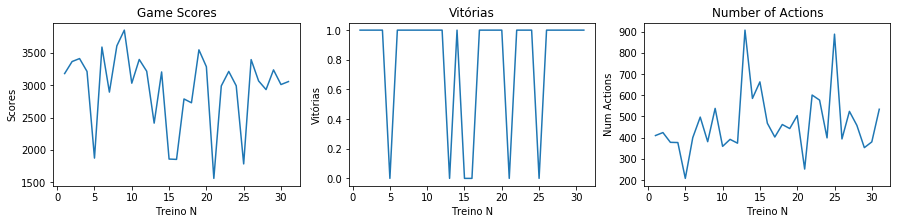

In [13]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

In [11]:
sum(gamesScores)/len(gamesScores)

2952.8064516129034

In [ ]:
layoutType='smallClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

In [ ]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

In [ ]:
layoutType='mediumClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

In [ ]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

In [ ]:
layoutType='originalClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

In [ ]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

In [12]:
# GAME LAYOUTS: smallClassic, mediumClassic, originalClassic
gameLayout = layout.getLayout( 'mediumClassic' )

ind = GPTree()
ind.random_tree(True, 2)
ind.print_tree()

pacman = MyGoWestAgent(ind)
# pacman.setTree(ind)

ghostType = loadAgent('RandomGhost', True)
ghosts = [ghostType( i+1 ) for i in range( 4 )]

import textDisplay
textDisplay.SLEEP_TIME = 0.1
gameDisplay = textDisplay.PacmanGraphics()

runGames( gameLayout, pacman, ghosts, gameDisplay, 4, False)

layout:  mediumClassic


NameError: name 'GPTree' is not defined